In [10]:
import dask
import dask_awkward as dak
from coffea.dataset_tools import preprocess
from distributed import Client
from matplotlib import pyplot as plt

import egamma_tnp
from egamma_tnp.plot import plot_efficiency
from egamma_tnp.triggers import ElectronTagNProbeFromNTuples

In [2]:
client = Client()

In [4]:
filters_to_check = [
    "hltEG30L1SingleEGOrEtFilter",
    "hltEle30WPTightClusterShapeFilter",
    "hltEle30WPTightHEFilter",
    "hltEle30WPTightEcalIsoFilter",
    "hltEle30WPTightHcalIsoFilter",
    "hltEle30WPTightPixelMatchFilter",
    "hltEle30WPTightPMS2Filter",
    "hltEle30WPTightGsfOneOEMinusOneOPFilter",
    "hltEle30WPTightGsfMissingHitsFilter",
    "hltEle30WPTightGsfDetaFilter",
    "hltEle30WPTightGsfDphiFilter",
    "hltEle30WPTightGsfTrackIsoFilter",
]

In [5]:
fileset = {
    "data_EGamma_Run2023C": {"files": {"tnptuples/data_EGamma_Run2023C.root": "tnpEleTrig/fitter_tree"}},
    "DY_NLO_2023preBPIX": {
        "files": {"tnptuples/mc_DY_NLO_2023preBPIX.root": "tnpEleTrig/fitter_tree"},
        "metadata": {"isMC": True, "pileupJSON": "jsonpog-integration/POG/LUM/2023_Summer23/puWeights.json.gz"},
    },
}

fileset_available, fileset_updates = preprocess(fileset, skip_bad_files=True, step_size=500_000)

In [8]:
egamma_tnp.config.set(
    "pt_bins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

to_compute = {}


def myfilter(events):
    return events[events.passHLTEG30L1SingleEGOrEtFilter == 1]


for filter in filters_to_check:
    tnp = ElectronTagNProbeFromNTuples(
        fileset_available,
        [f"pass{filter.replace('hlt', 'HLT')}"],
        use_sc_eta=False,
        probes_pt_cut=20,
        cutbased_id="passingCutBasedTight122XV1",
        extra_filter=myfilter,
    )
    to_compute[filter] = tnp.get_1d_pt_eta_phi_tnp_histograms(
        f"pass{filter.replace('hlt', 'HLT')}",
        vars=["el_pt", "el_sc_eta", "el_sc_phi"],
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=5,
        uproot_options={"allow_read_errors_with_report": False},
    )

dak.necessary_columns(to_compute)

{'from-uproot-9179775eb50a5ee700025790777fa30e': frozenset({'el_eta',
            'el_pt',
            'el_q',
            'el_sc_eta',
            'el_sc_phi',
            'pair_mass',
            'passHLTEG30L1SingleEGOrEtFilter',
            'passHLTEle30WPTightClusterShapeFilter',
            'passHLTEle30WPTightEcalIsoFilter',
            'passHLTEle30WPTightGsfDetaFilter',
            'passHLTEle30WPTightGsfDphiFilter',
            'passHLTEle30WPTightGsfMissingHitsFilter',
            'passHLTEle30WPTightGsfOneOEMinusOneOPFilter',
            'passHLTEle30WPTightGsfTrackIsoFilter',
            'passHLTEle30WPTightHEFilter',
            'passHLTEle30WPTightHcalIsoFilter',
            'passHLTEle30WPTightPMS2Filter',
            'passHLTEle30WPTightPixelMatchFilter',
            'passingCutBasedTight122XV1',
            'tag_Ele_eta',
            'tag_Ele_pt',
            'tag_Ele_q'}),
 'from-uproot-7da9d5d954e89c5aab84edd59daae41a': frozenset({'el_eta',
            'el_pt',
    

In [11]:
%%time

out = dask.compute(to_compute)[0]

CPU times: user 29.2 s, sys: 1.35 s, total: 30.5 s
Wall time: 39.7 s


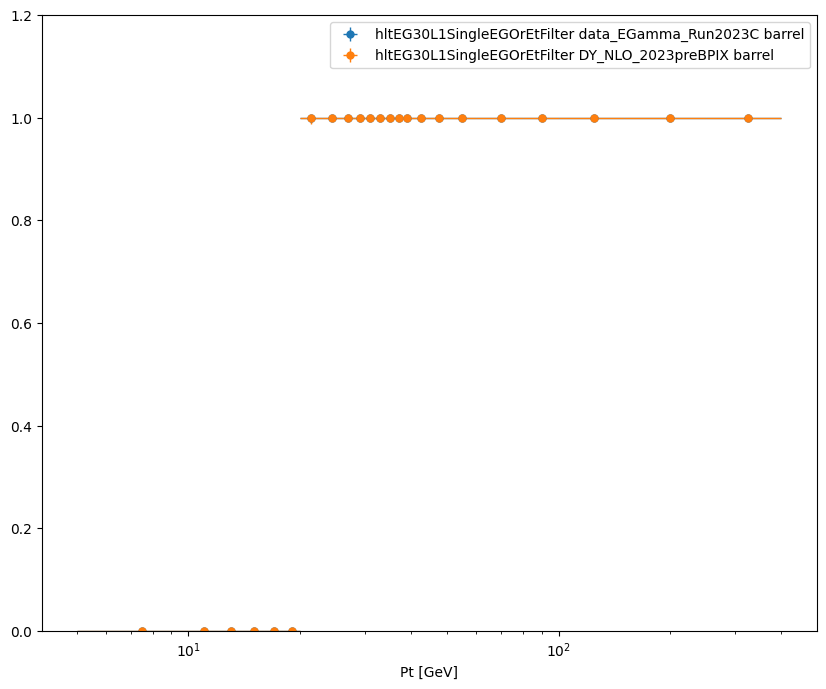

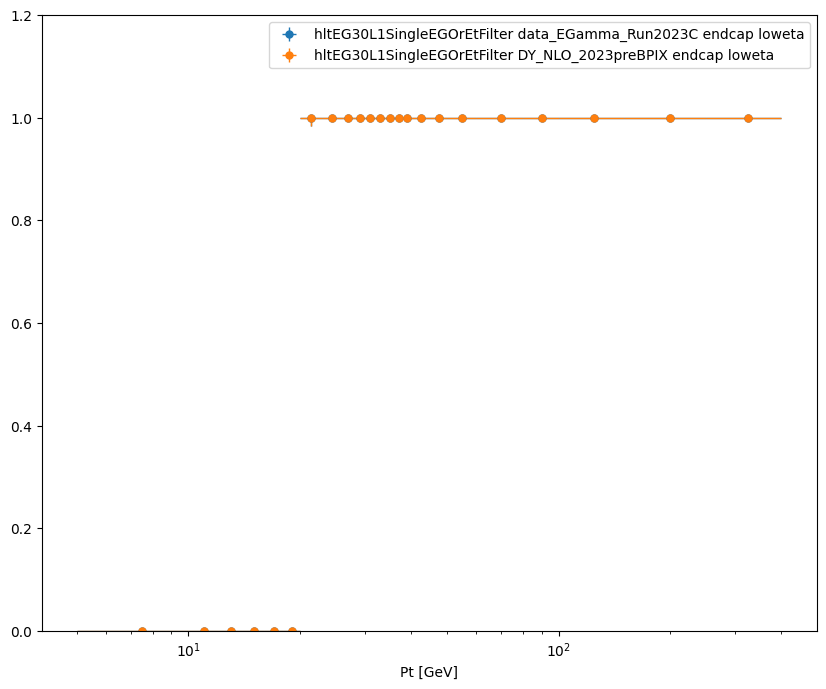

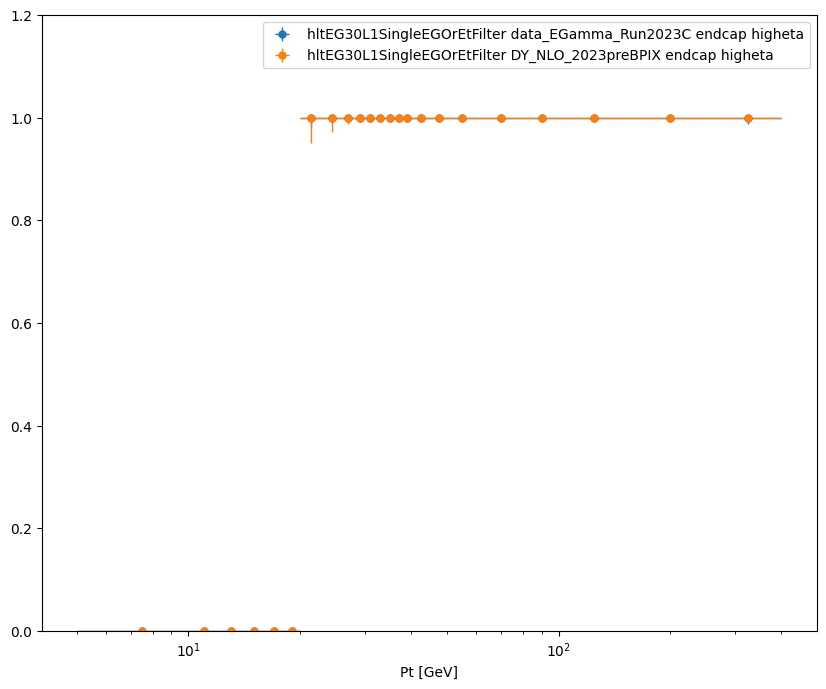

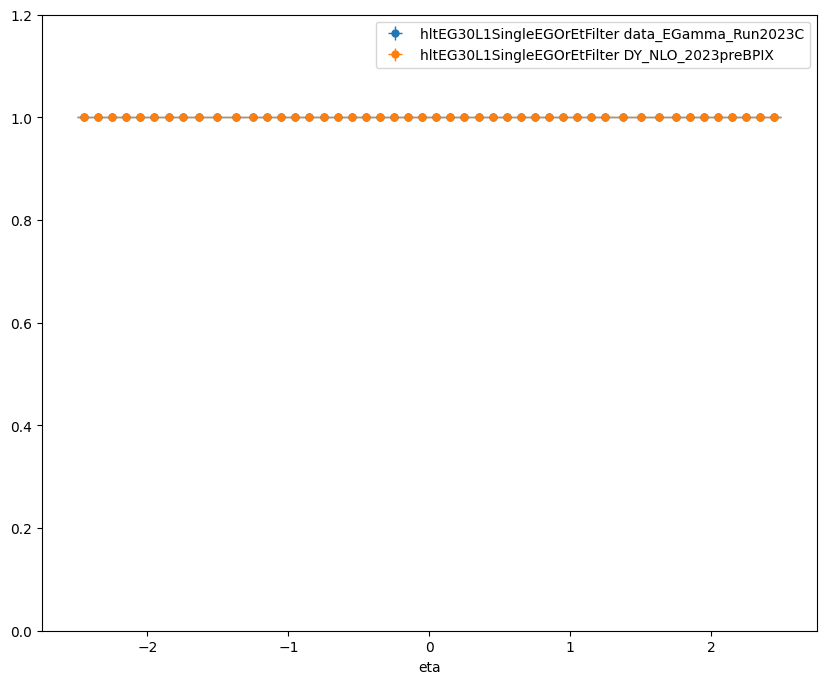

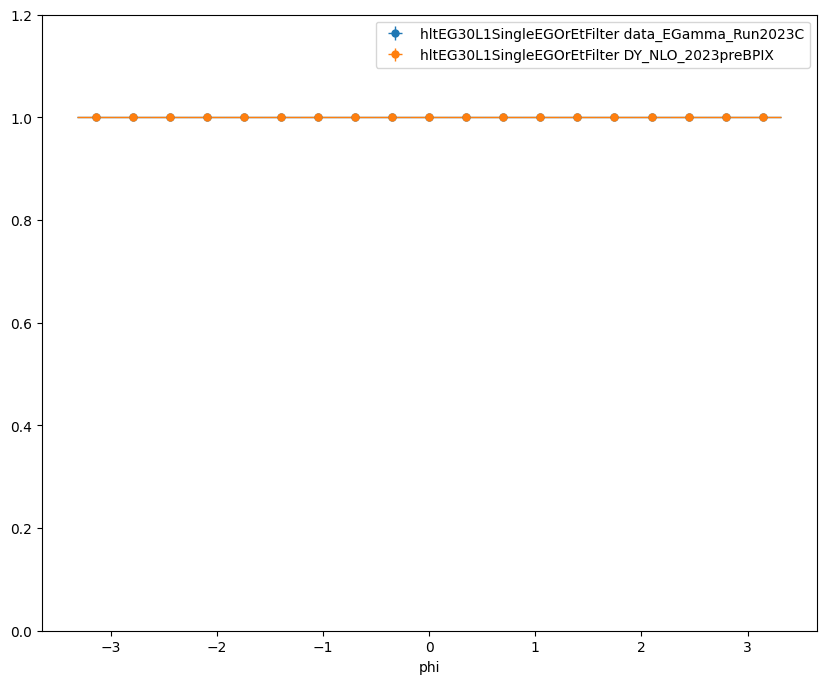

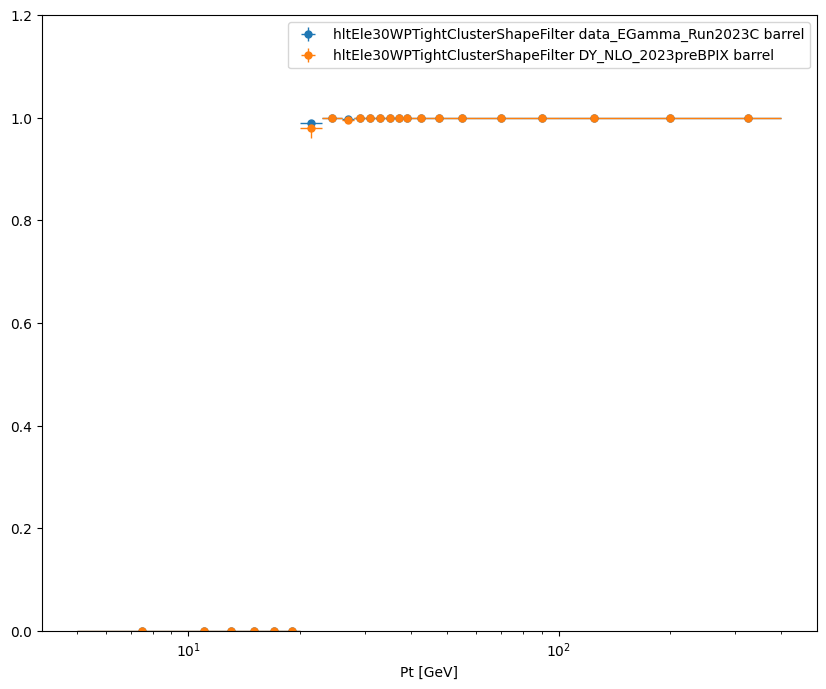

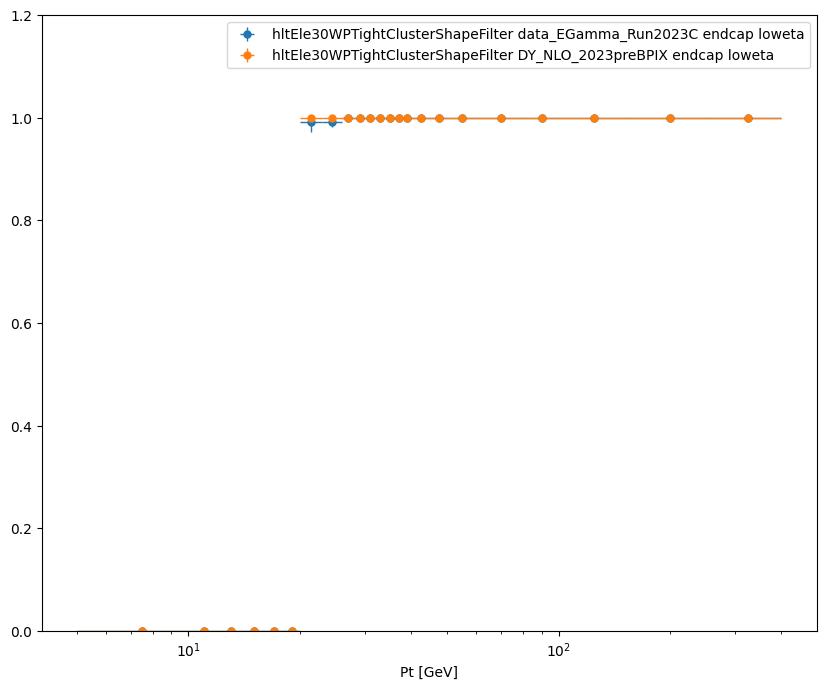

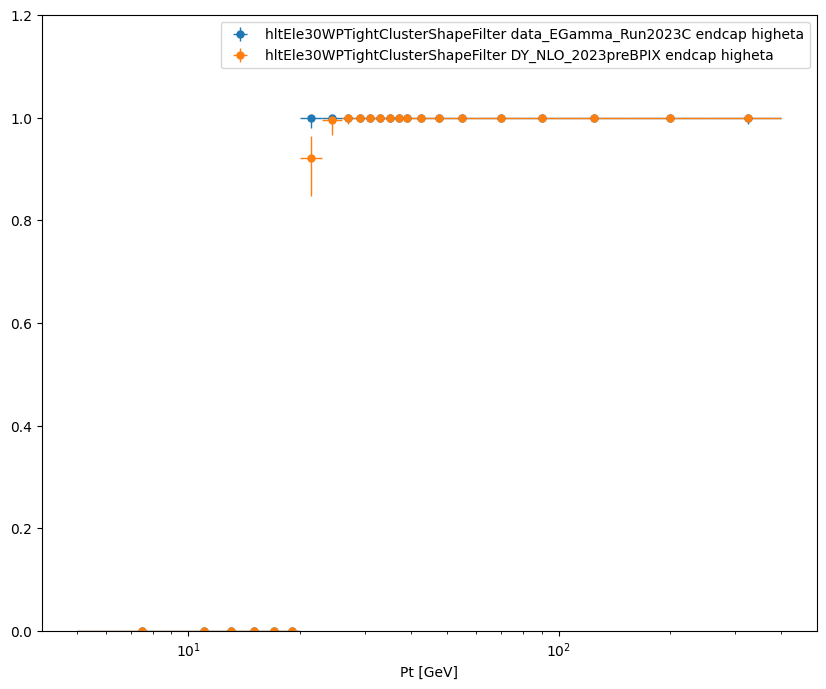

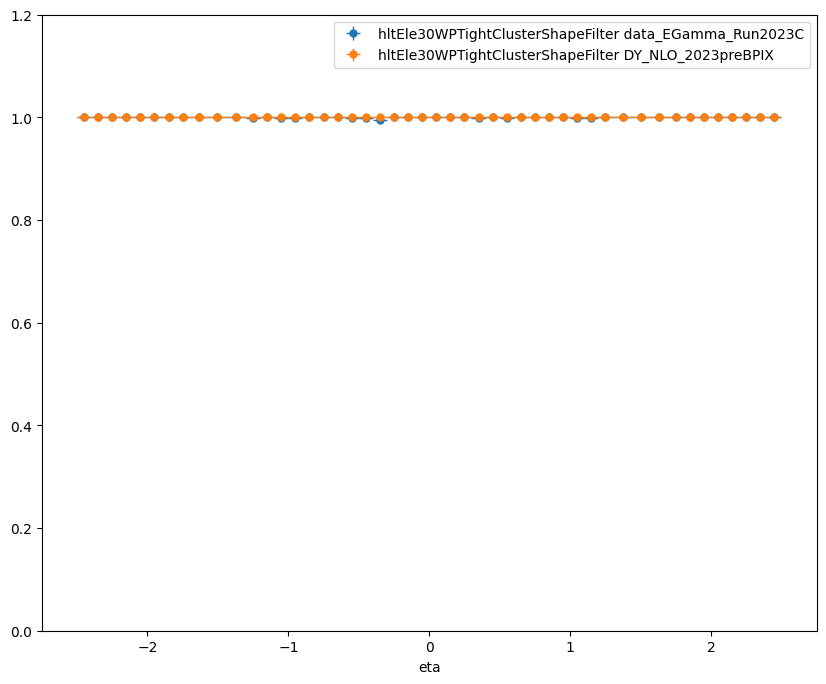

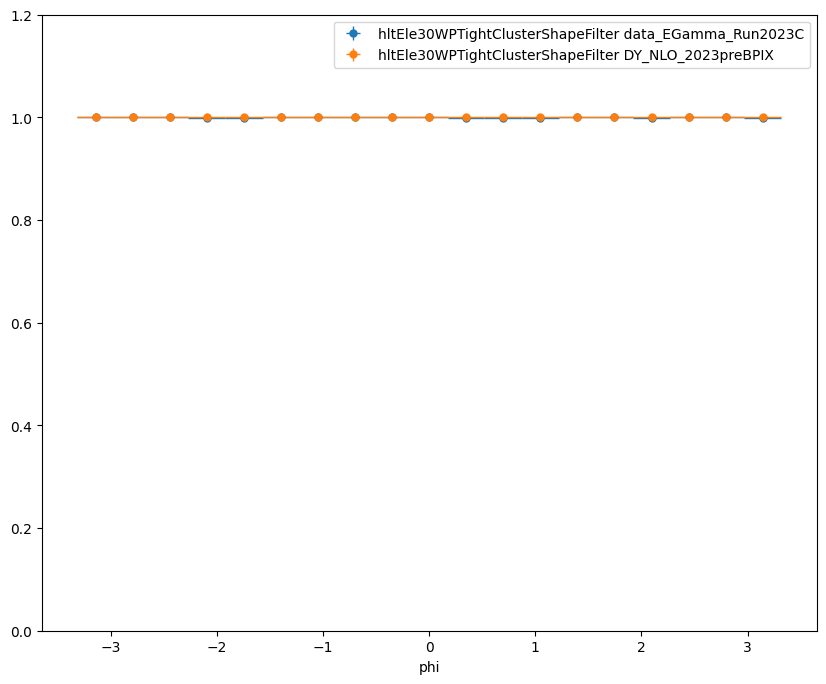

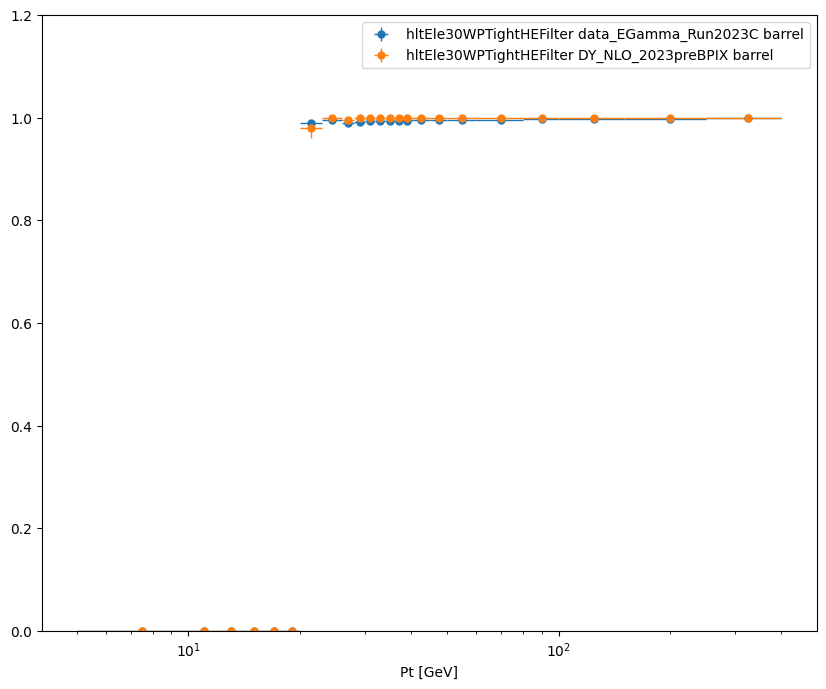

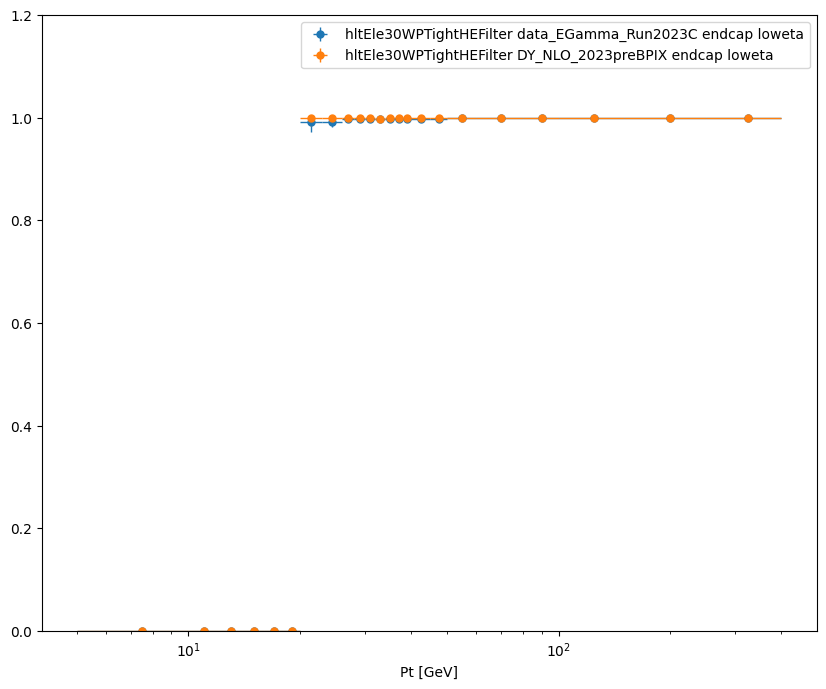

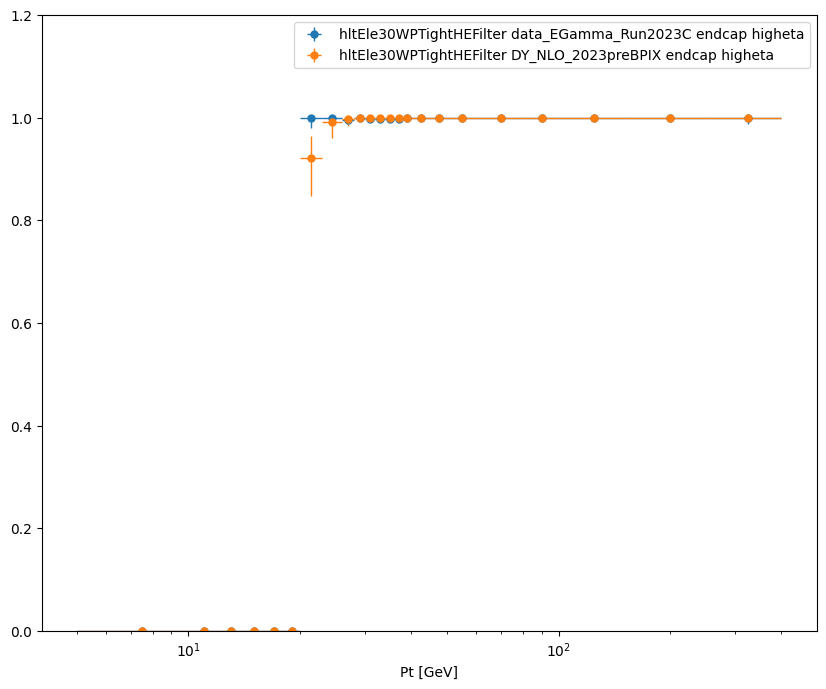

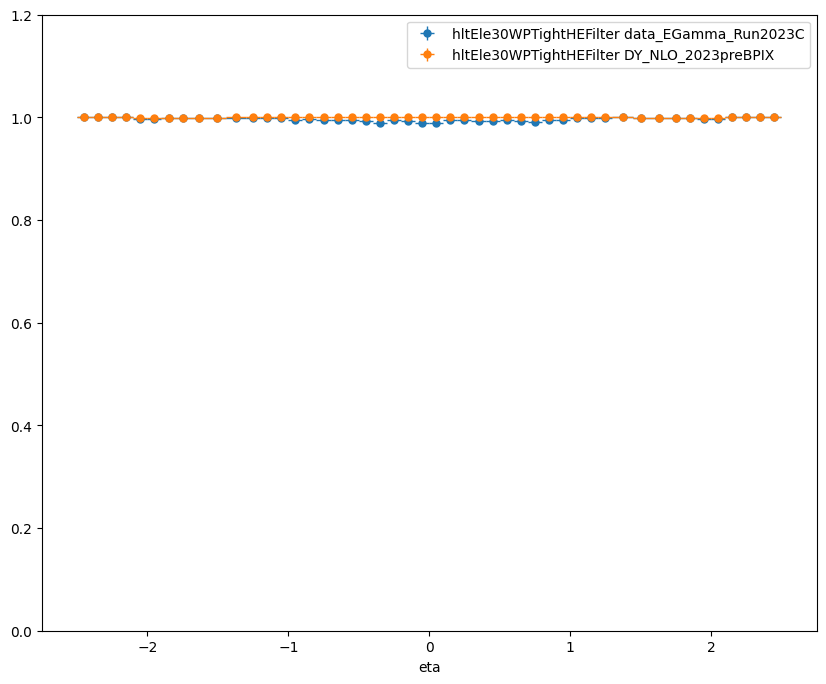

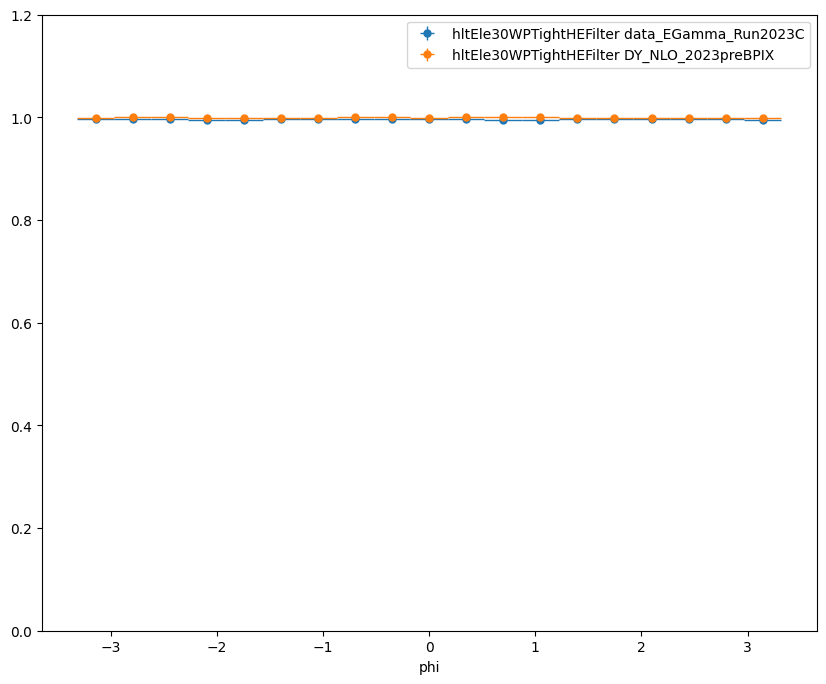

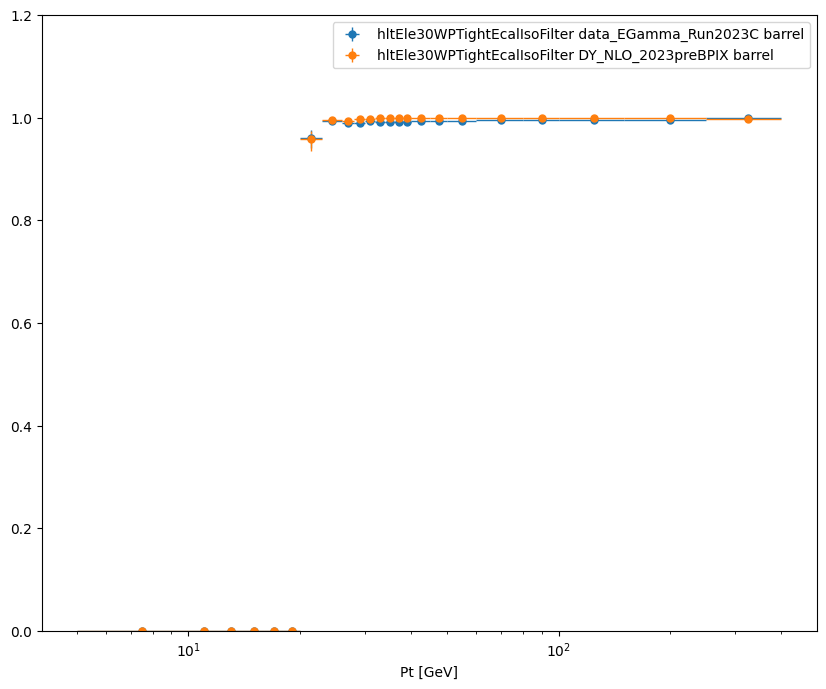

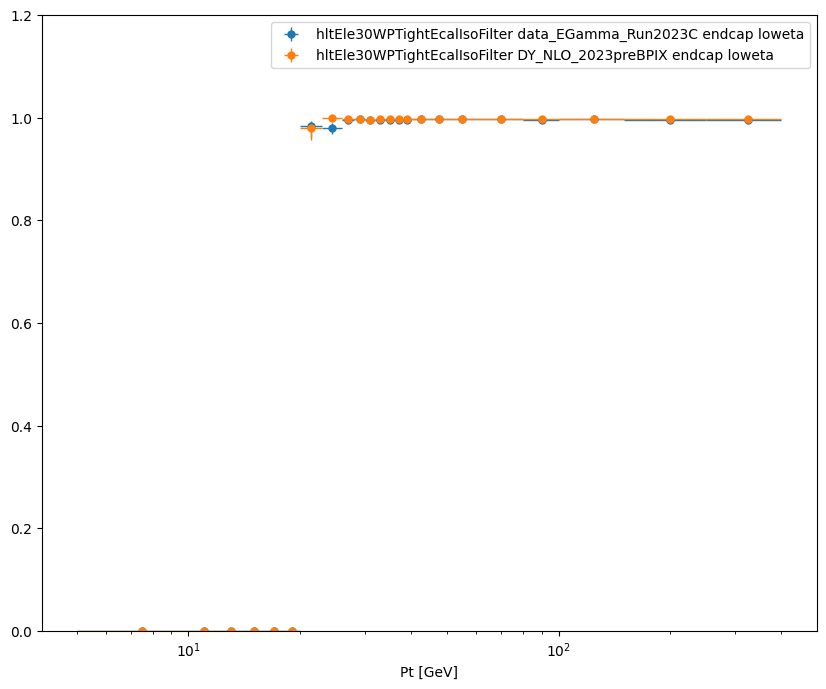

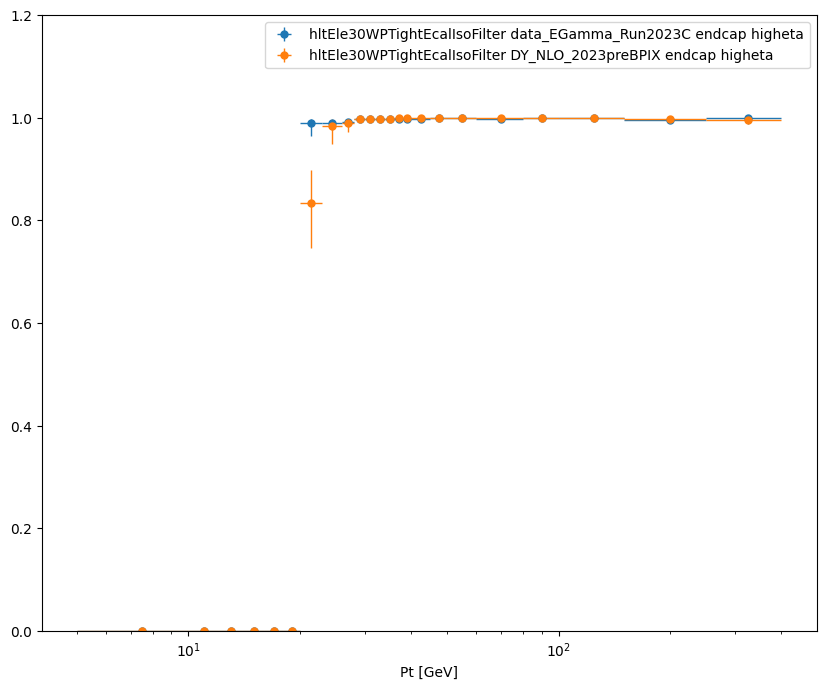

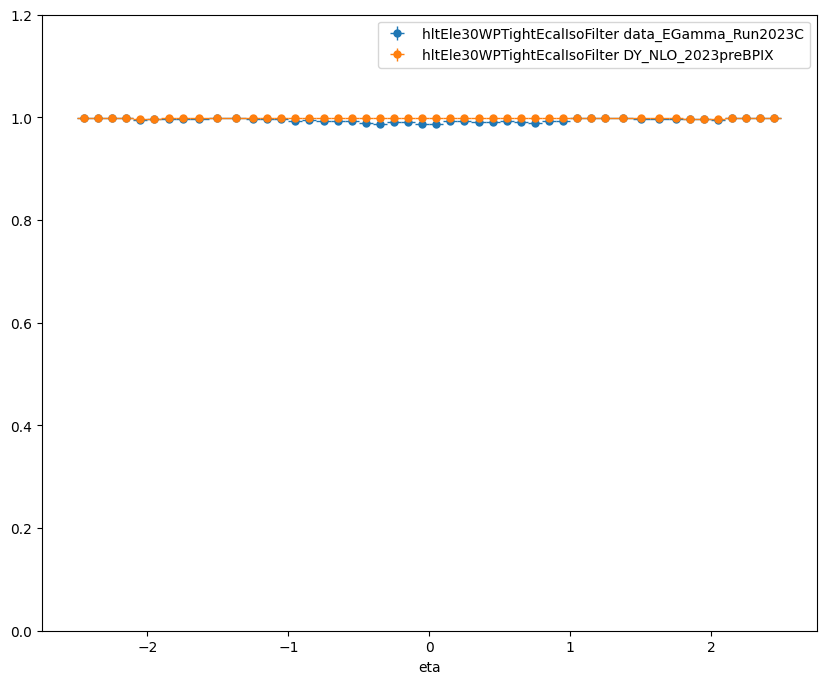

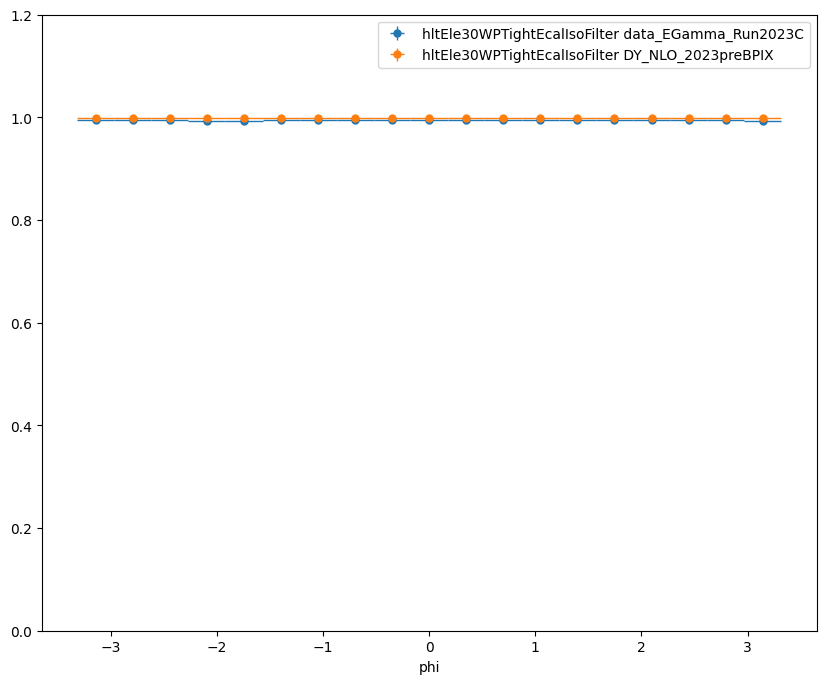

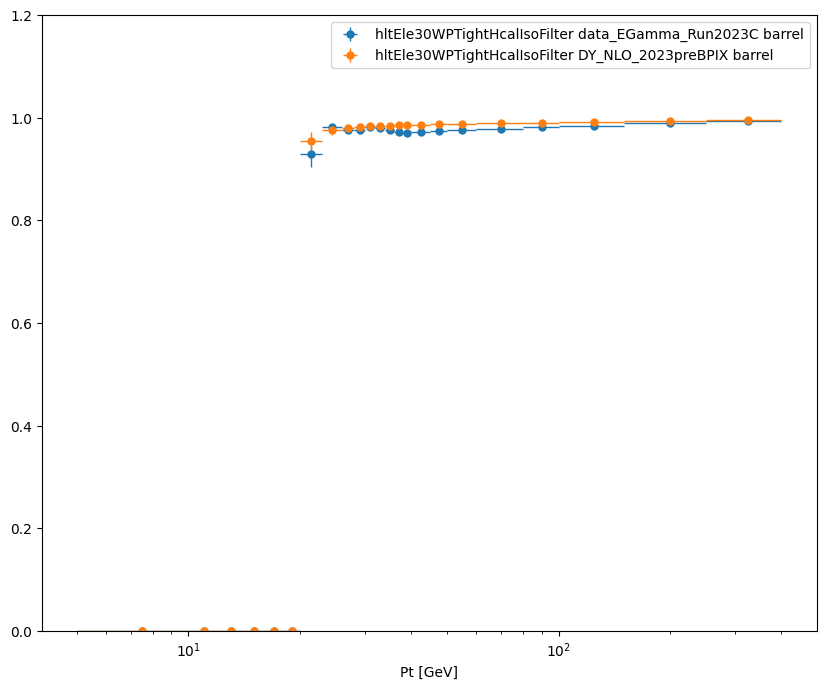

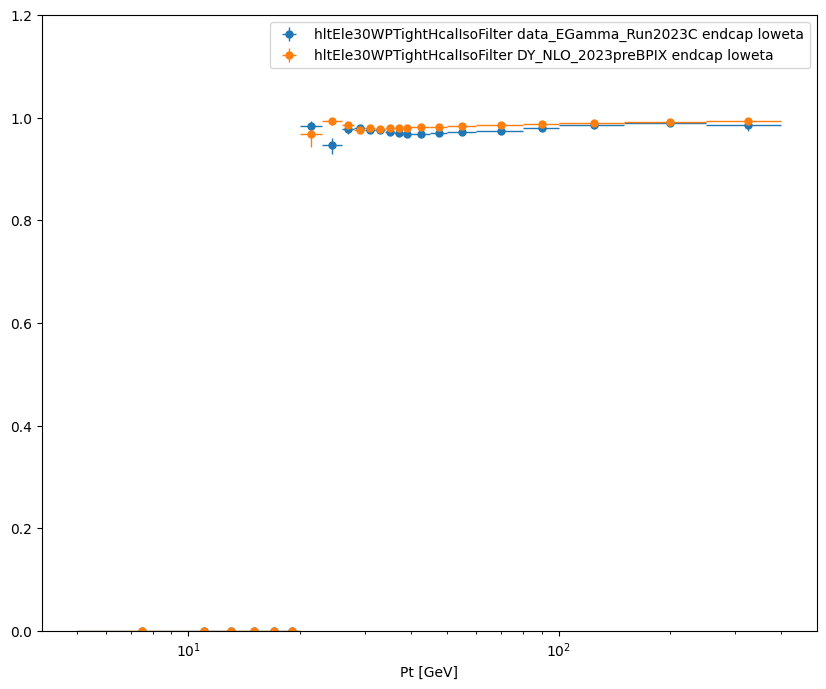

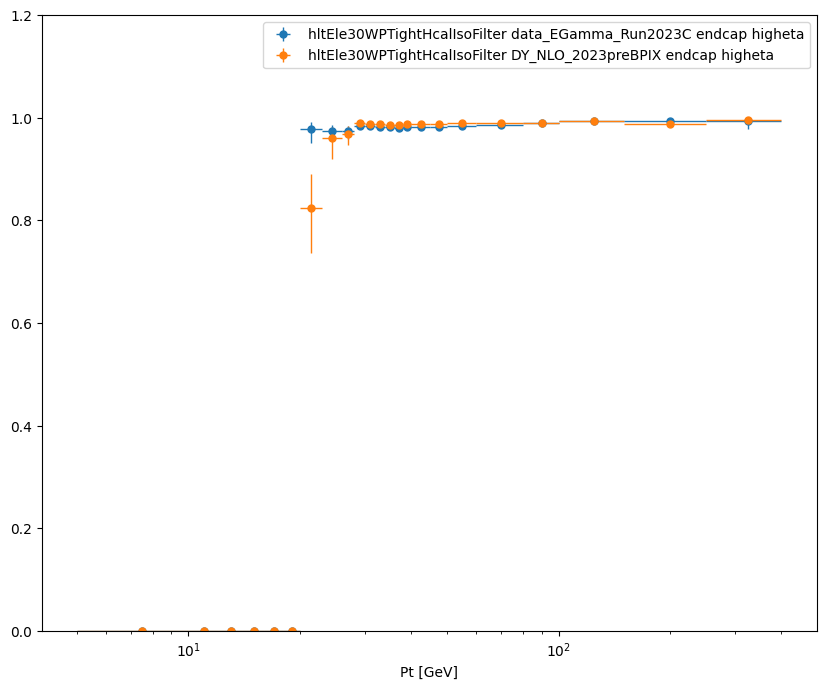

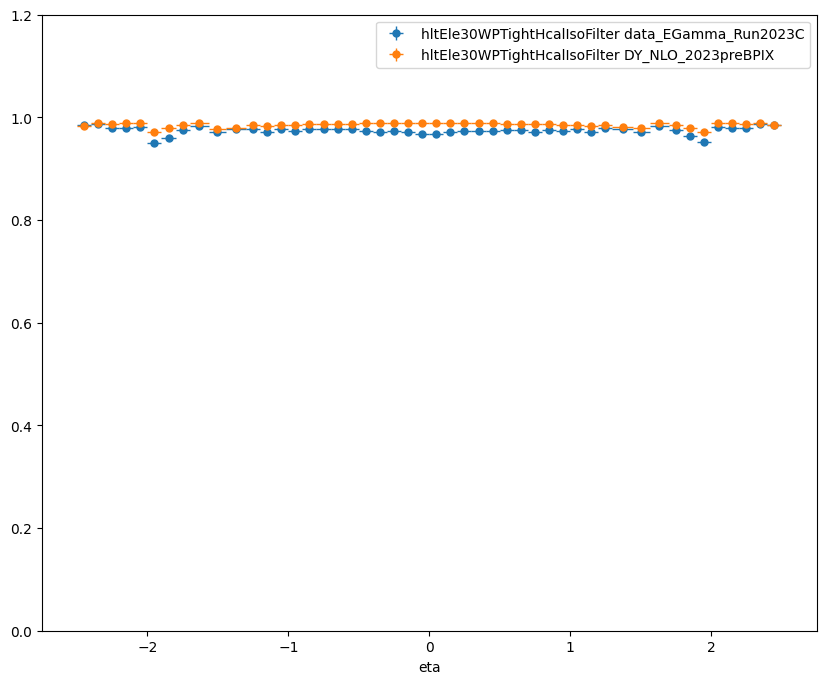

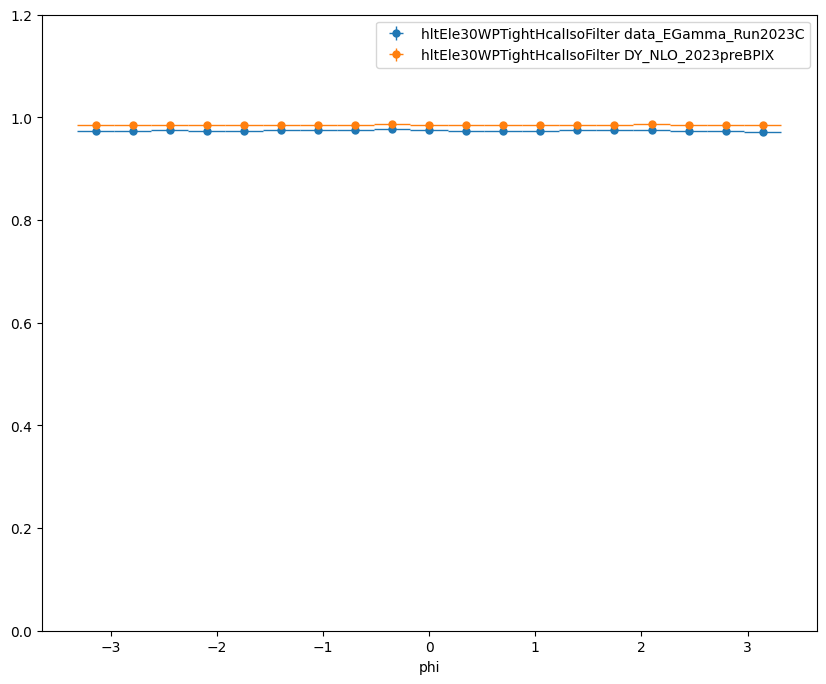

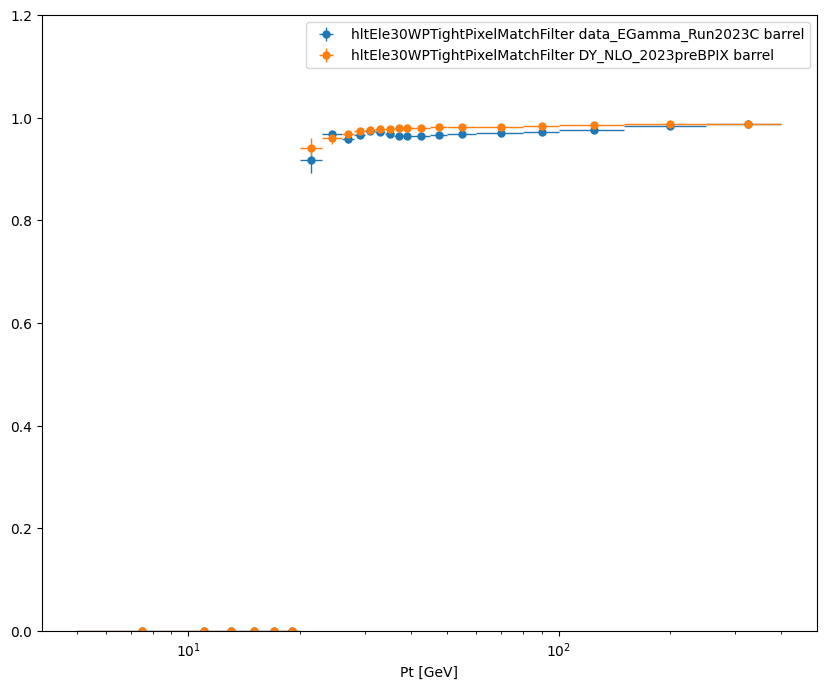

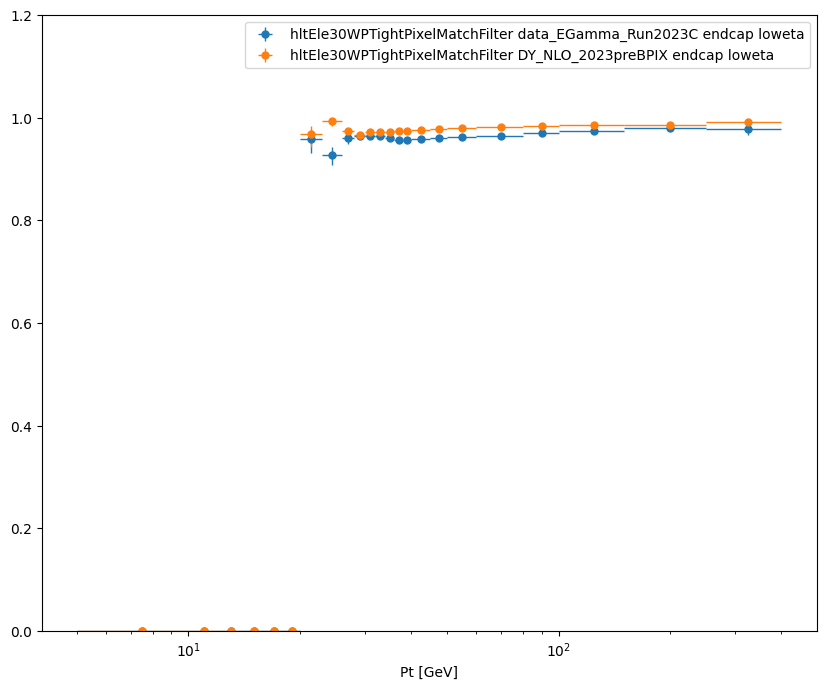

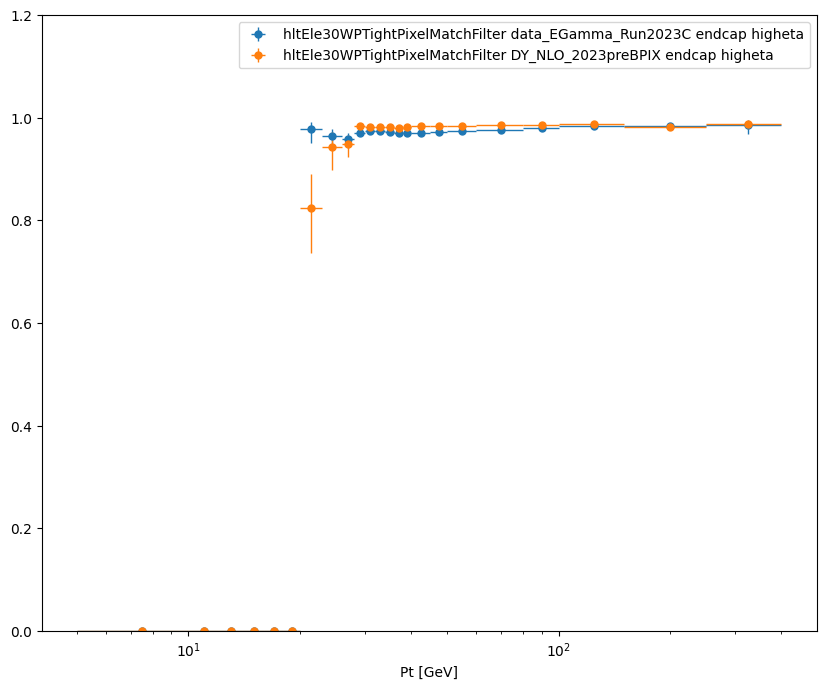

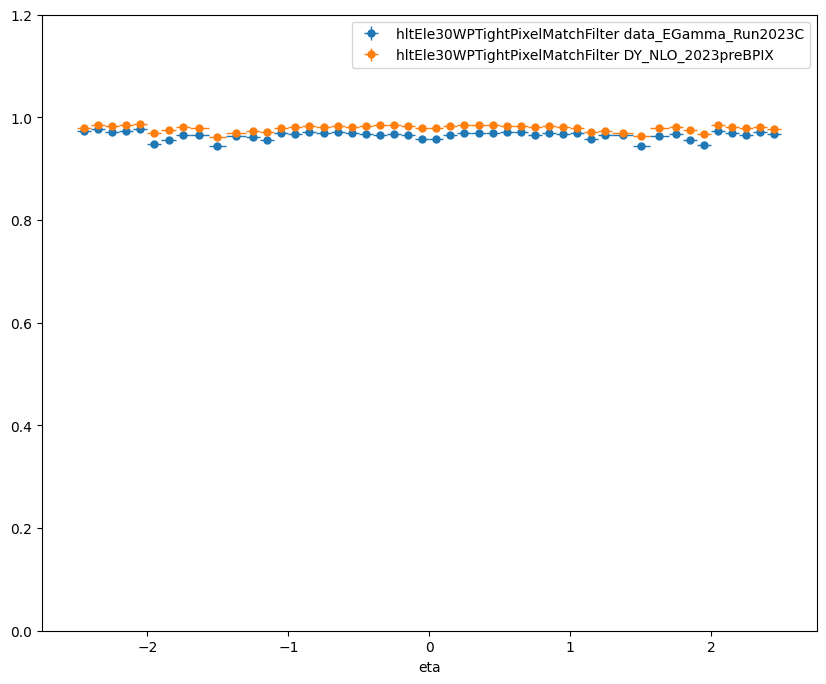

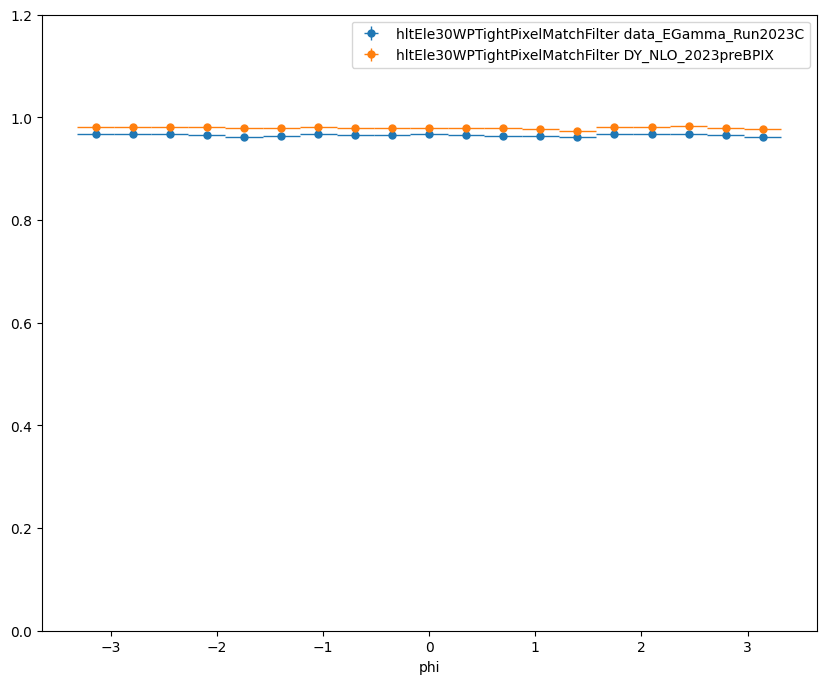

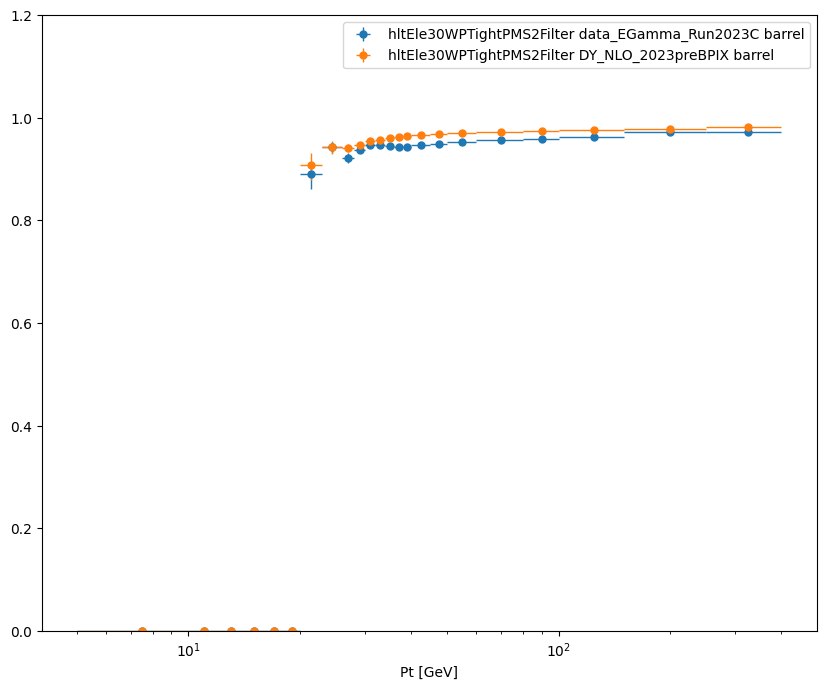

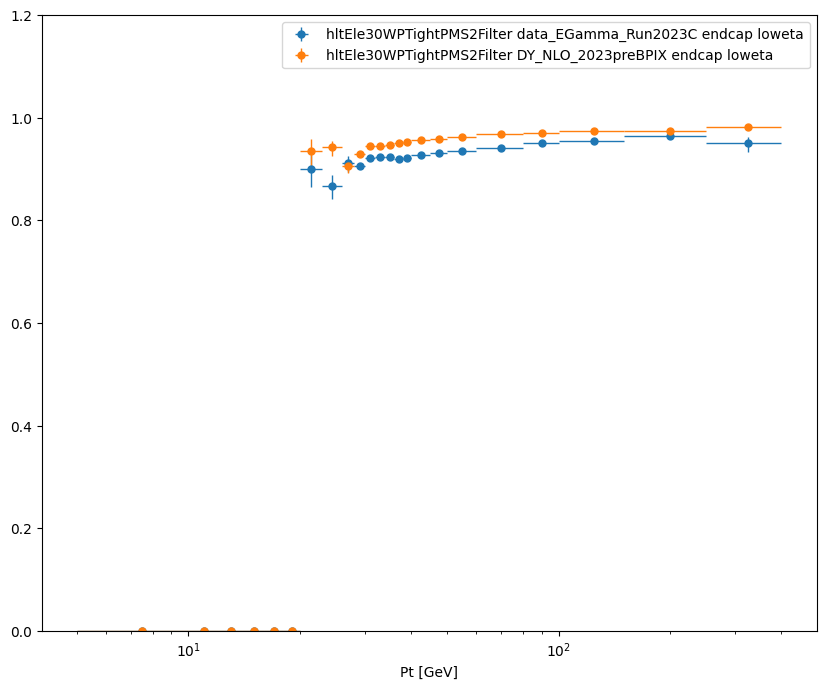

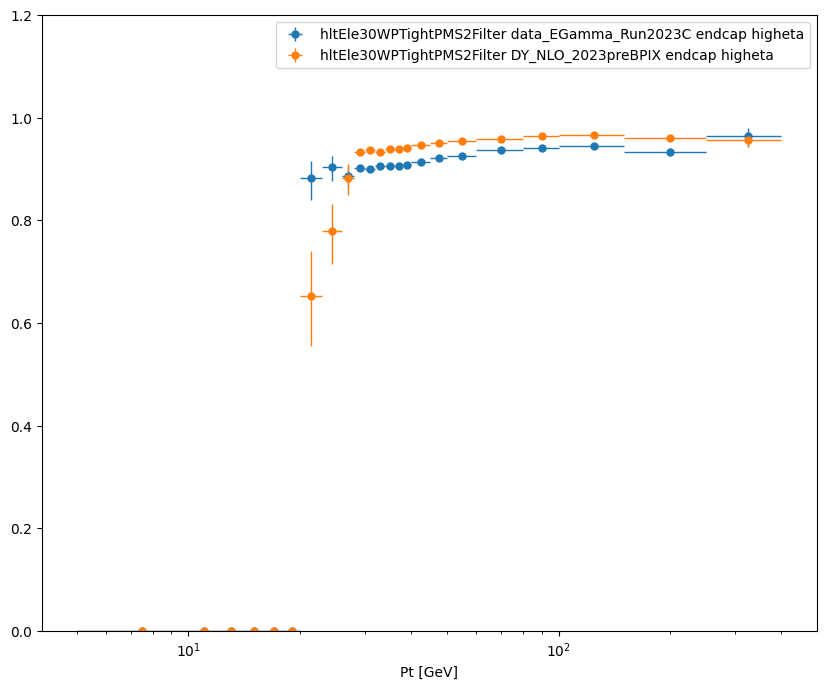

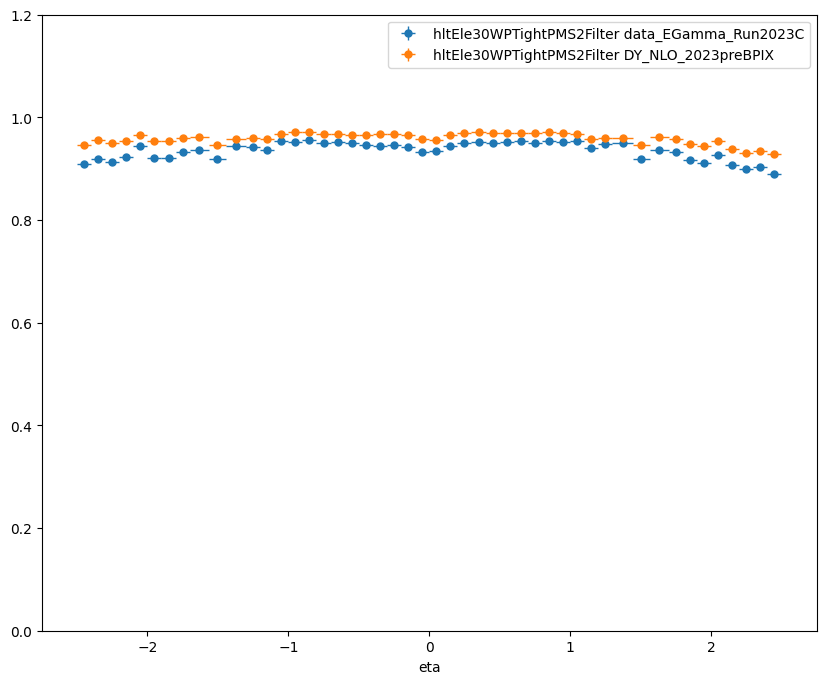

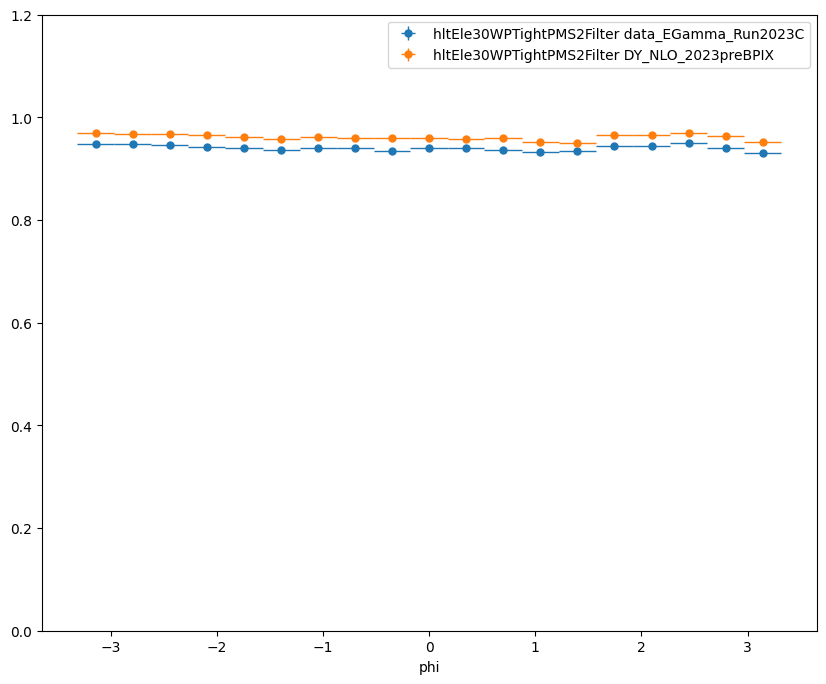

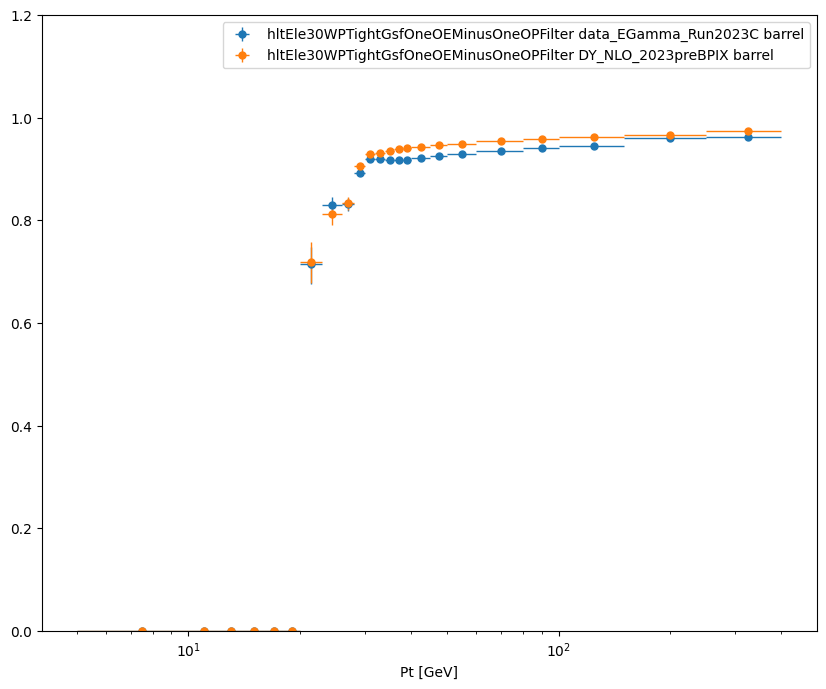

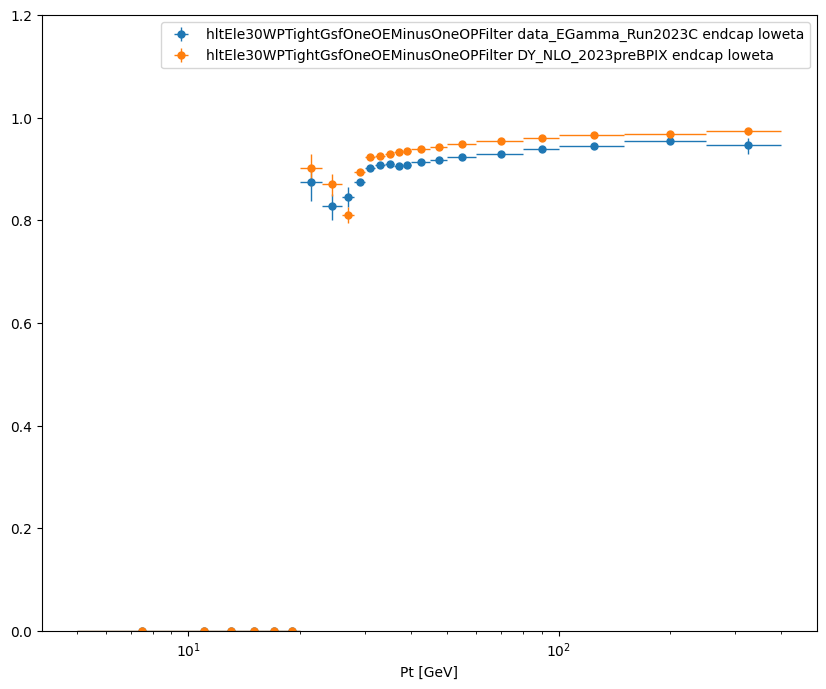

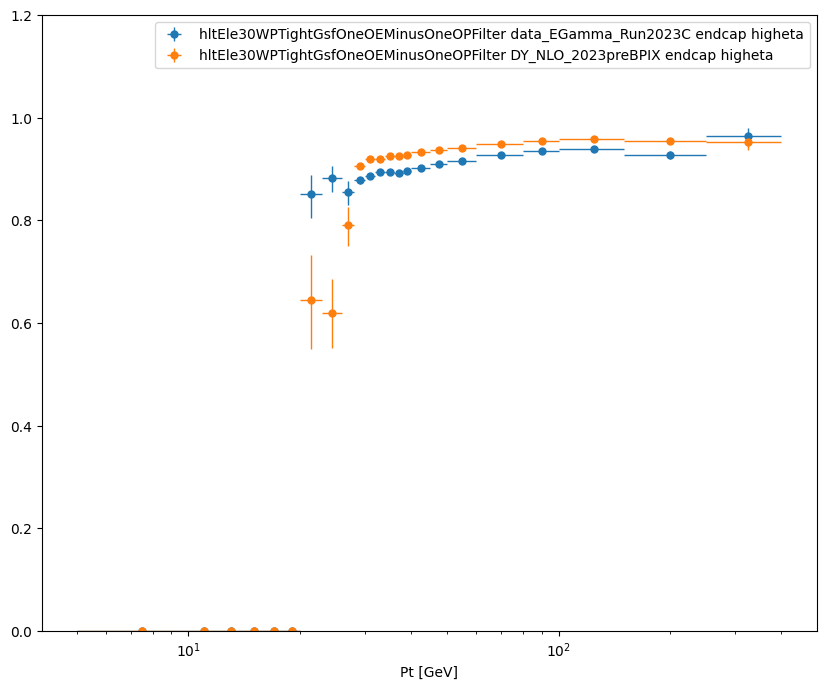

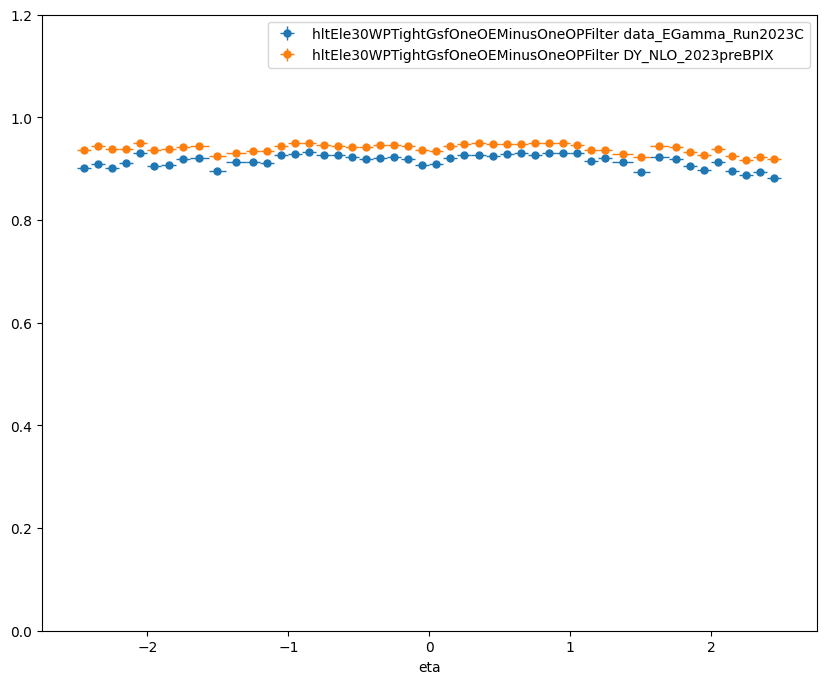

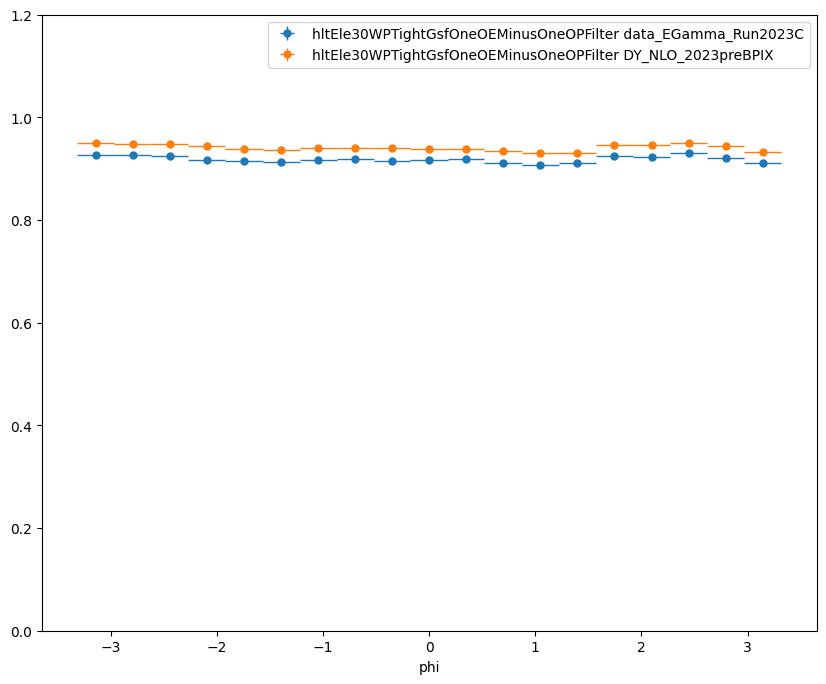

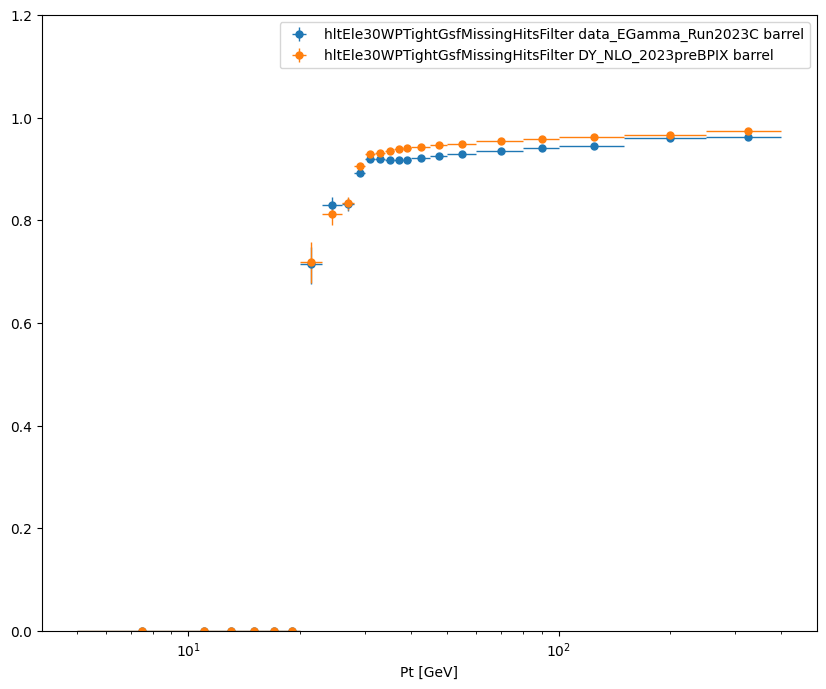

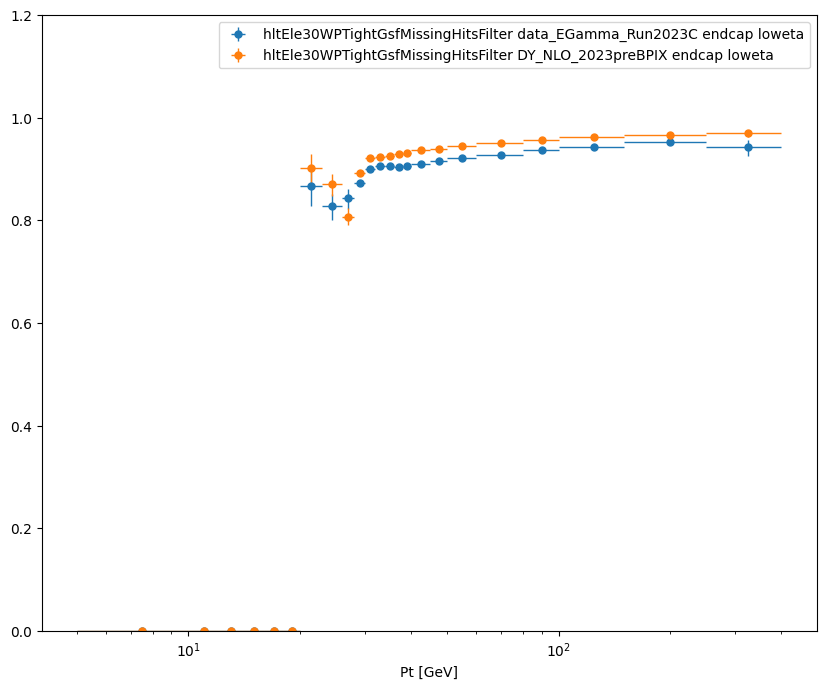

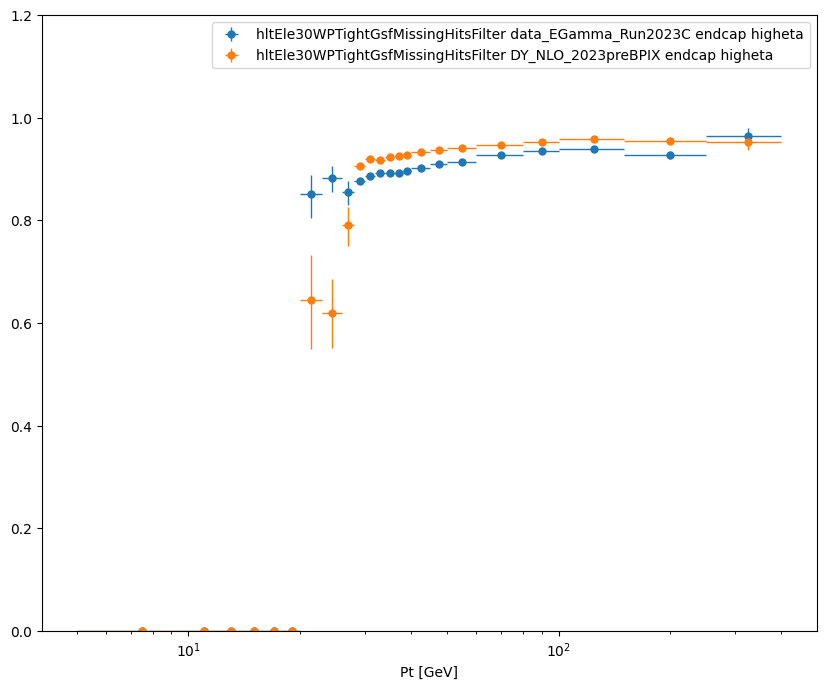

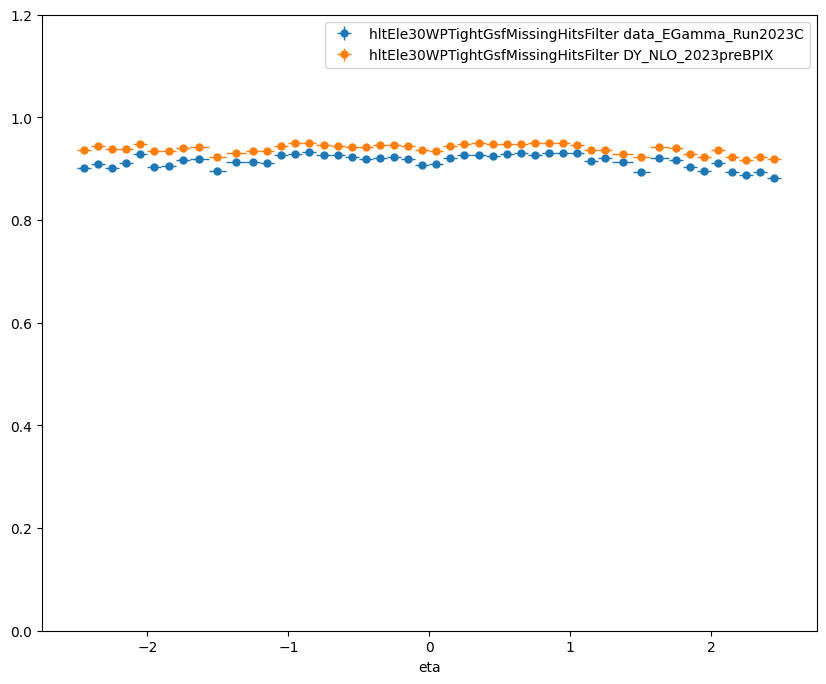

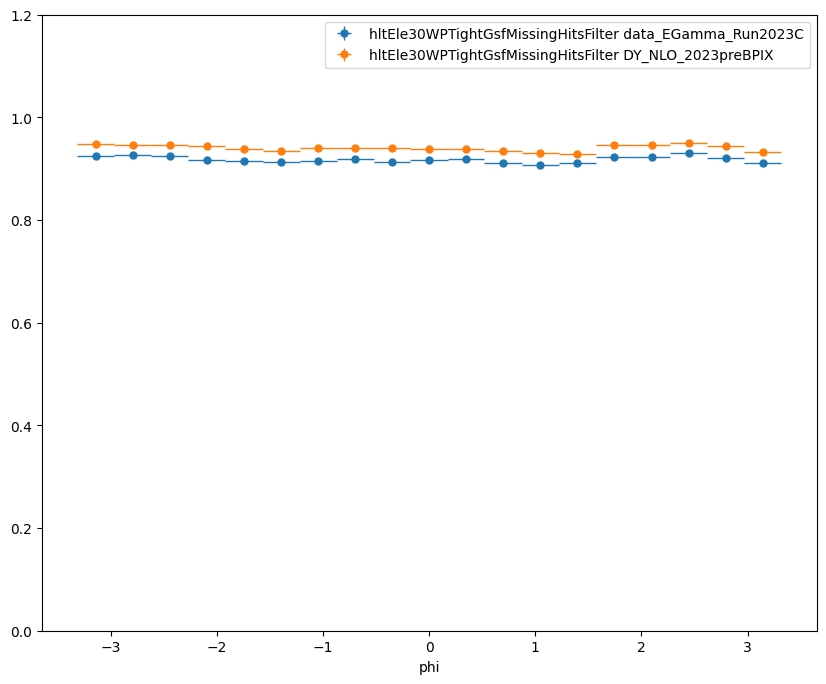

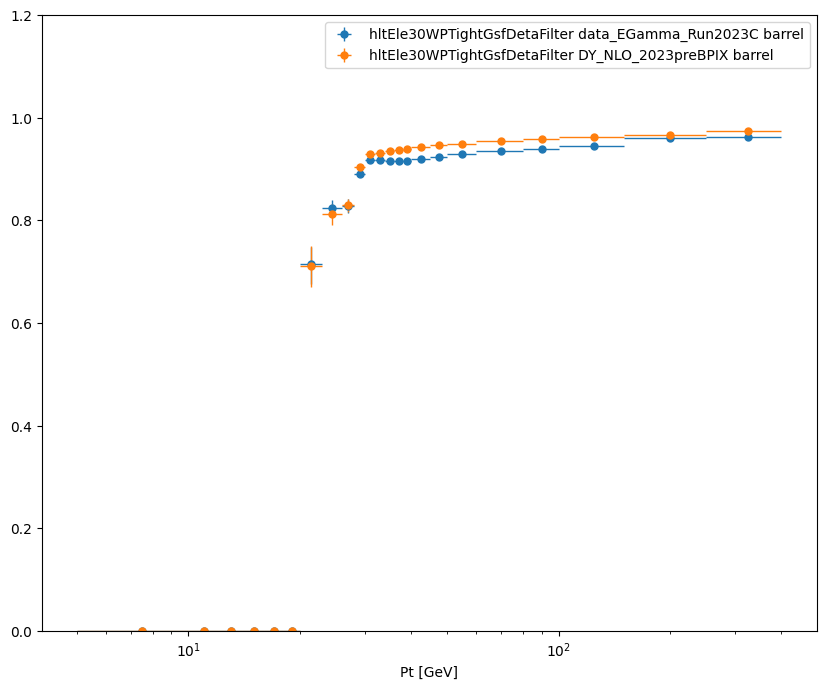

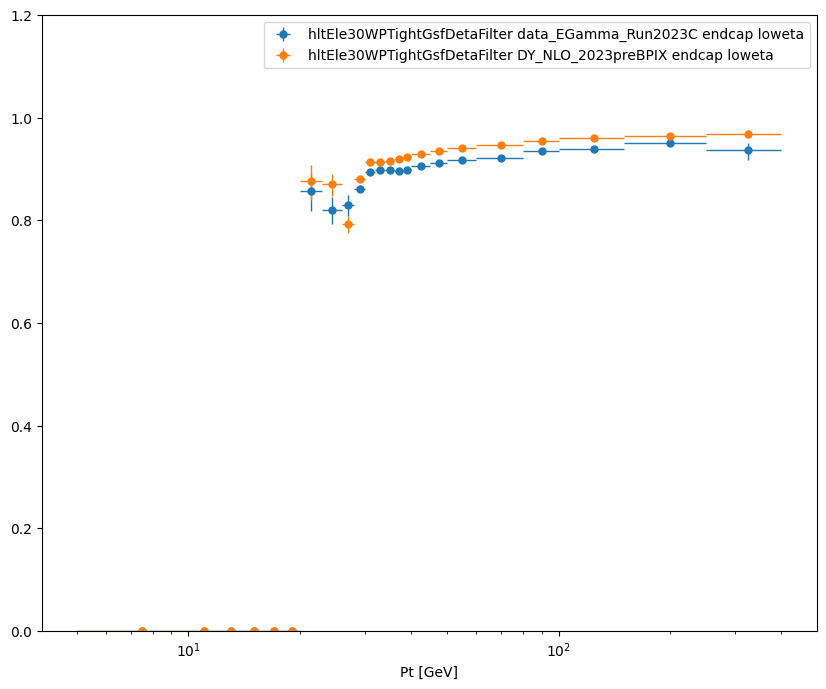

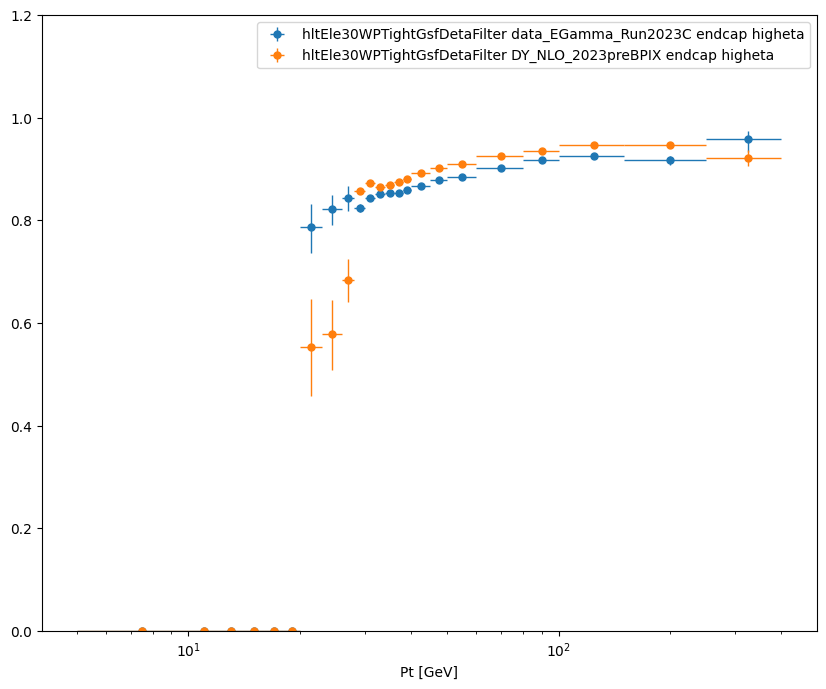

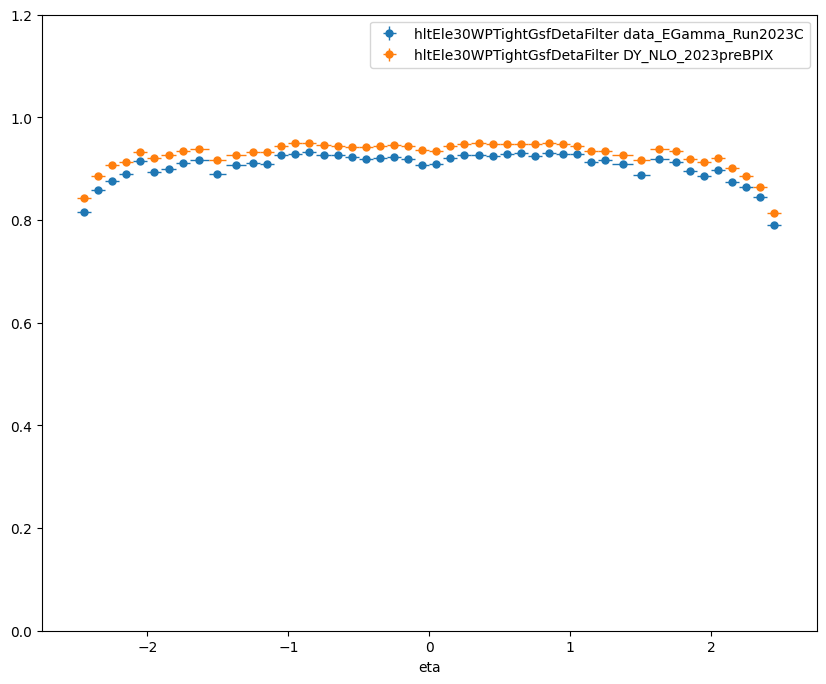

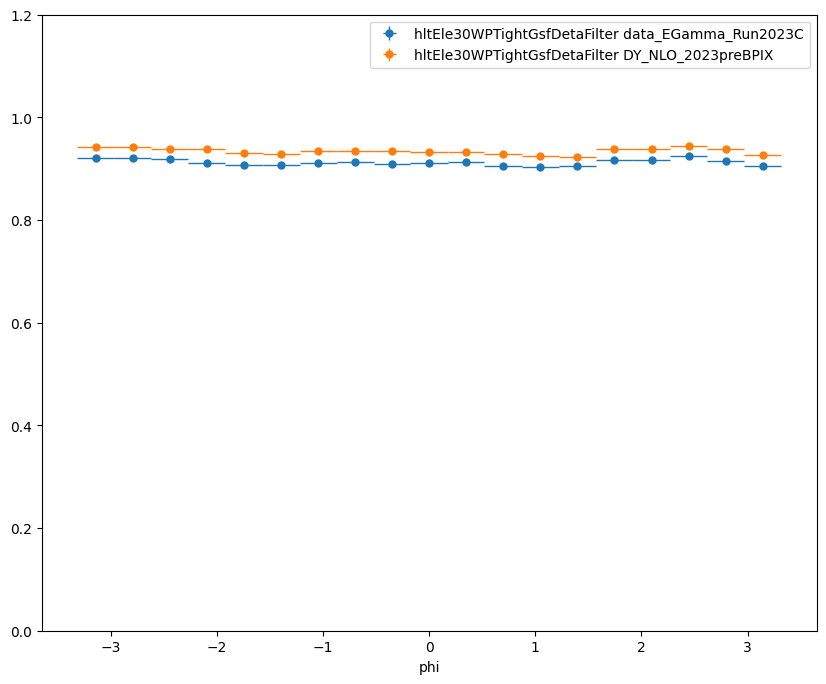

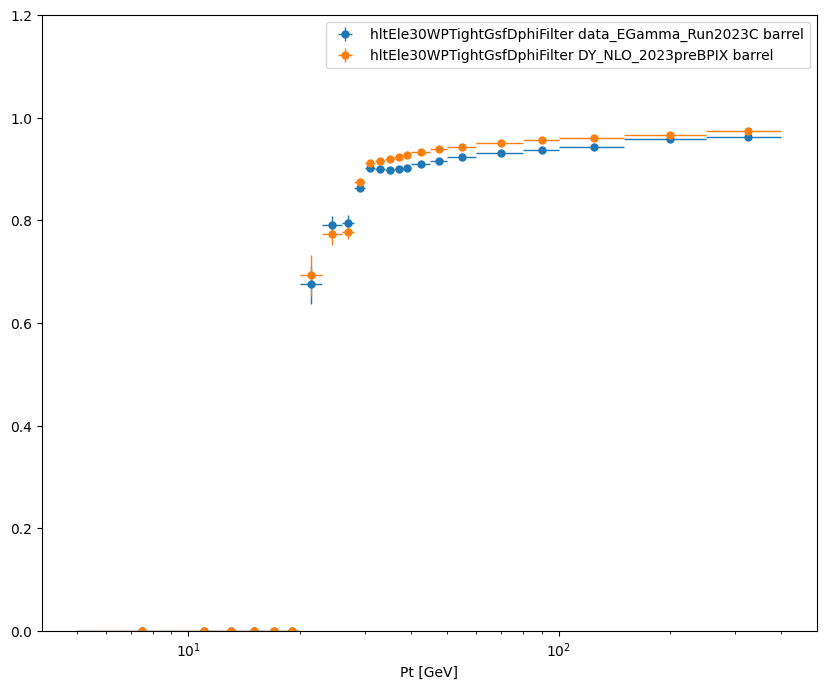

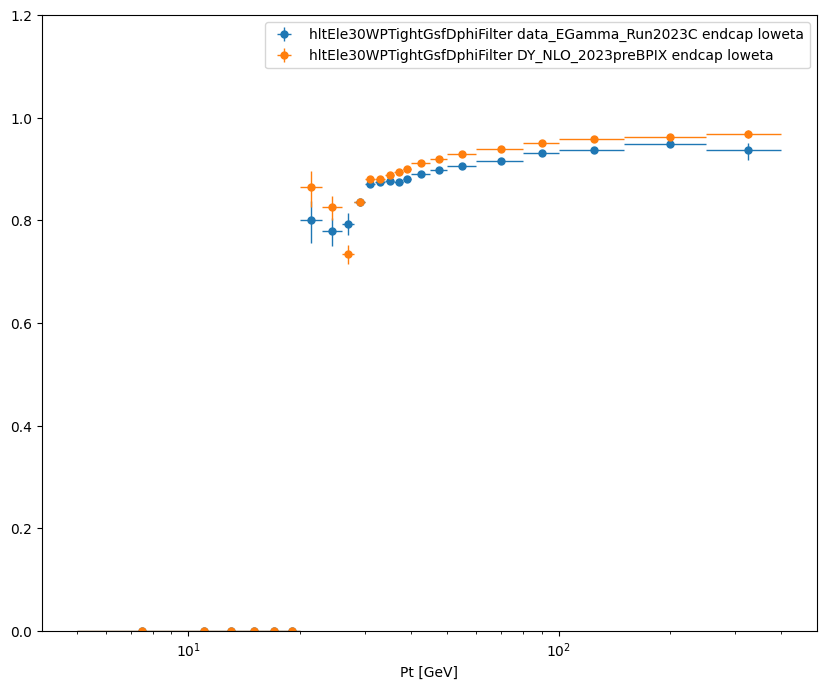

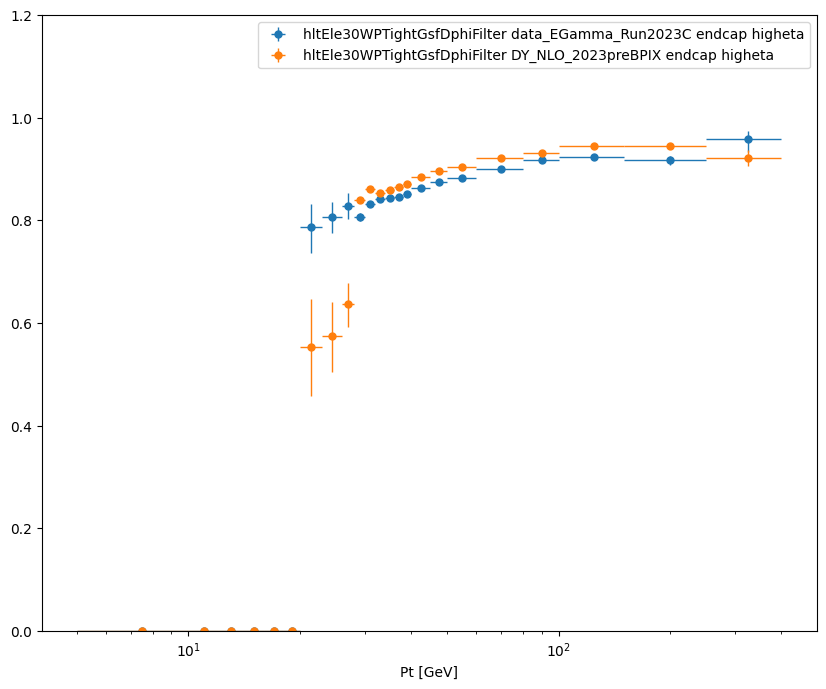

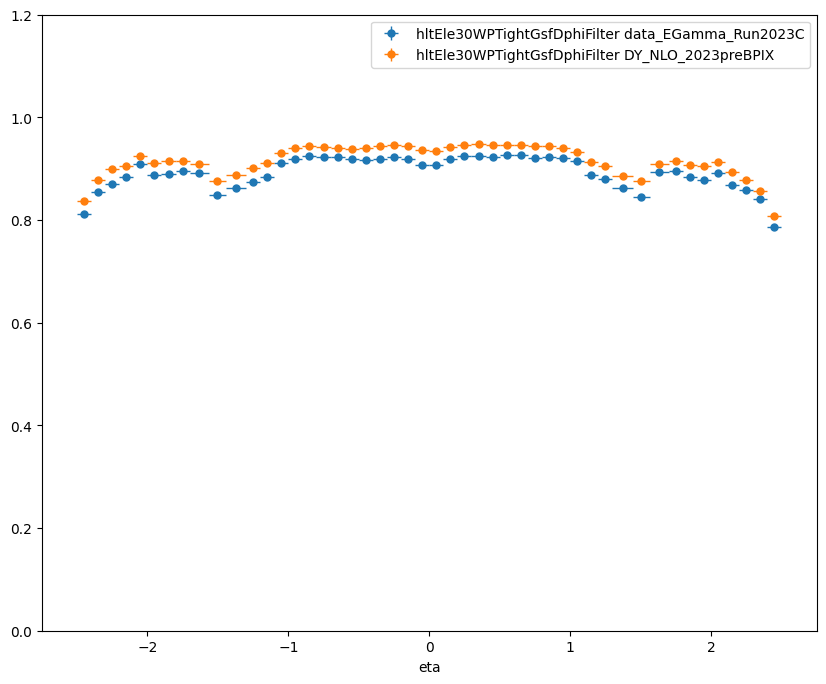

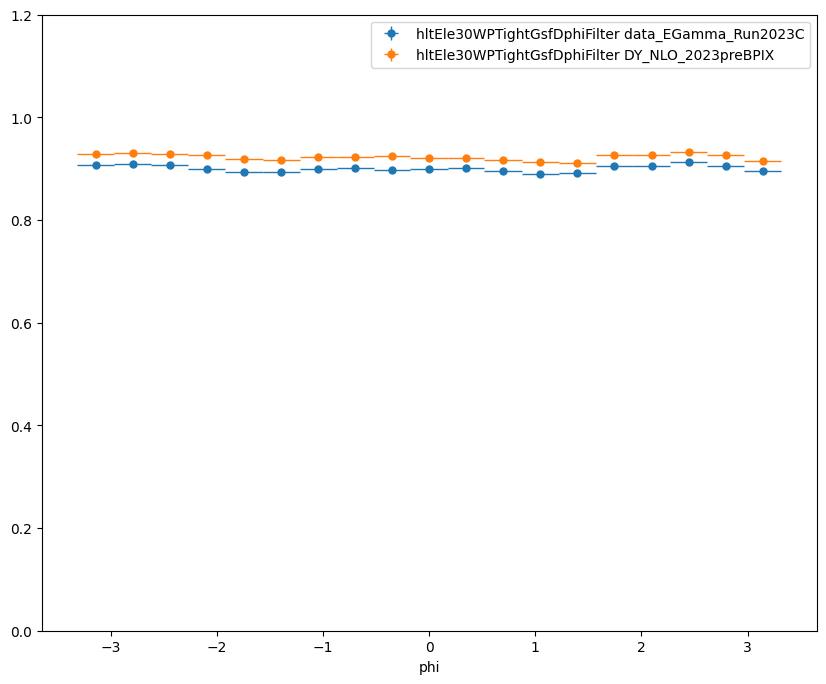

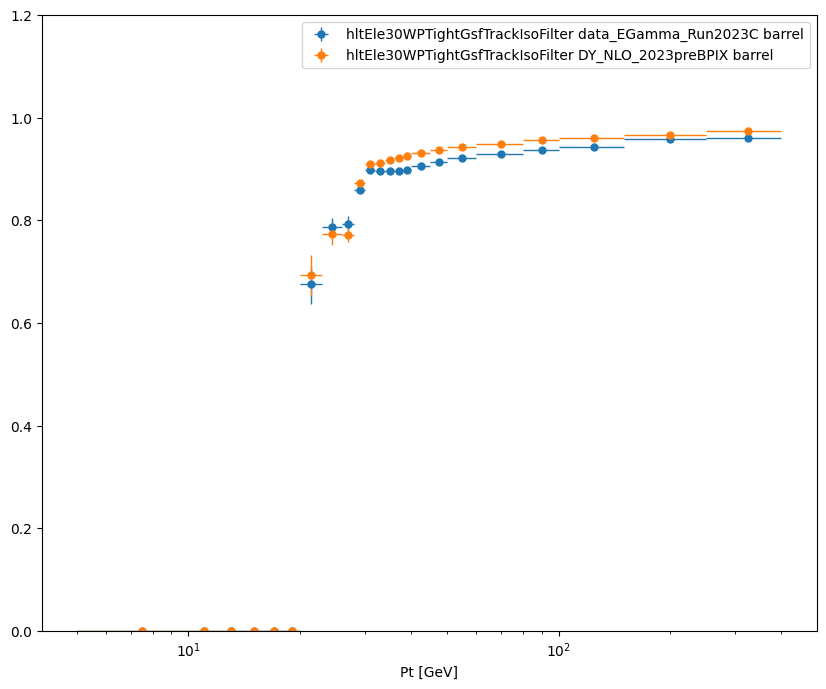

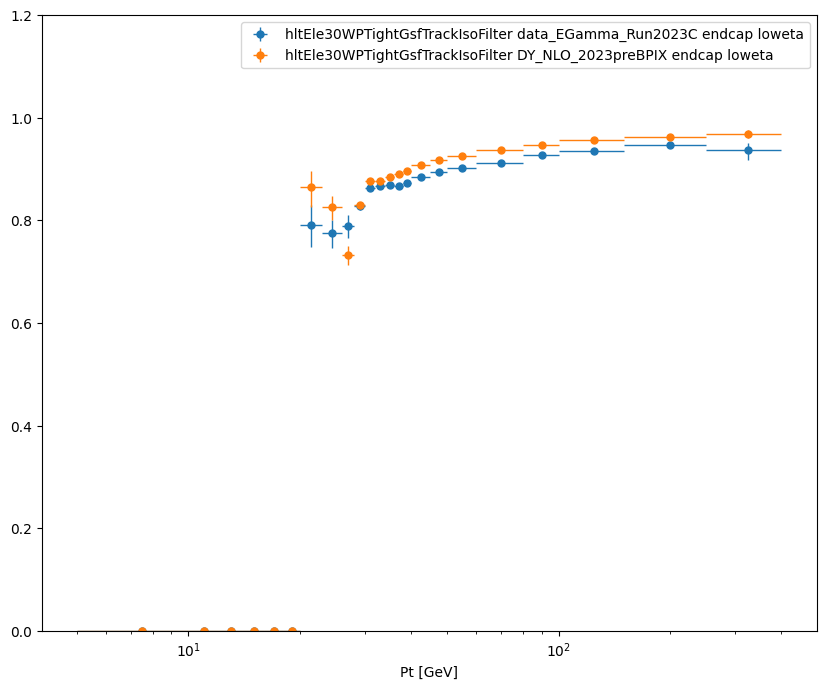

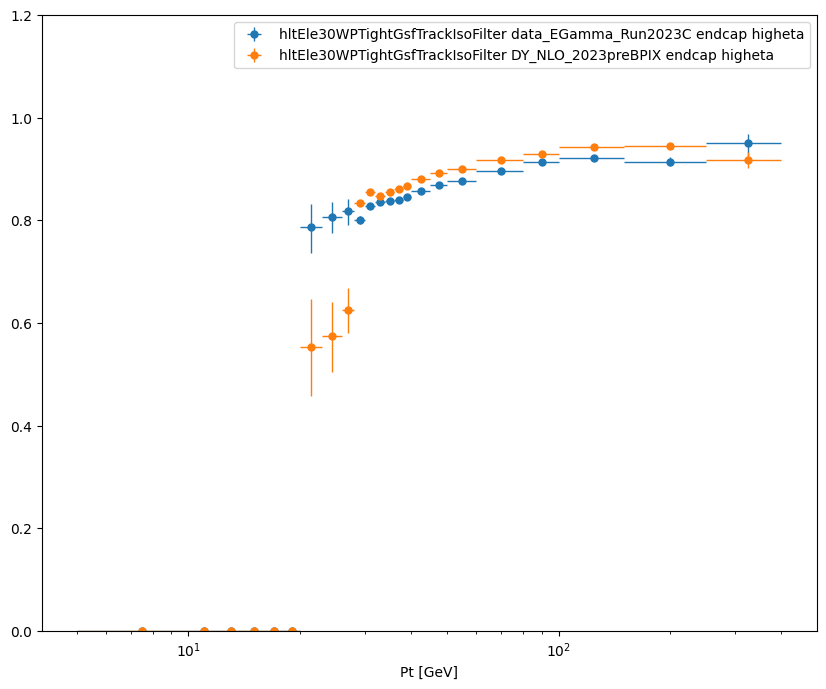

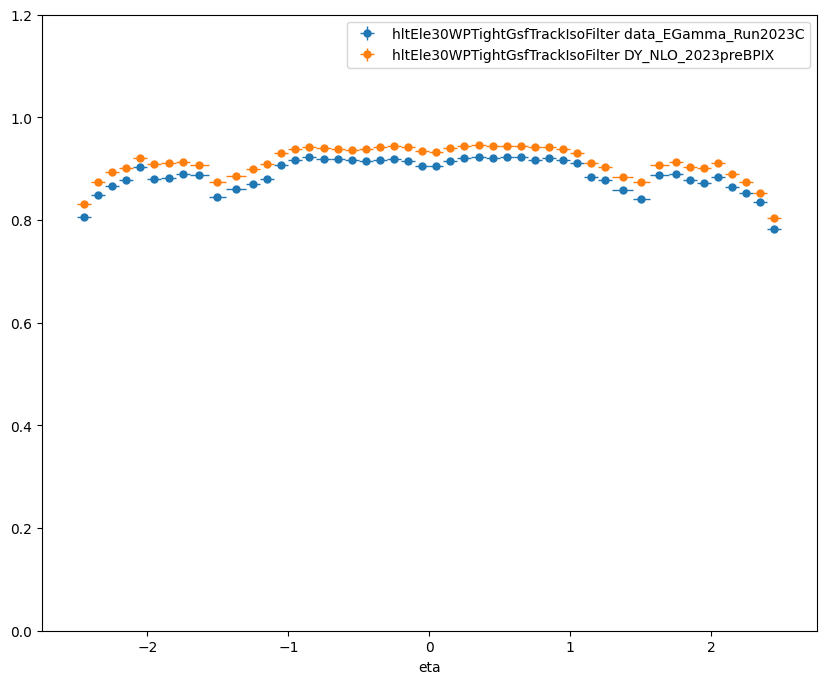

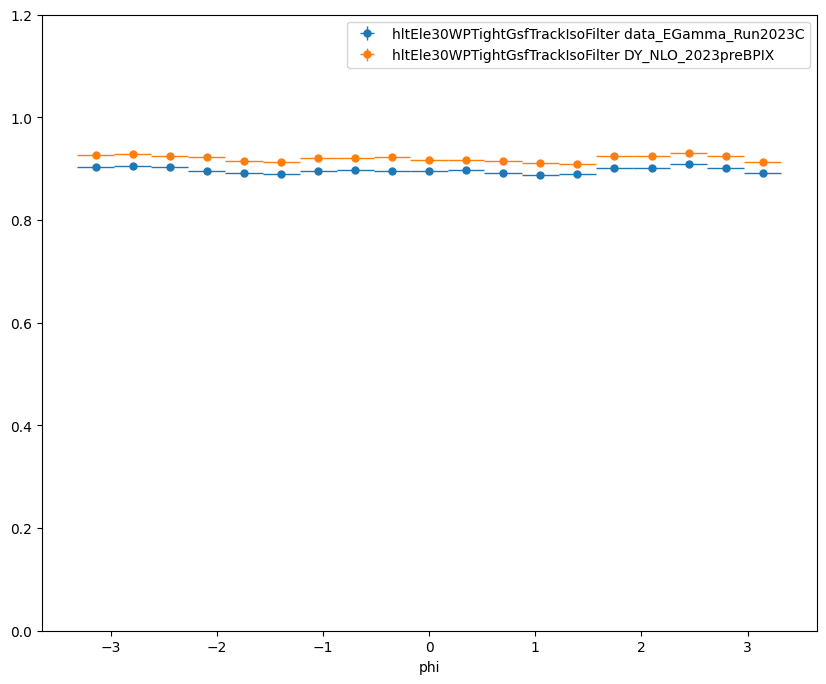

In [12]:
for filter in filters_to_check:
    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["barrel"]["passing"],
            hists["pt"]["barrel"]["failing"],
            label=f"{filter} {dataset} barrel",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["endcap_loweta"]["passing"],
            hists["pt"]["endcap_loweta"]["failing"],
            label=f"{filter} {dataset} endcap loweta",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["endcap_higheta"]["passing"],
            hists["pt"]["endcap_higheta"]["failing"],
            label=f"{filter} {dataset} endcap higheta",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["eta"]["entire"]["passing"],
            hists["eta"]["entire"]["failing"],
            label=f"{filter} {dataset}",
        )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["phi"]["entire"]["passing"],
            hists["phi"]["entire"]["failing"],
            label=f"{filter} {dataset}",
        )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()

In [13]:
fileset = {
    "data_EGamma_Run2023D": {"files": {"tnptuples/data_EGamma_Run2023D.root": "tnpEleTrig/fitter_tree"}},
    "DY_NLO_2023postBPIX": {
        "files": {"tnptuples/mc_DY_NLO_2023postBPIX.root": "tnpEleTrig/fitter_tree"},
        "metadata": {"isMC": True, "pileupJSON": "jsonpog-integration/POG/LUM/2023_Summer23BPix/puWeights.json.gz"},
    },
}

fileset_available, fileset_updates = preprocess(fileset, skip_bad_files=True, step_size=500_000)

In [14]:
egamma_tnp.config.set(
    "pt_bins",
    [
        5,
        10,
        12,
        14,
        16,
        18,
        20,
        23,
        26,
        28,
        30,
        32,
        34,
        36,
        38,
        40,
        45,
        50,
        60,
        80,
        100,
        150,
        250,
        400,
    ],
)

to_compute = {}


def myfilter(events):
    return events[events.passHLTEG30L1SingleEGOrEtFilter == 1]


for filter in filters_to_check:
    tnp = ElectronTagNProbeFromNTuples(
        fileset_available,
        [f"pass{filter.replace('hlt', 'HLT')}"],
        use_sc_eta=False,
        probes_pt_cut=20,
        cutbased_id="passingCutBasedTight122XV1",
        extra_filter=myfilter,
    )
    to_compute[filter] = tnp.get_1d_pt_eta_phi_tnp_histograms(
        f"pass{filter.replace('hlt', 'HLT')}",
        vars=["el_pt", "el_sc_eta", "el_sc_phi"],
        eta_regions_pt={
            "barrel": [0.0, 1.4442],
            "endcap_loweta": [1.566, 2.0],
            "endcap_higheta": [2.0, 2.5],
        },
        plateau_cut=5,
        uproot_options={"allow_read_errors_with_report": False},
    )

dak.necessary_columns(to_compute)

{'from-uproot-16dd06b73f044d91d26f5018c2b97dc2': frozenset({'el_eta',
            'el_pt',
            'el_q',
            'el_sc_eta',
            'el_sc_phi',
            'pair_mass',
            'passHLTEG30L1SingleEGOrEtFilter',
            'passHLTEle30WPTightClusterShapeFilter',
            'passHLTEle30WPTightEcalIsoFilter',
            'passHLTEle30WPTightGsfDetaFilter',
            'passHLTEle30WPTightGsfDphiFilter',
            'passHLTEle30WPTightGsfMissingHitsFilter',
            'passHLTEle30WPTightGsfOneOEMinusOneOPFilter',
            'passHLTEle30WPTightGsfTrackIsoFilter',
            'passHLTEle30WPTightHEFilter',
            'passHLTEle30WPTightHcalIsoFilter',
            'passHLTEle30WPTightPMS2Filter',
            'passHLTEle30WPTightPixelMatchFilter',
            'passingCutBasedTight122XV1',
            'tag_Ele_eta',
            'tag_Ele_pt',
            'tag_Ele_q'}),
 'from-uproot-c9342a6e02fb94e13b78253cf460cf01': frozenset({'el_eta',
            'el_pt',
    

In [15]:
%%time

out = dask.compute(to_compute)[0]

CPU times: user 18.7 s, sys: 971 ms, total: 19.7 s
Wall time: 24.6 s


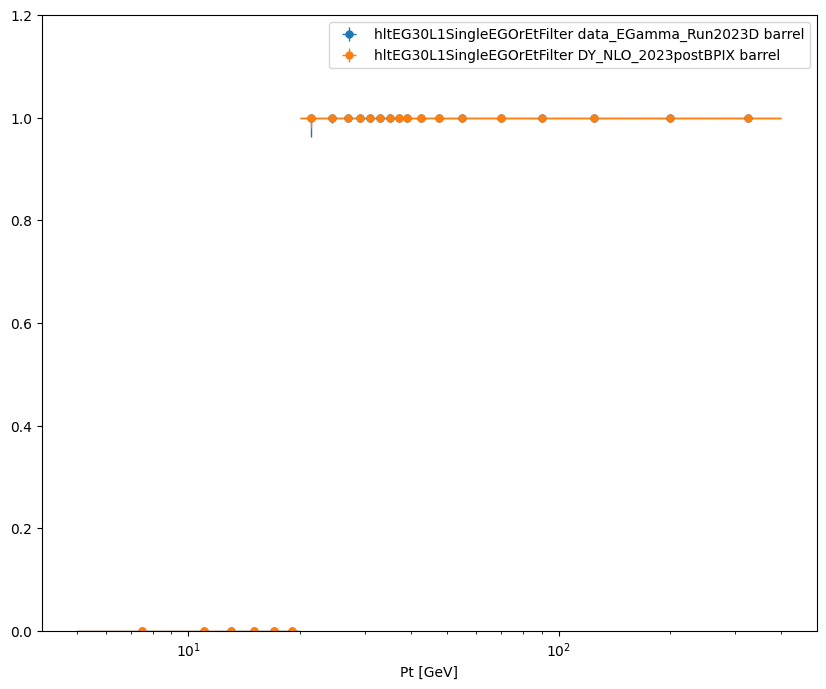

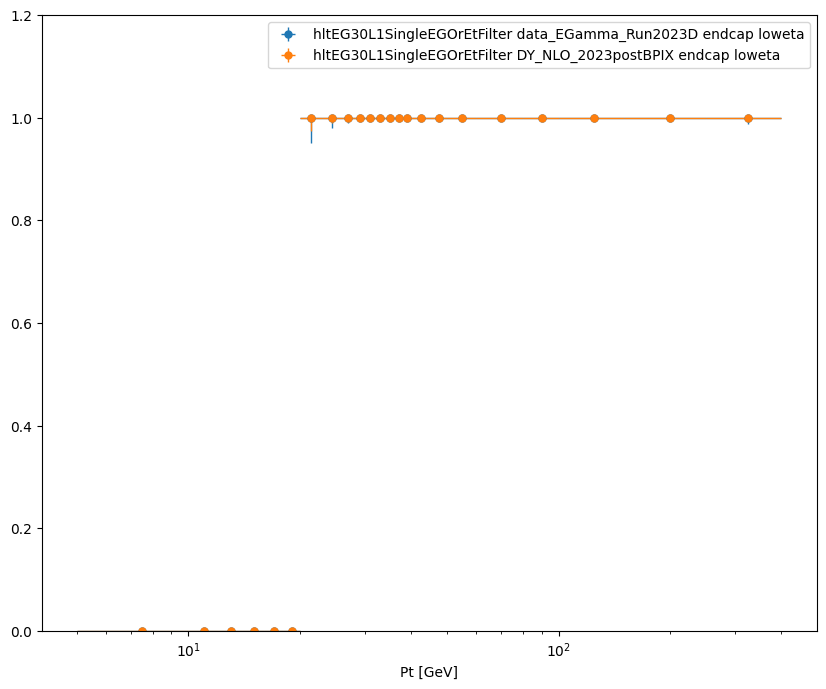

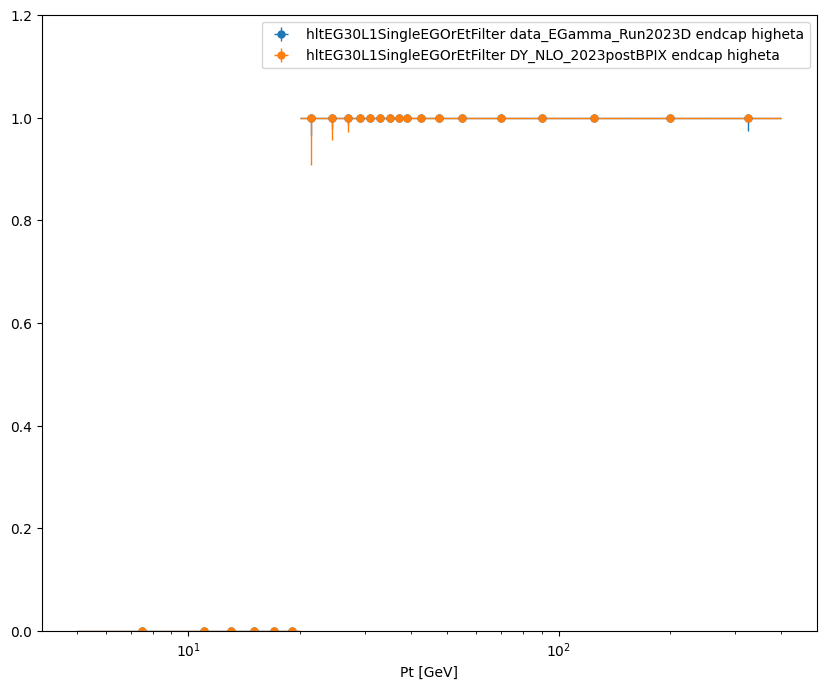

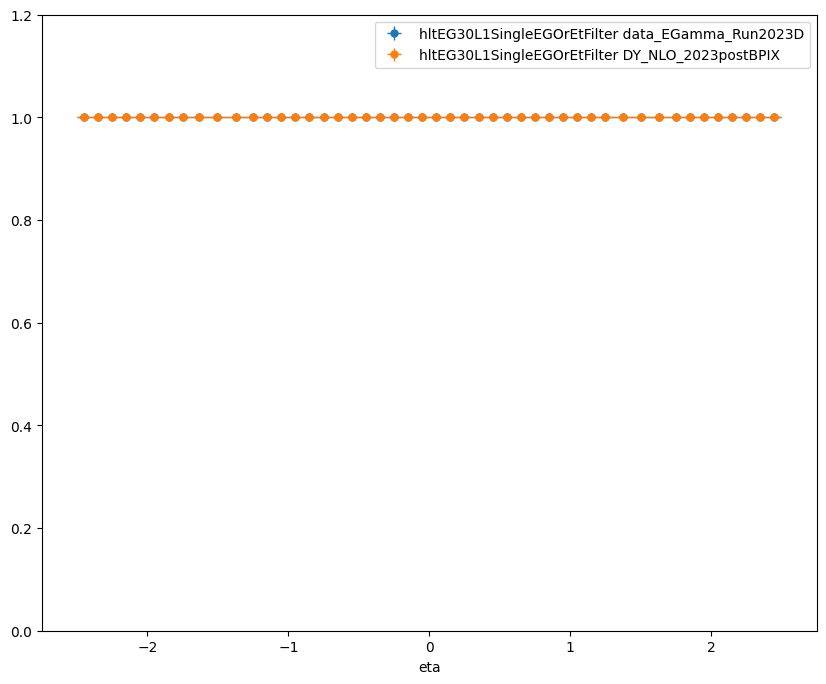

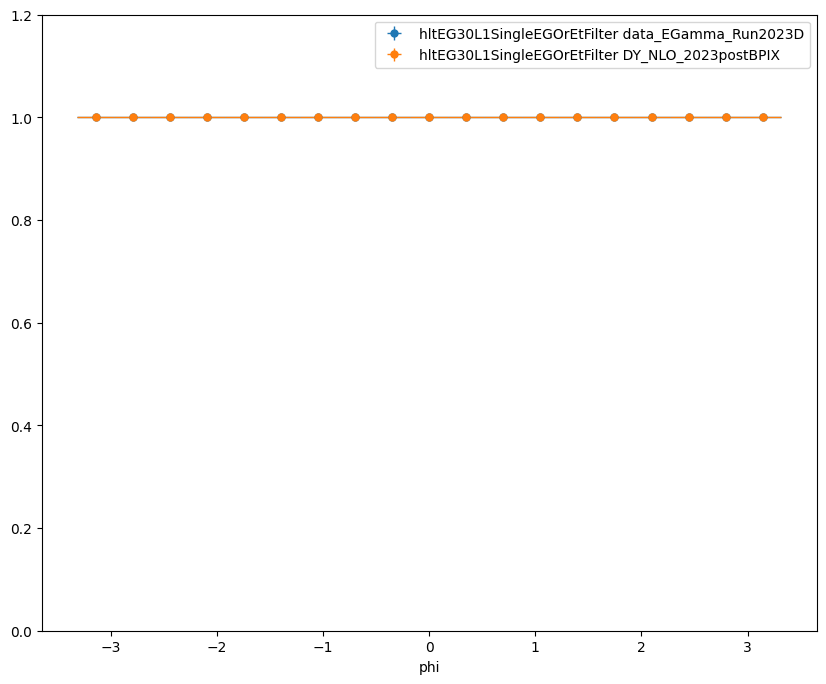

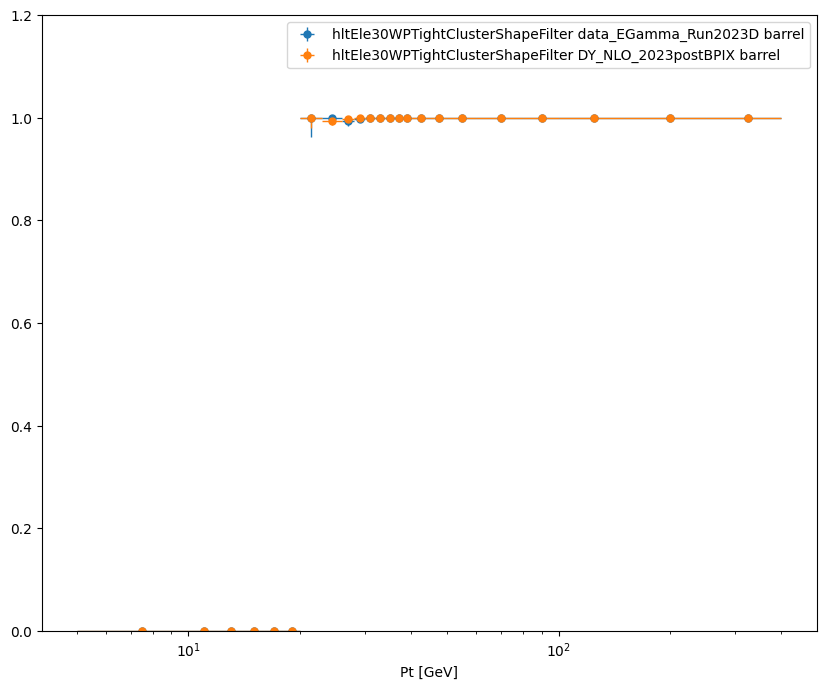

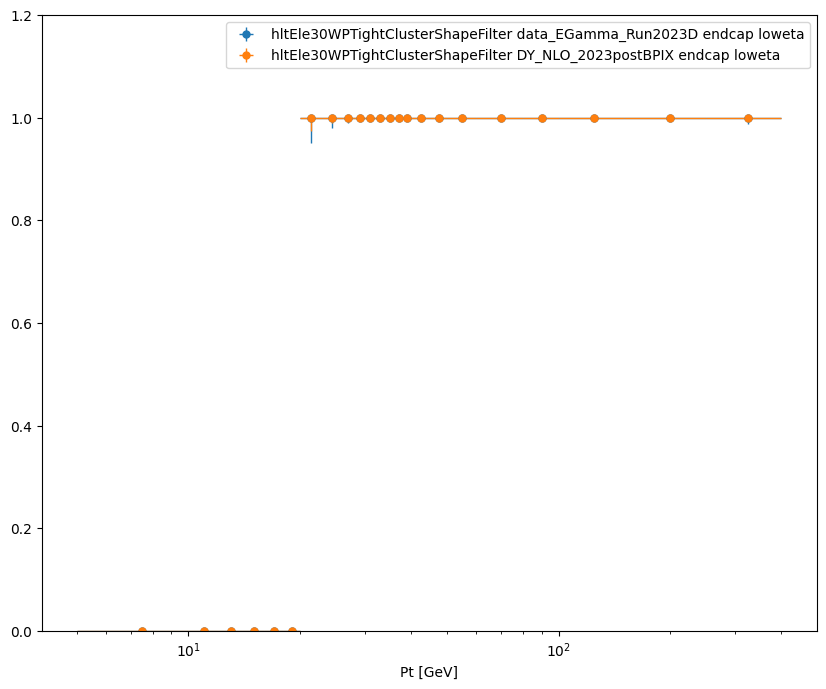

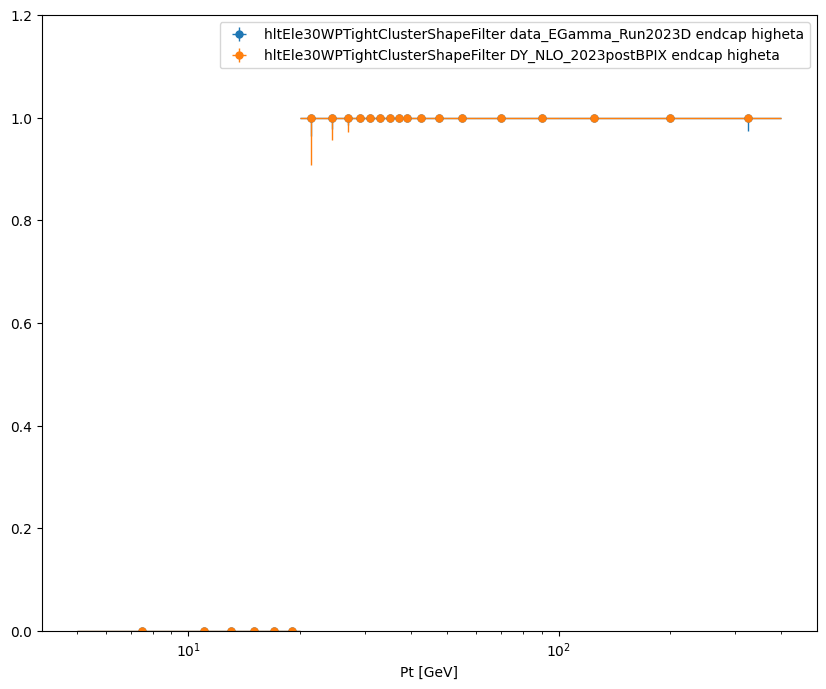

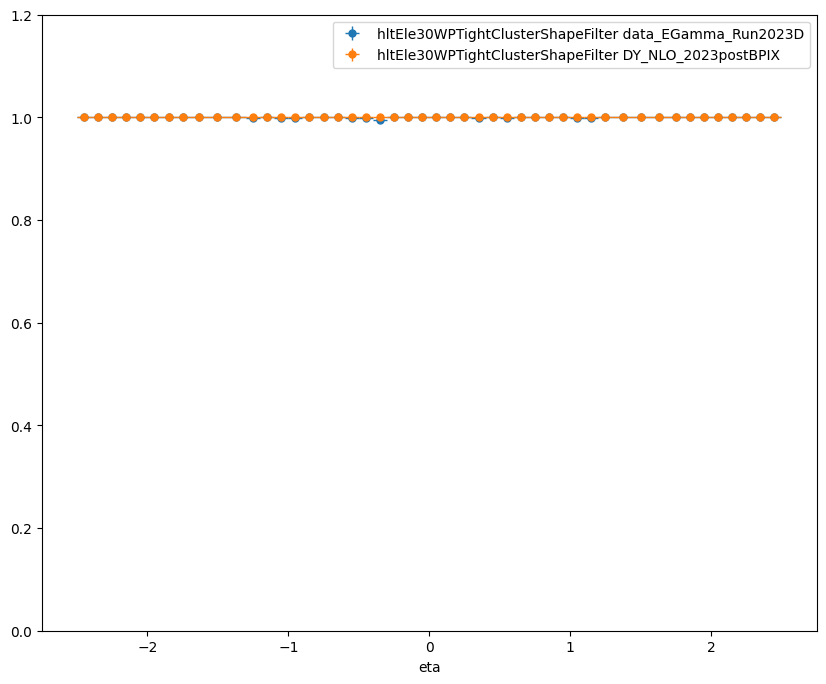

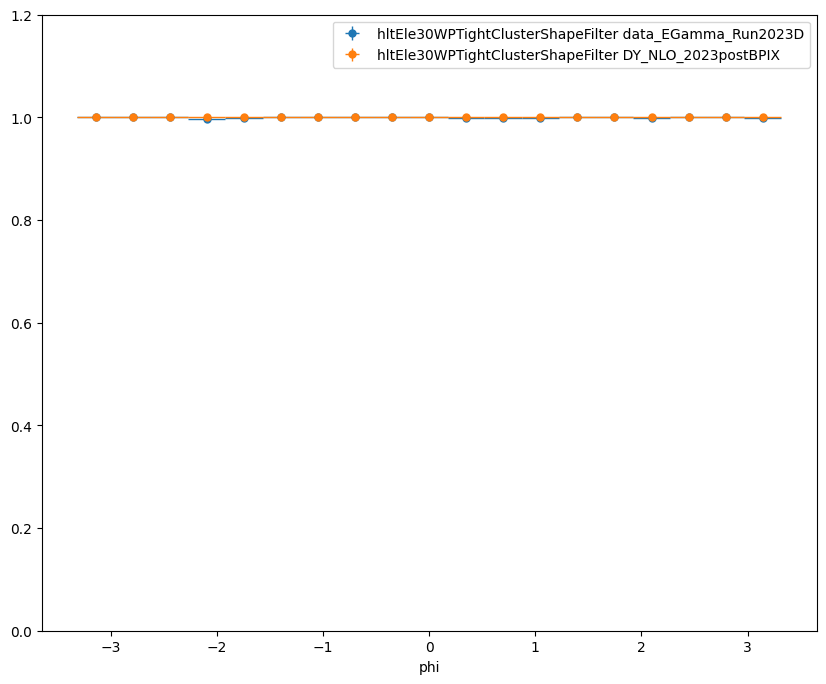

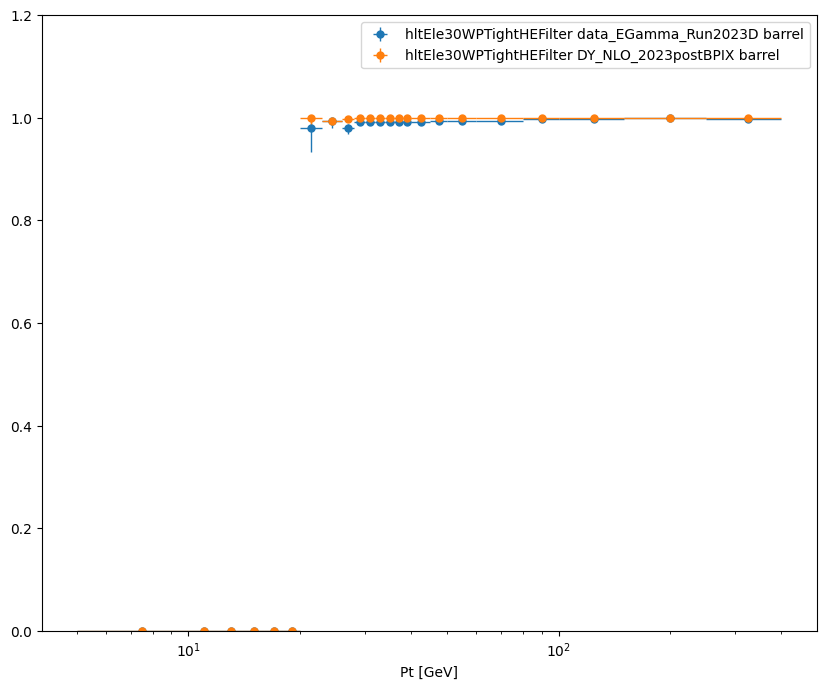

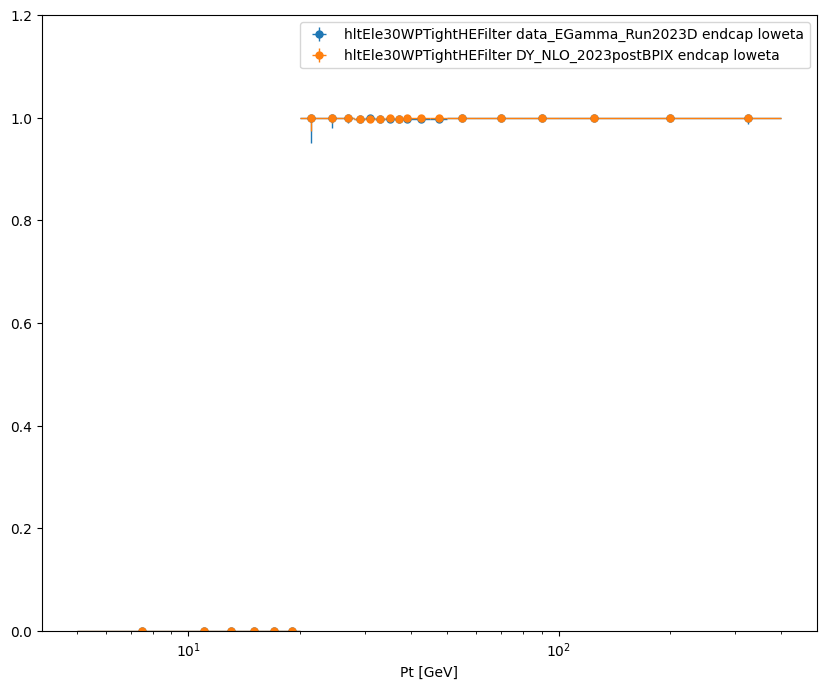

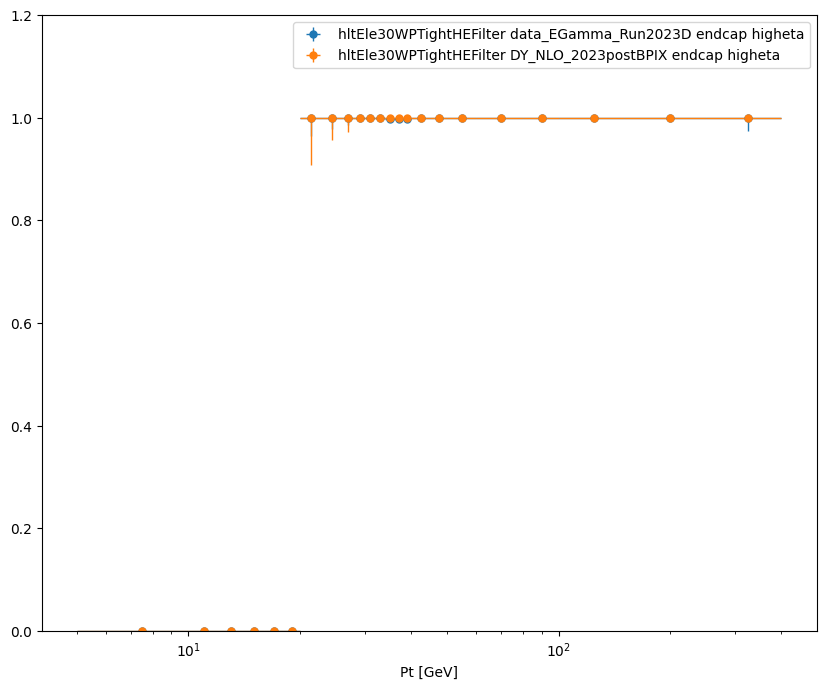

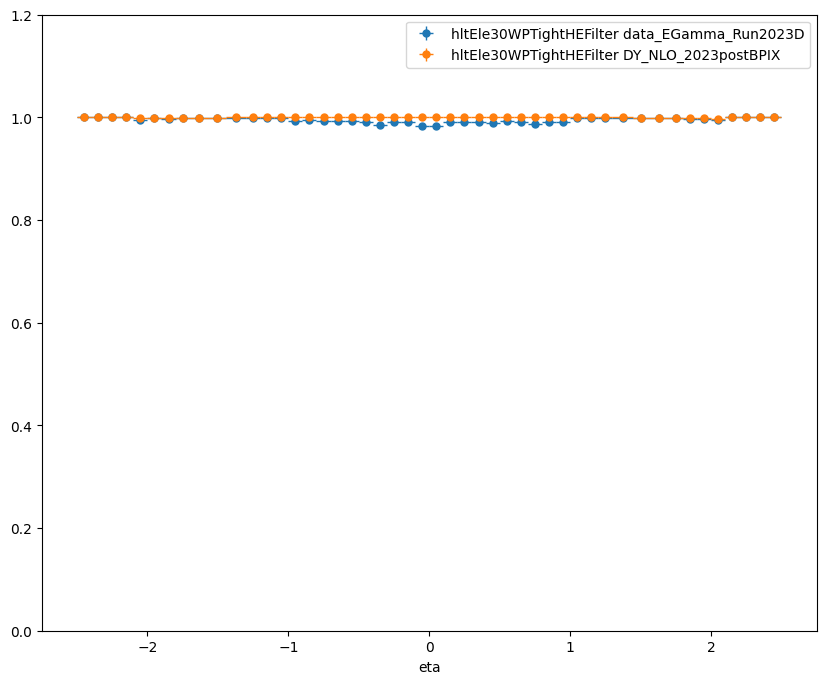

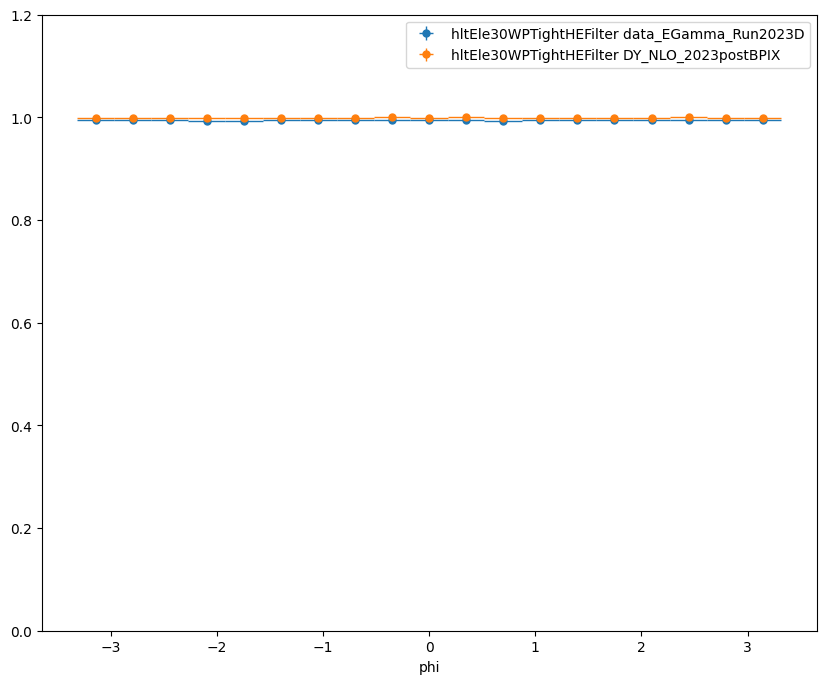

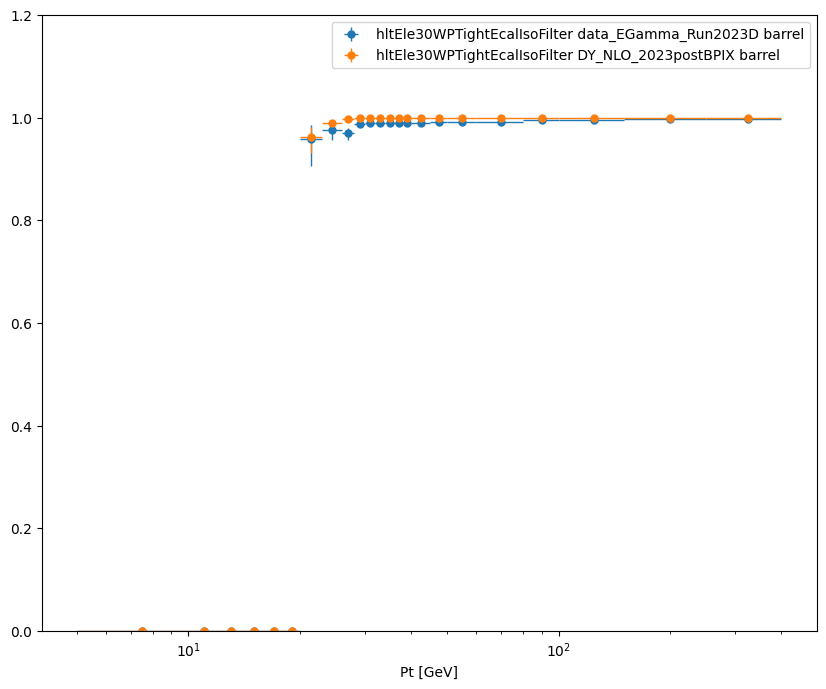

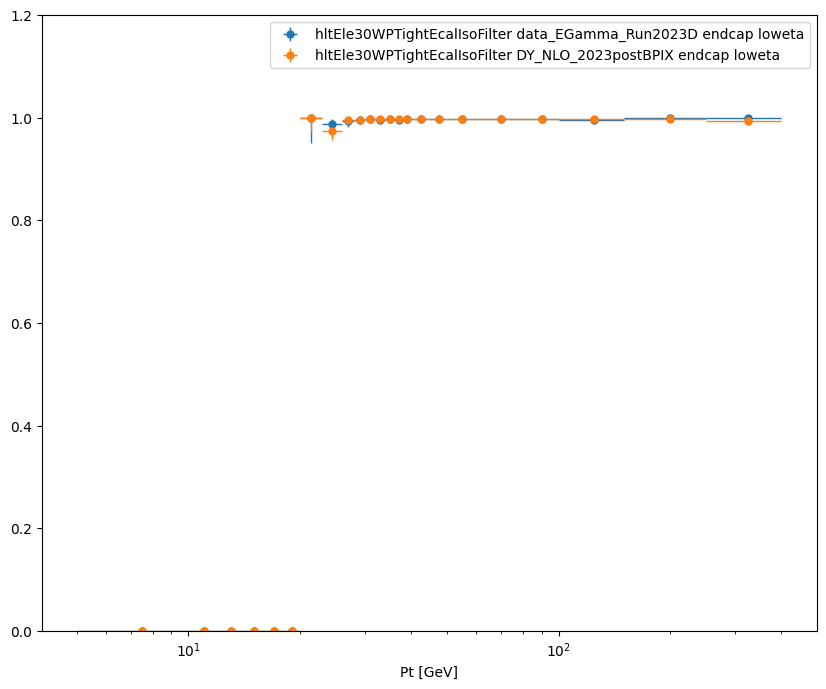

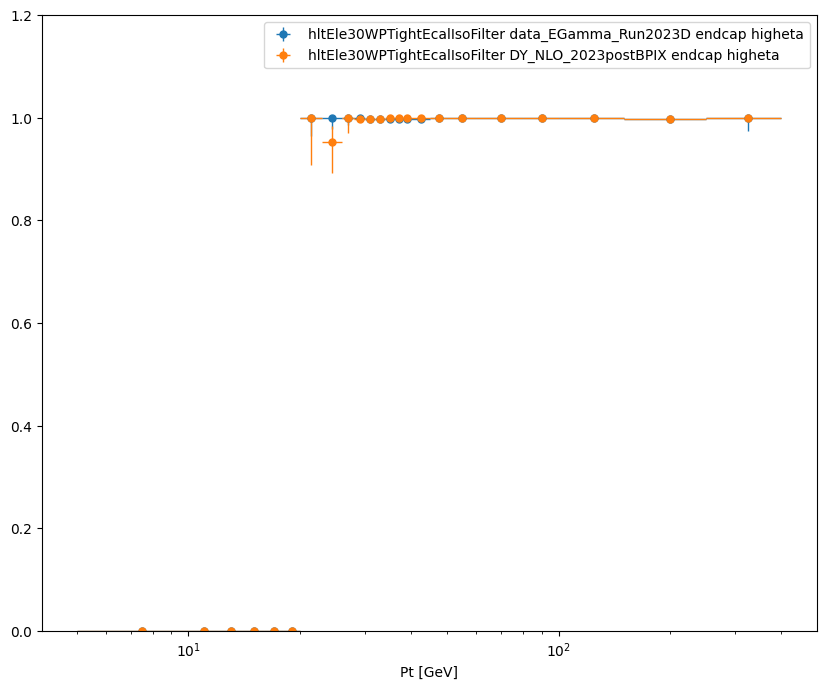

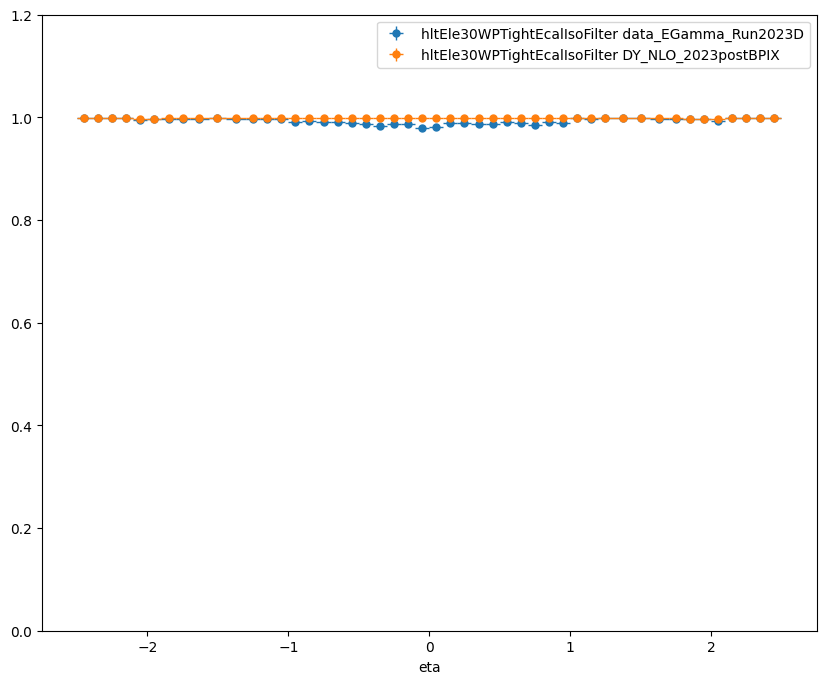

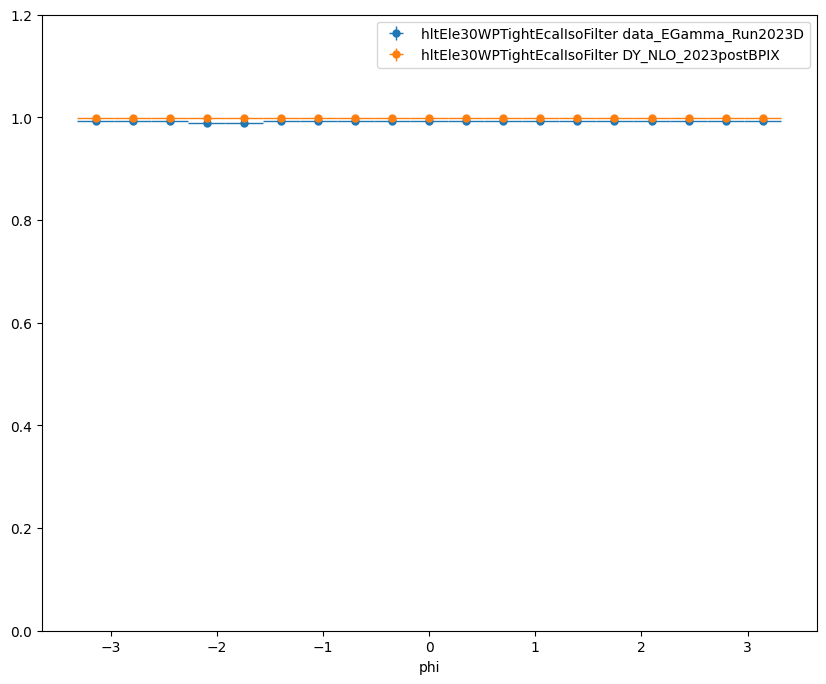

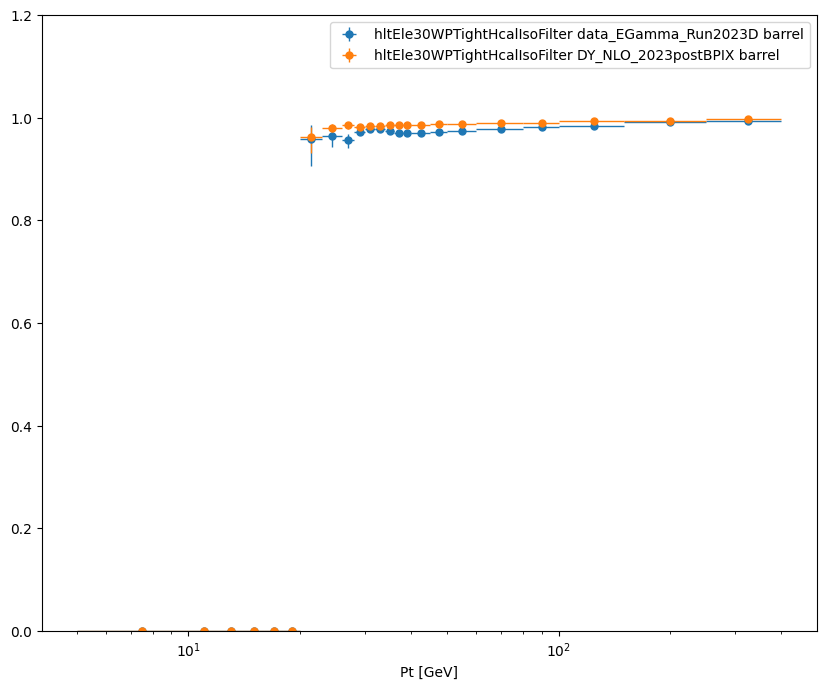

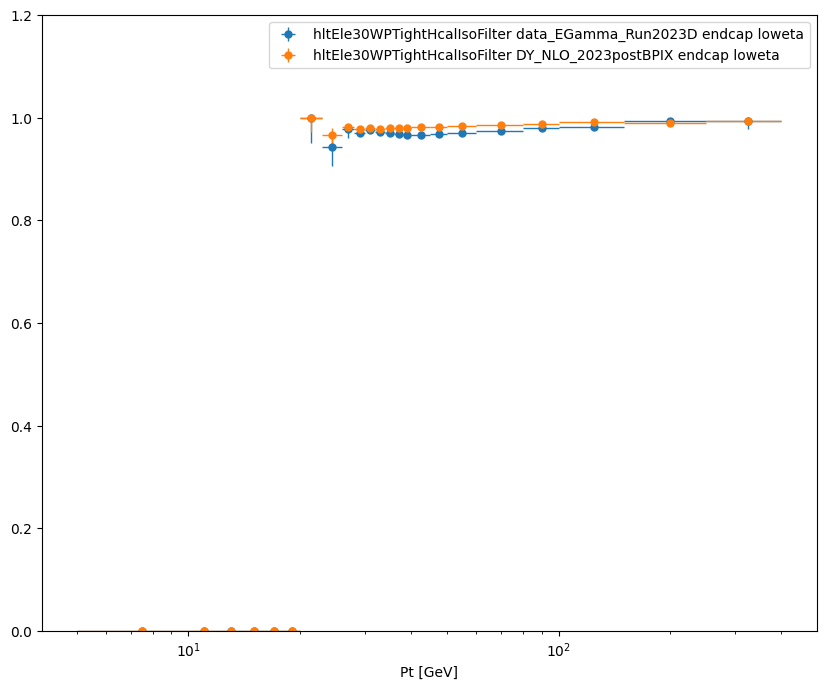

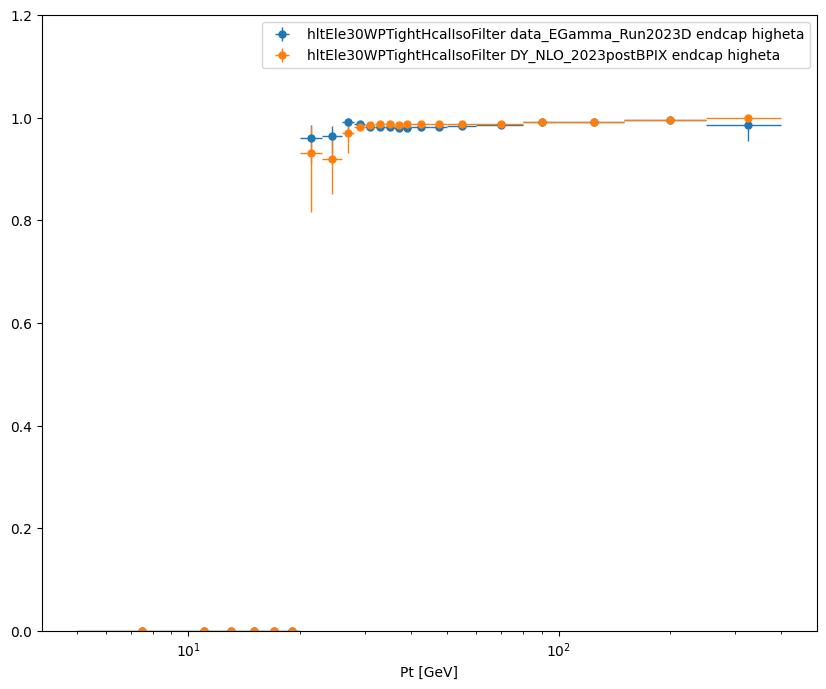

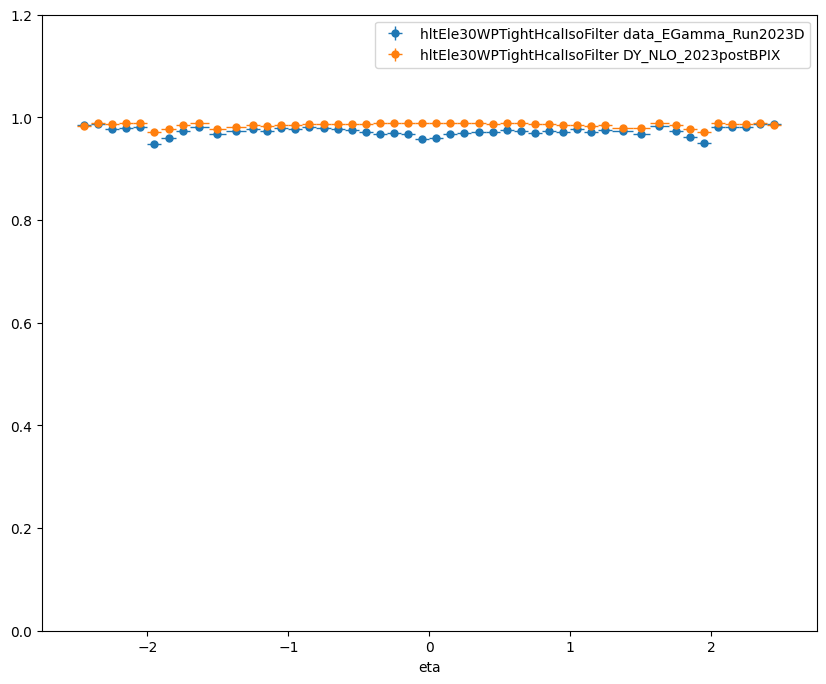

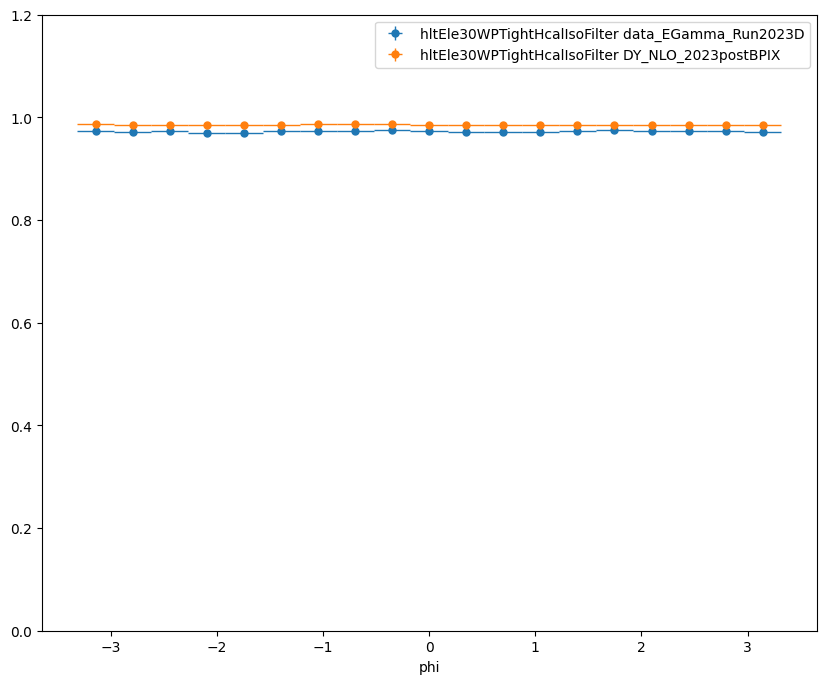

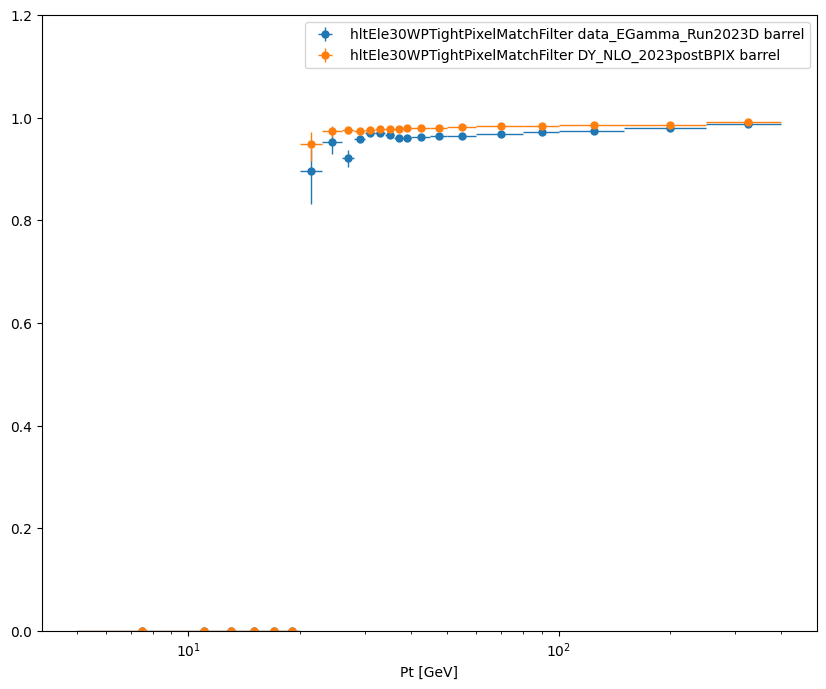

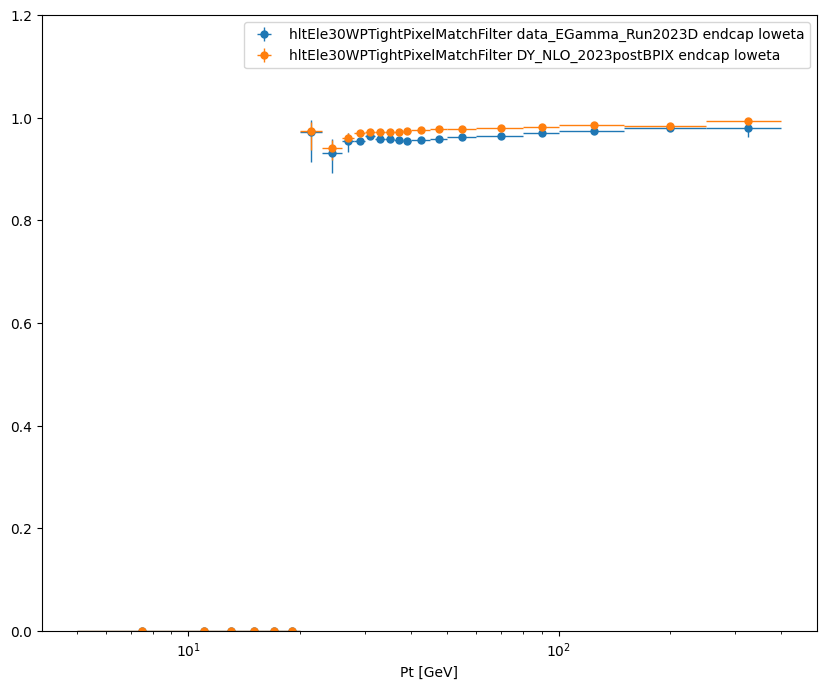

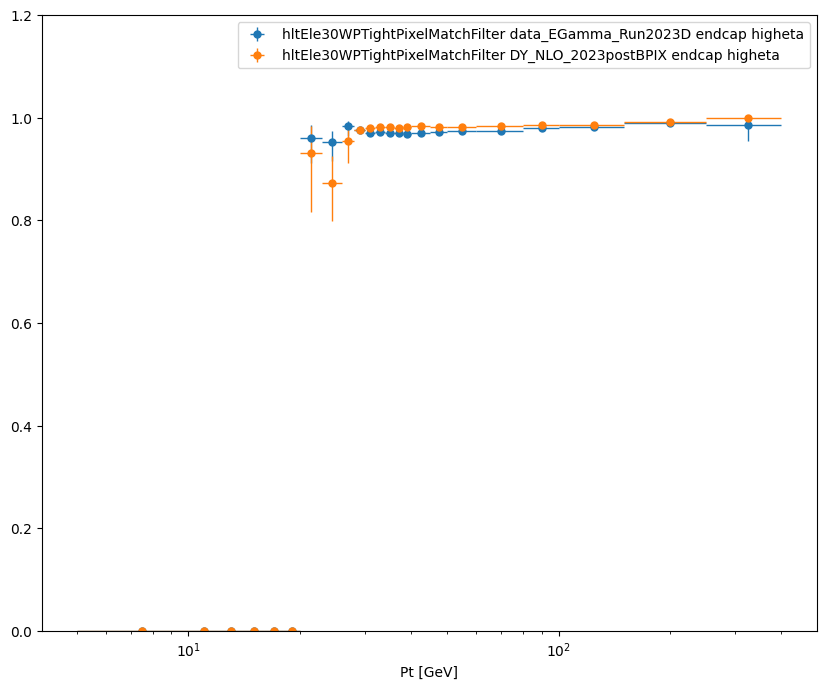

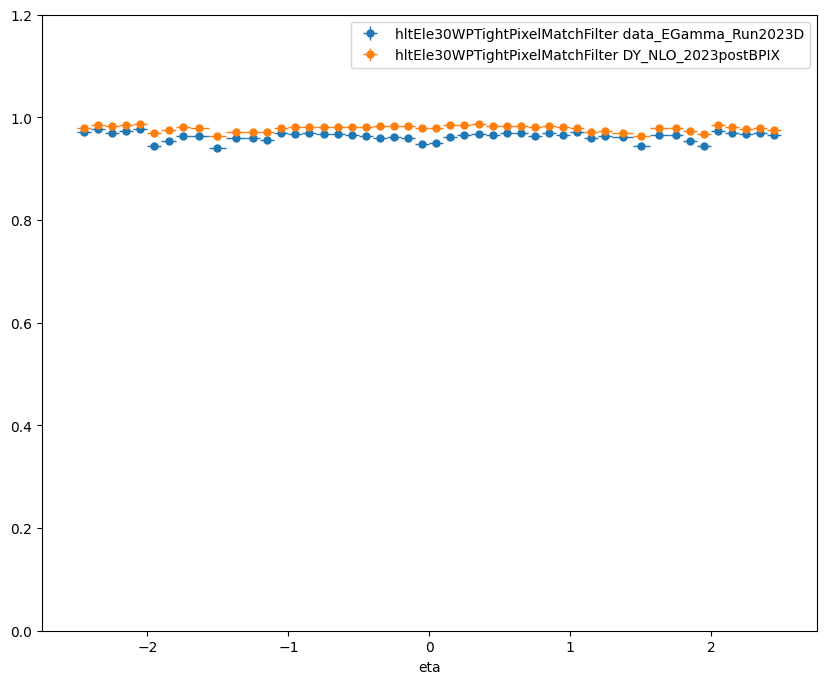

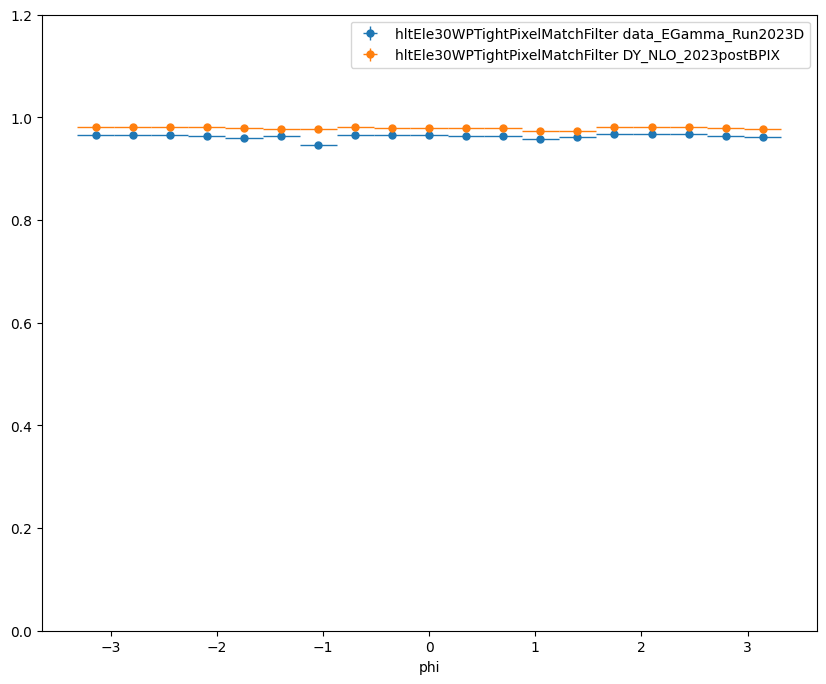

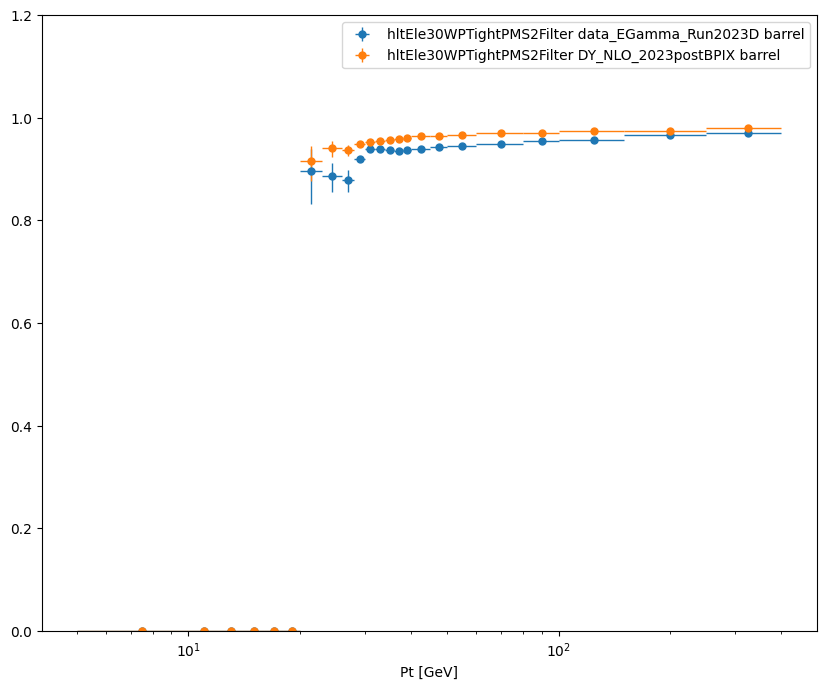

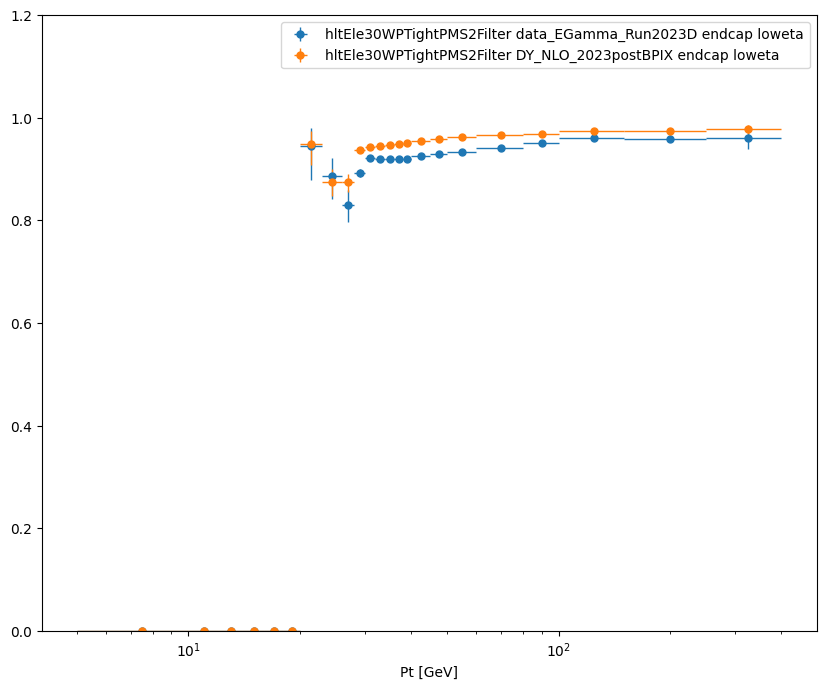

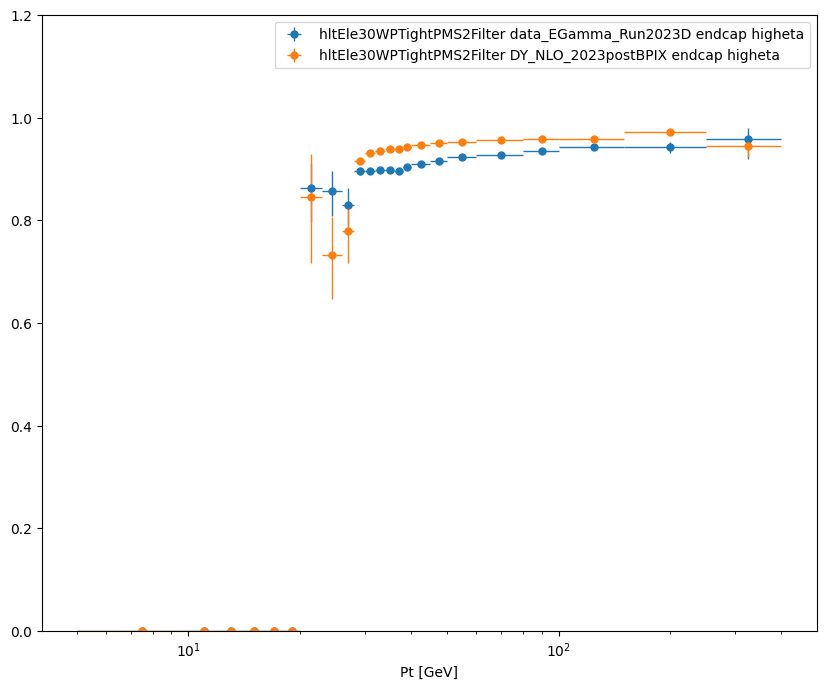

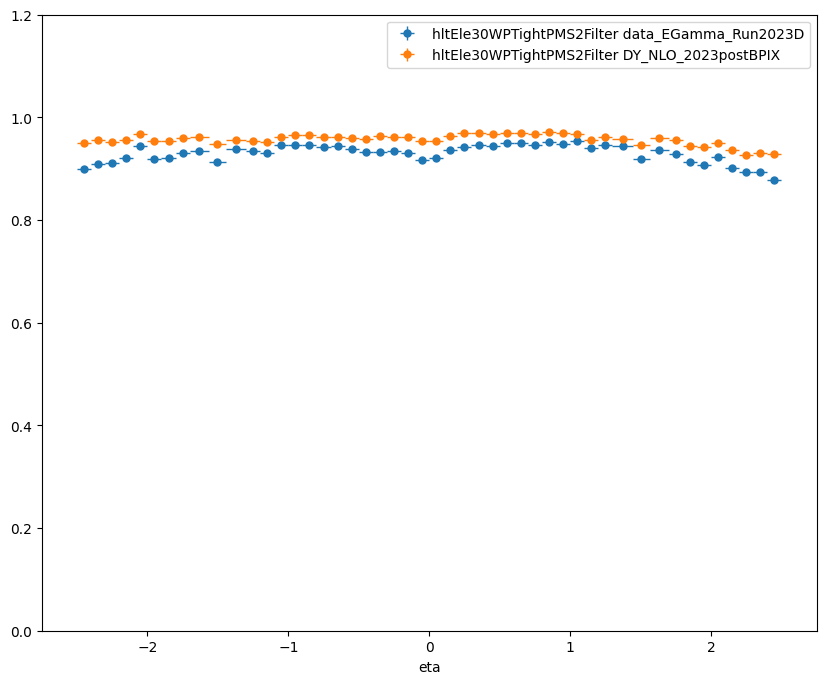

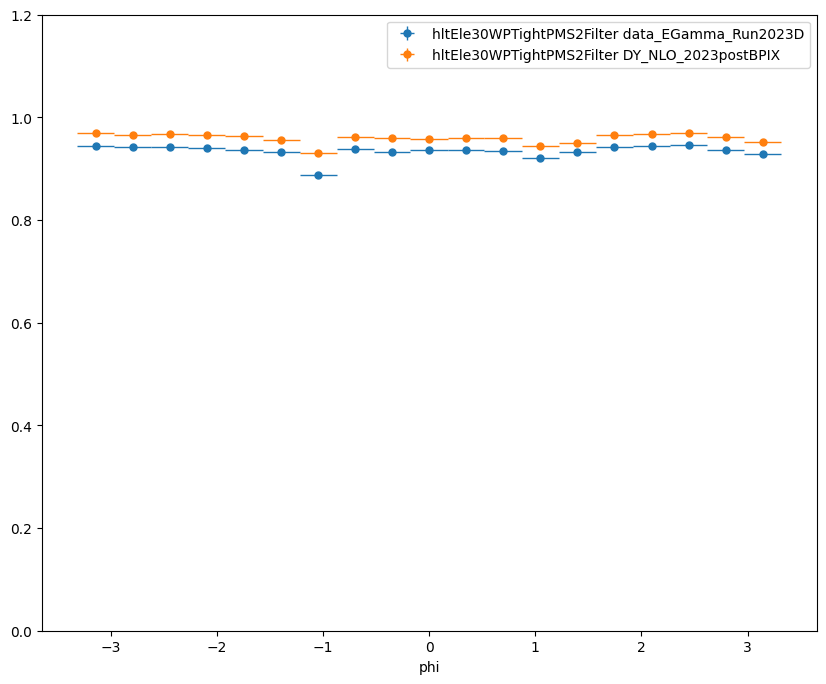

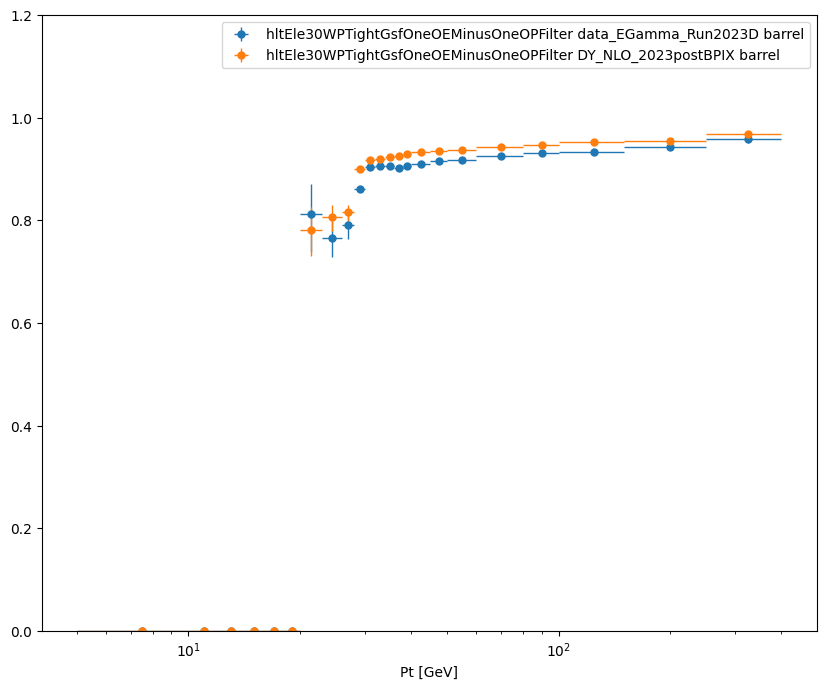

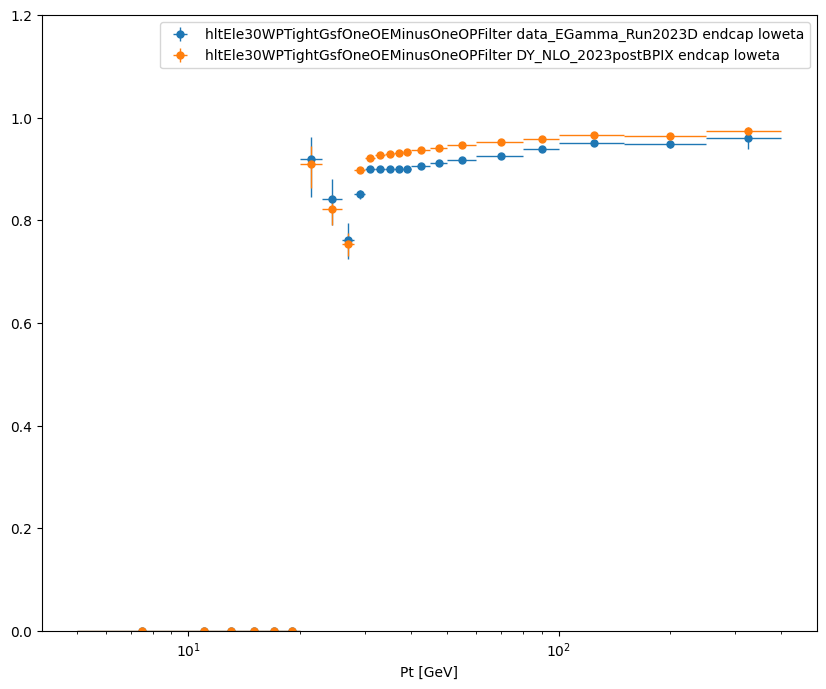

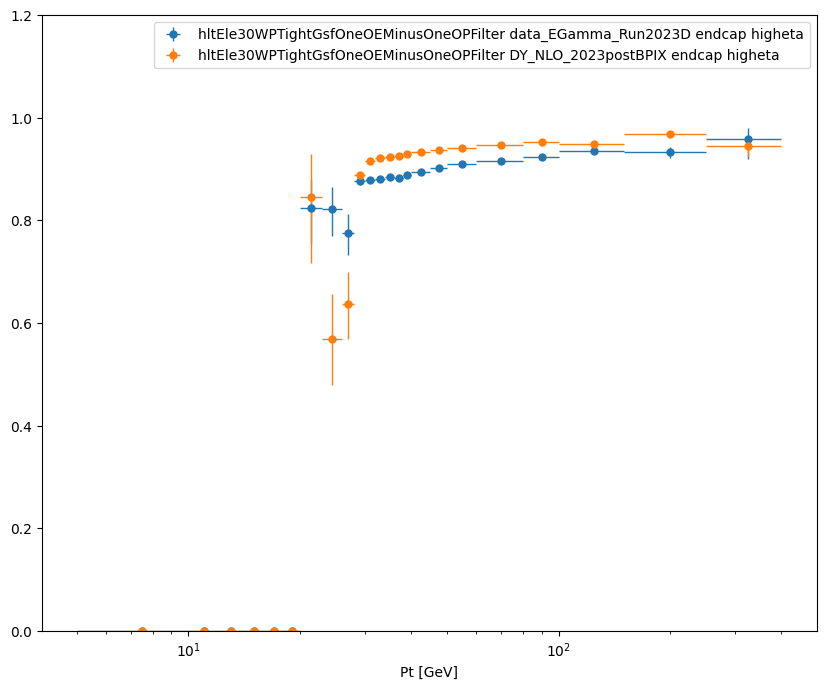

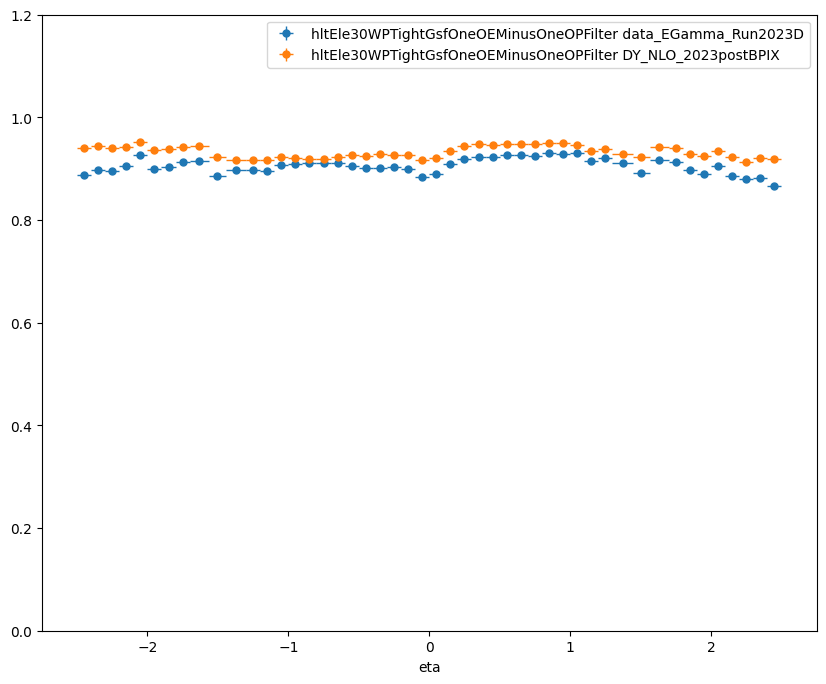

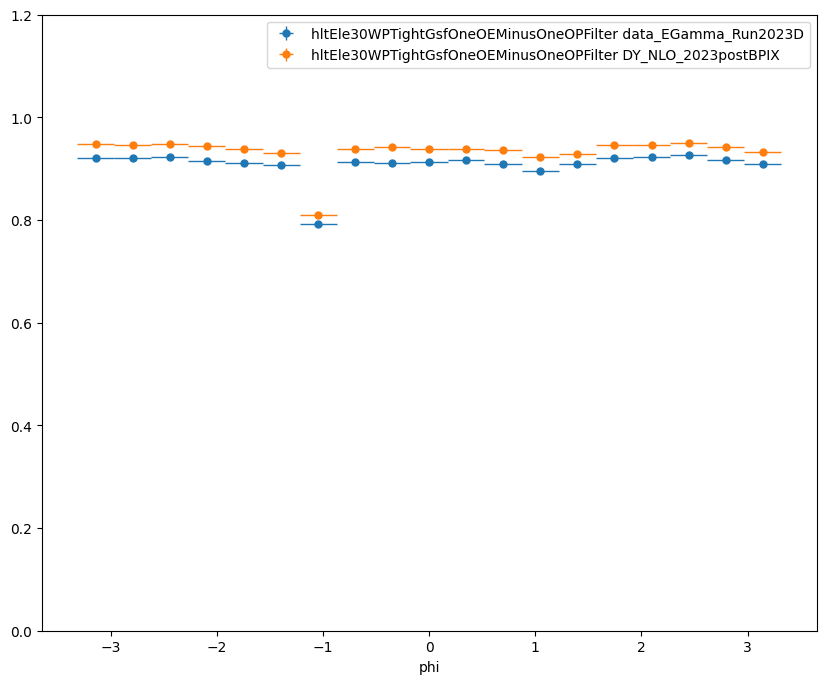

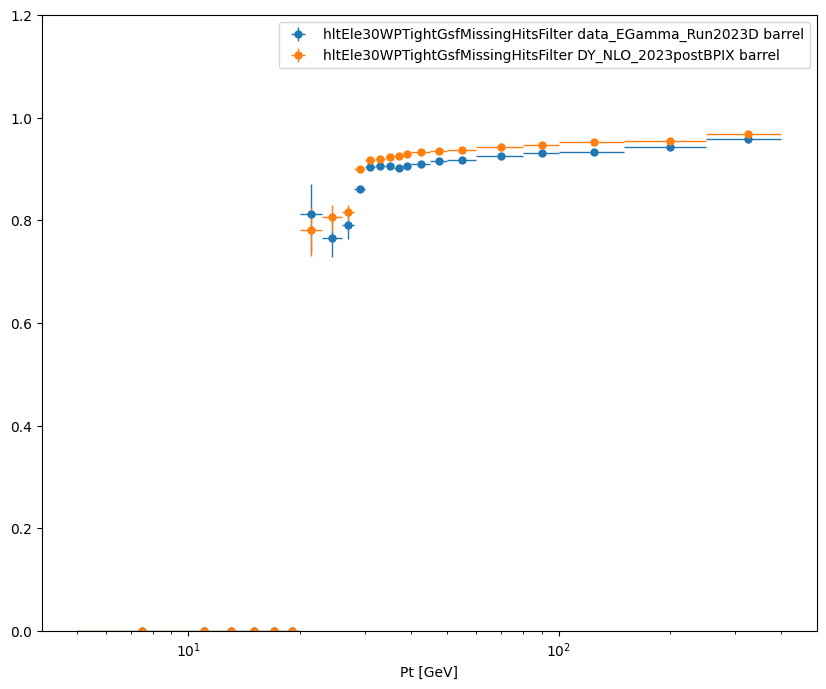

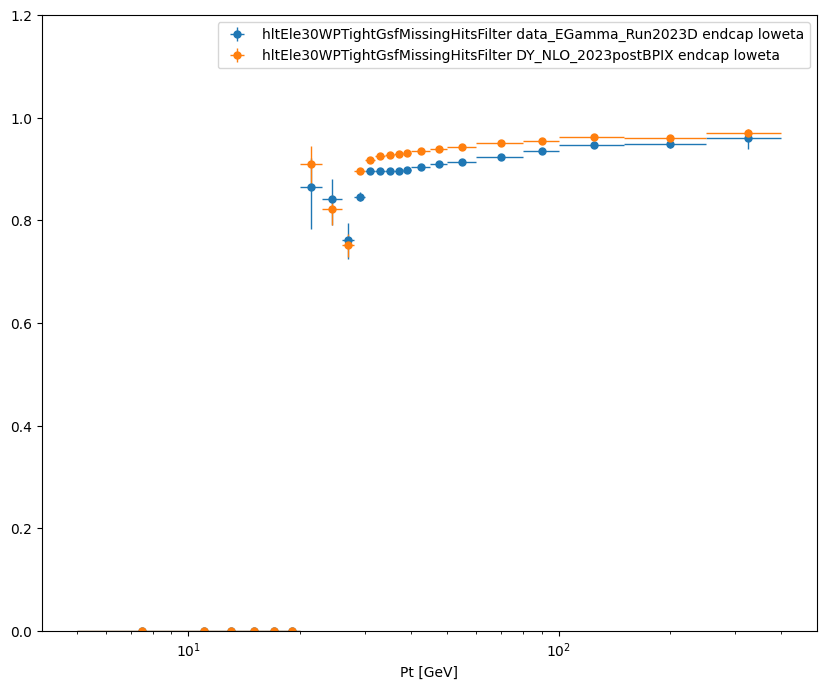

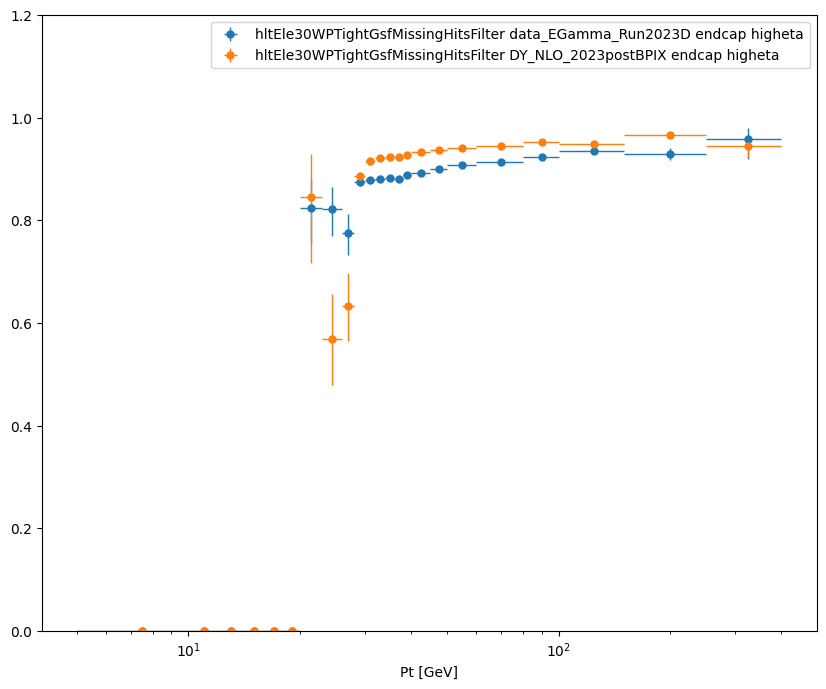

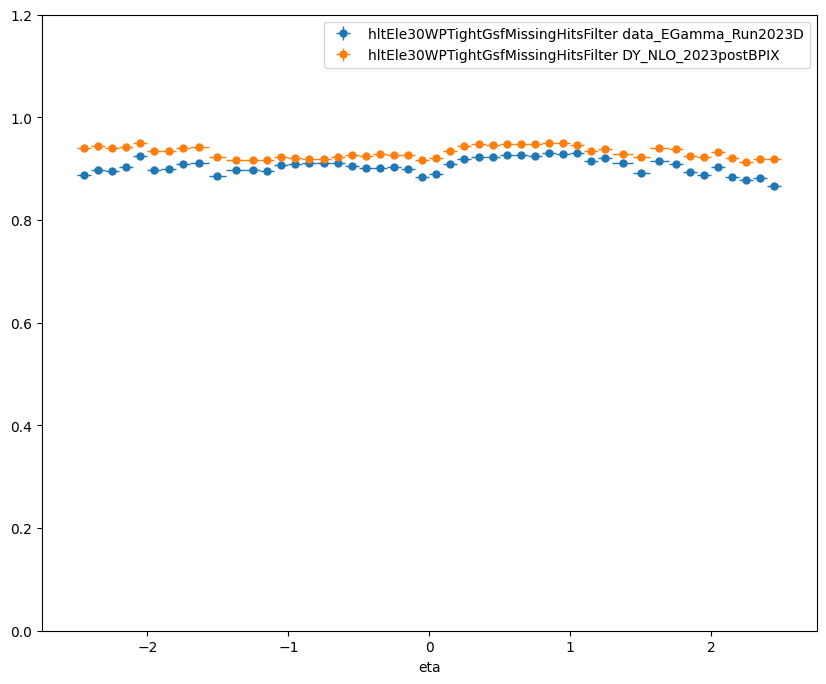

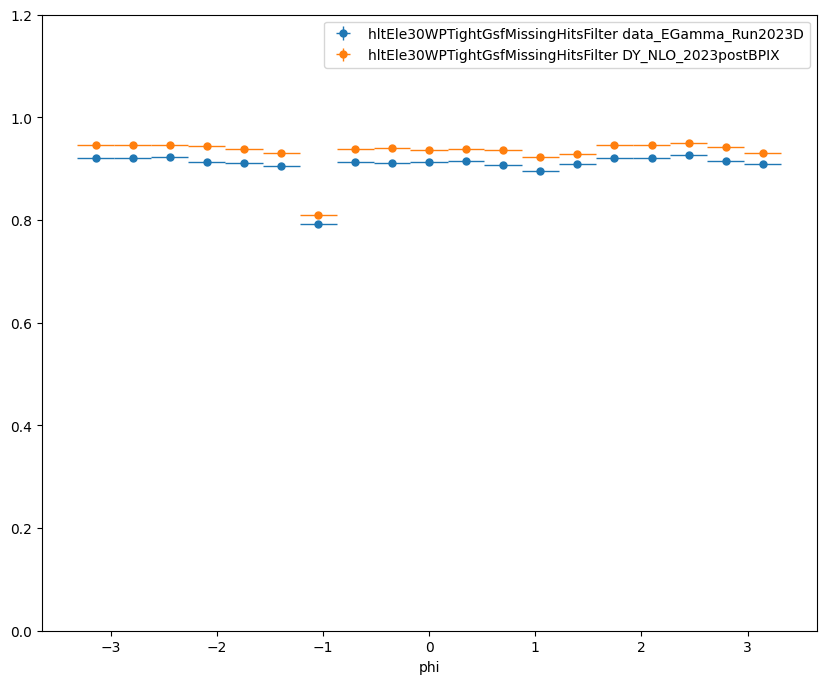

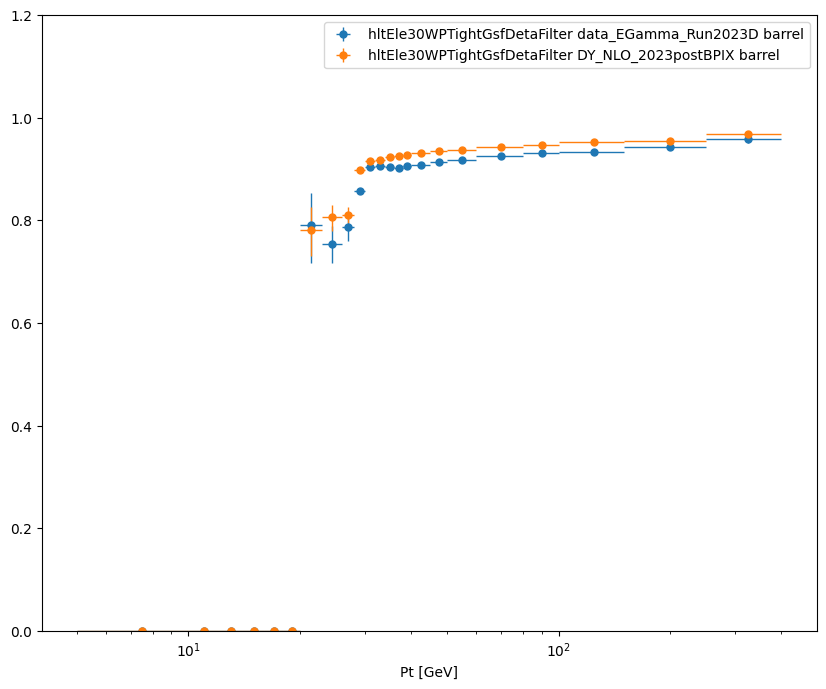

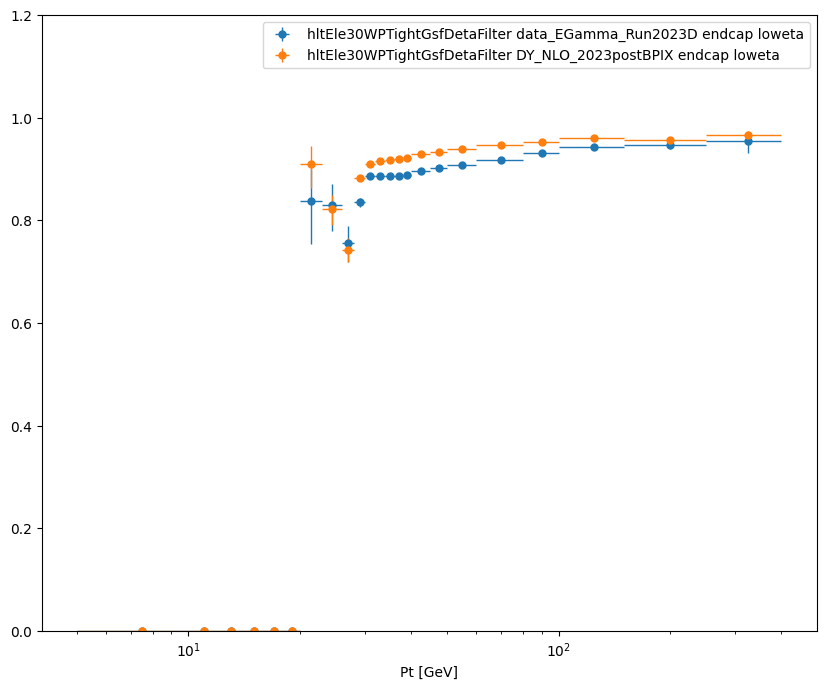

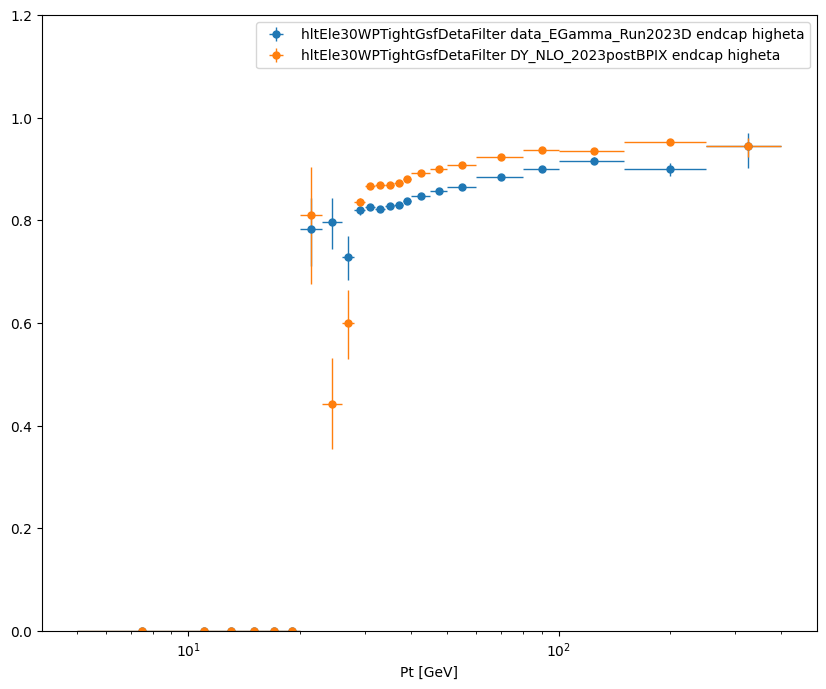

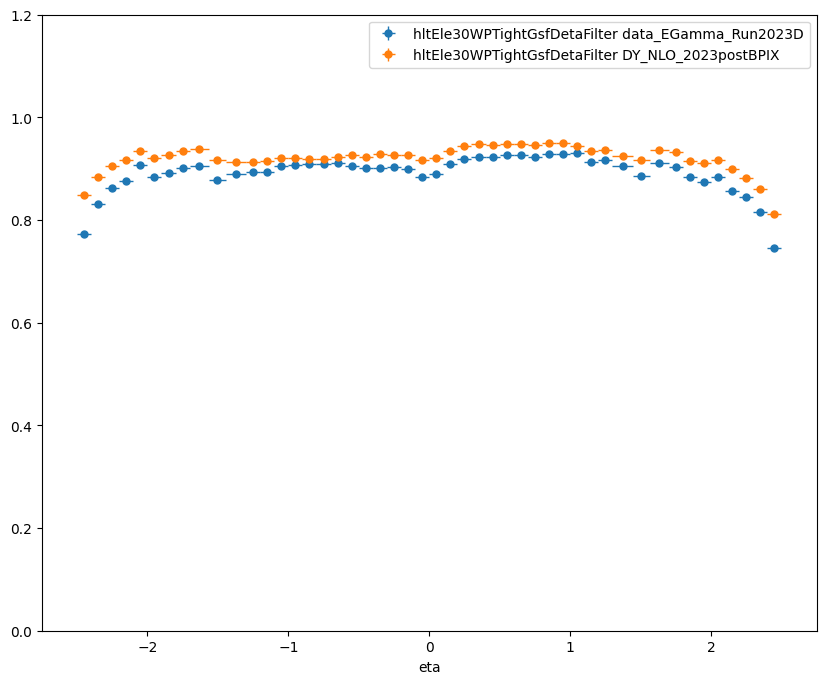

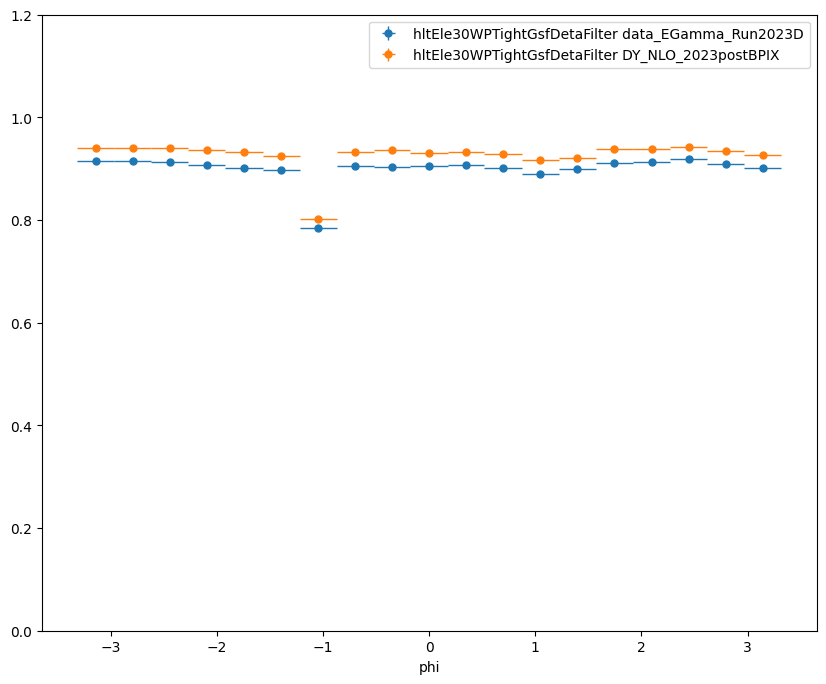

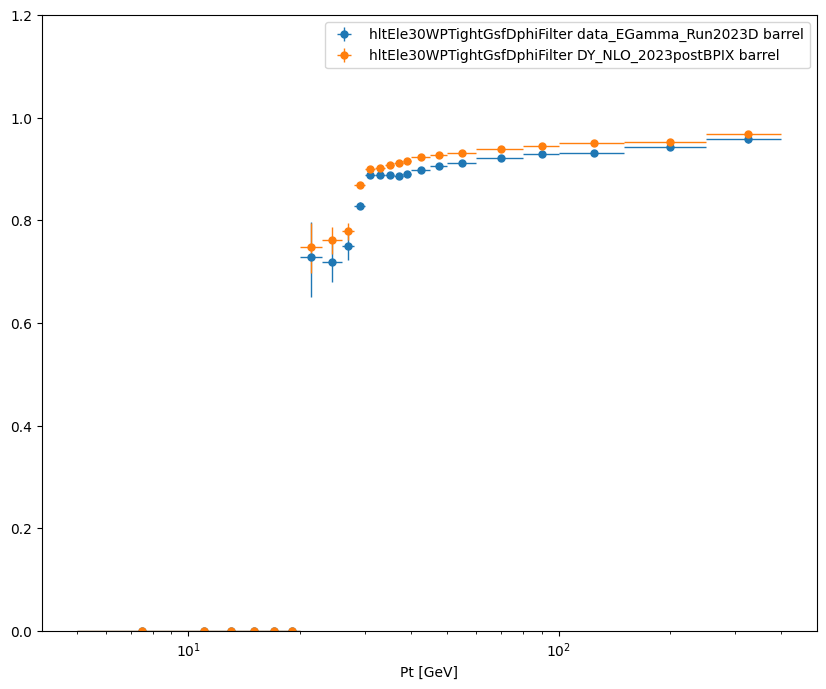

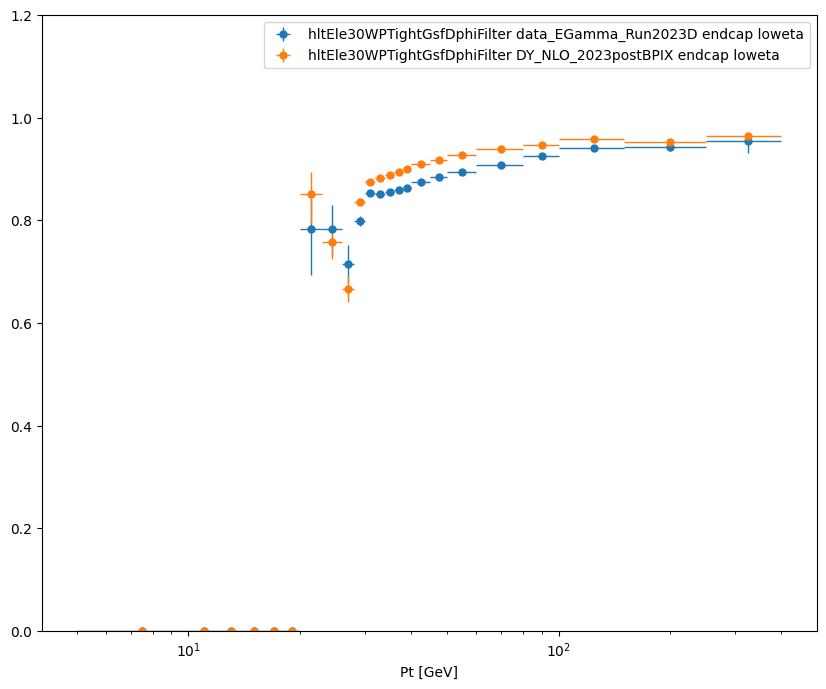

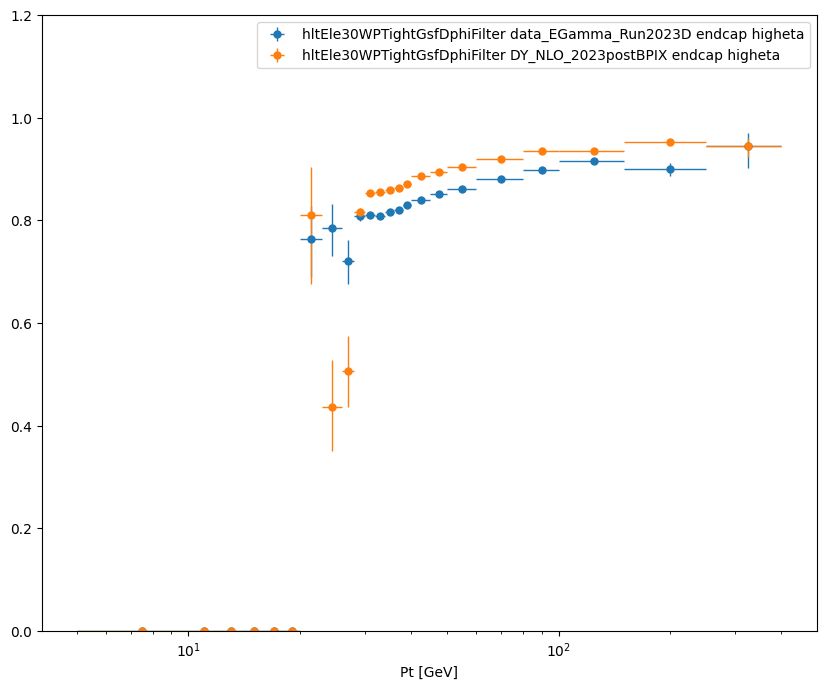

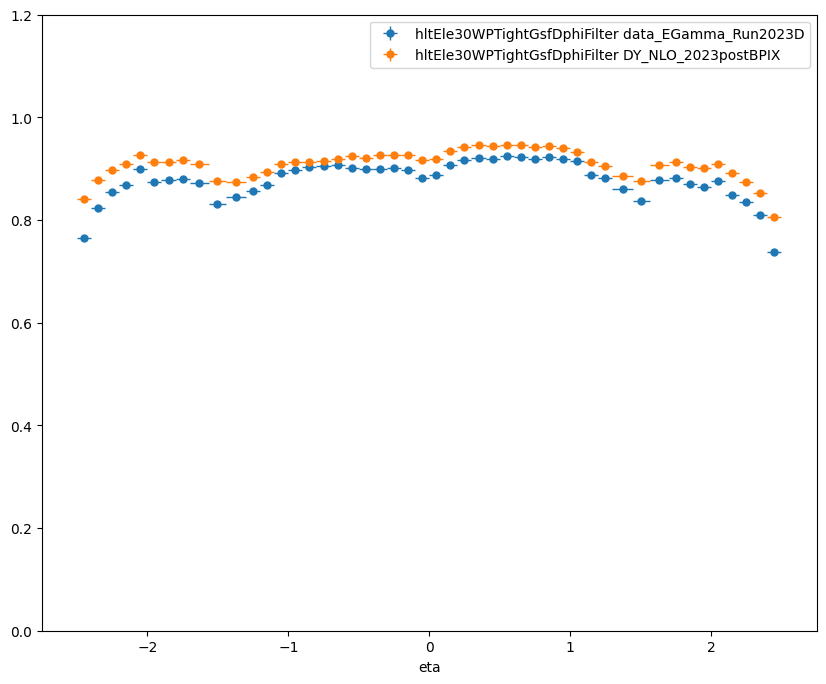

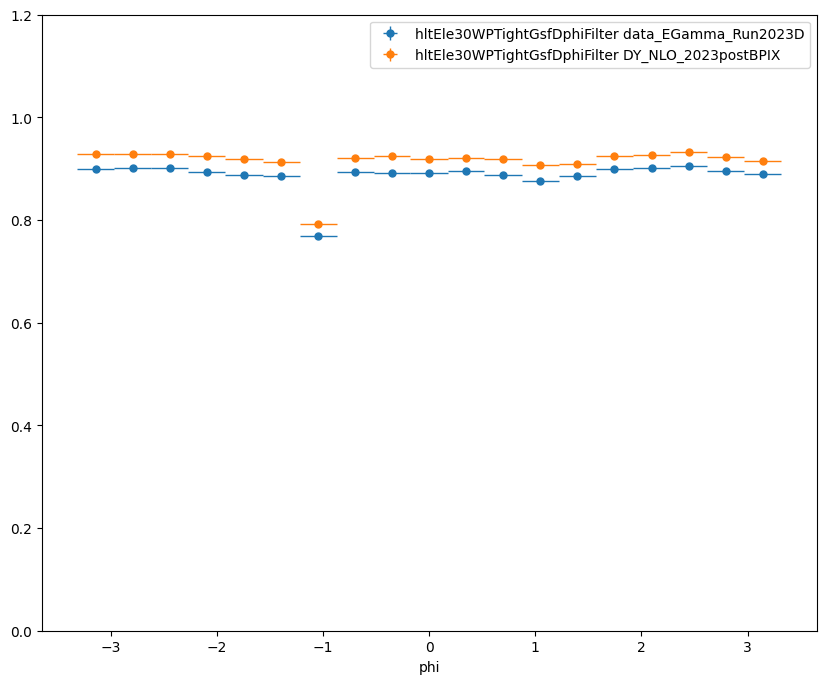

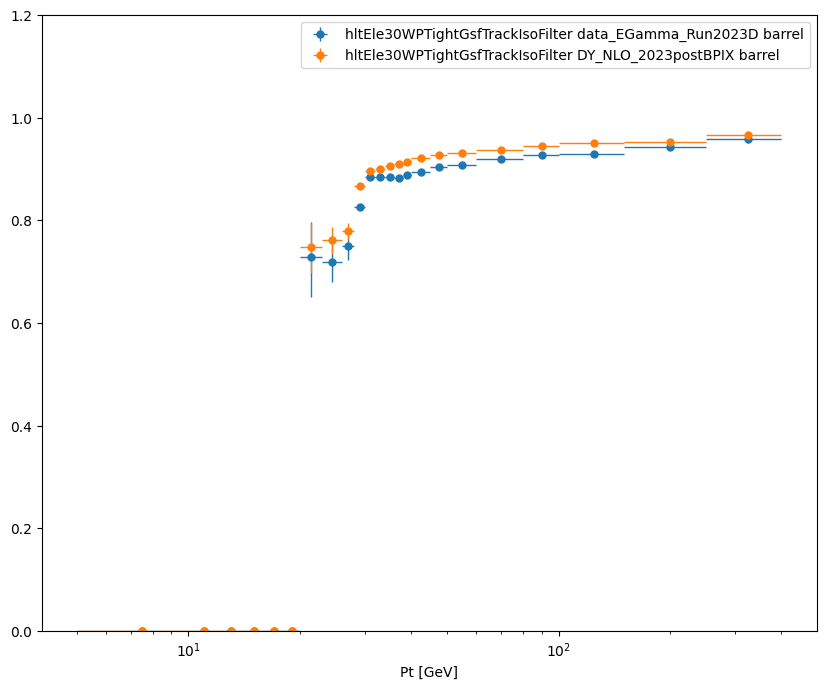

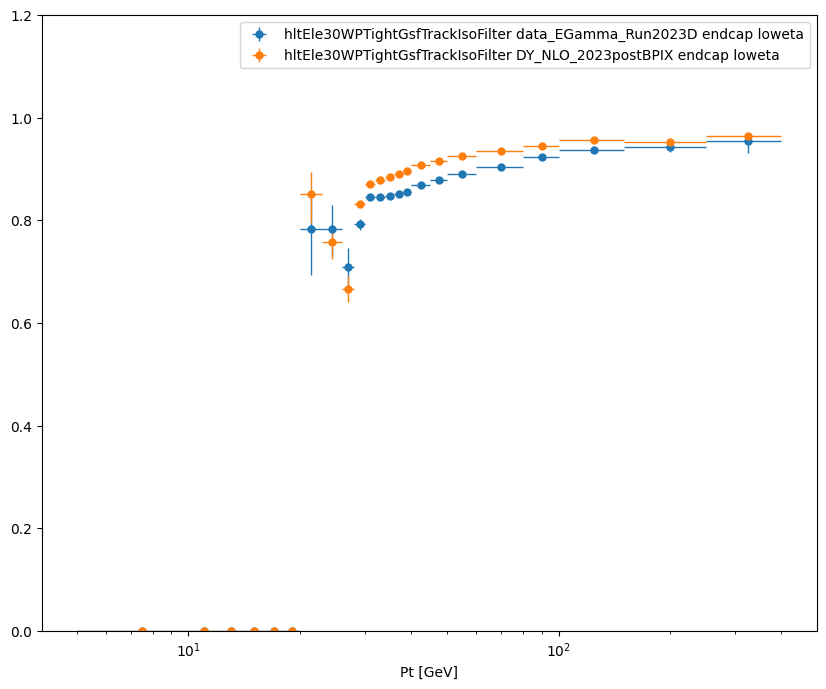

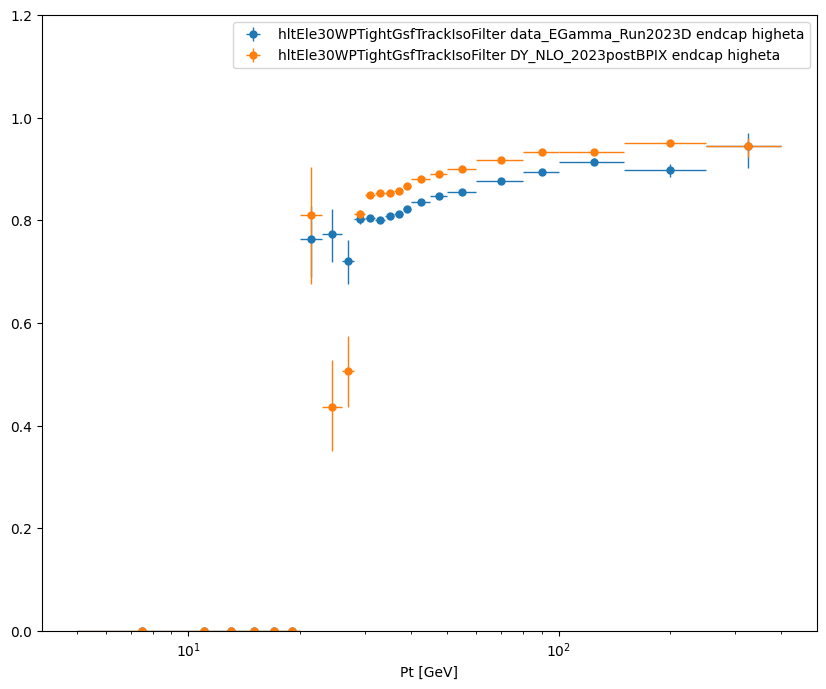

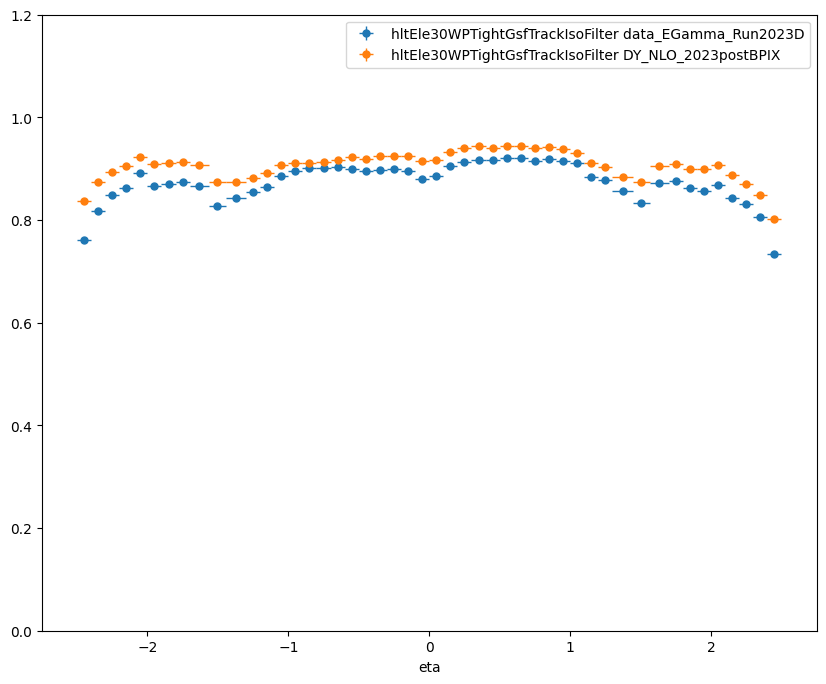

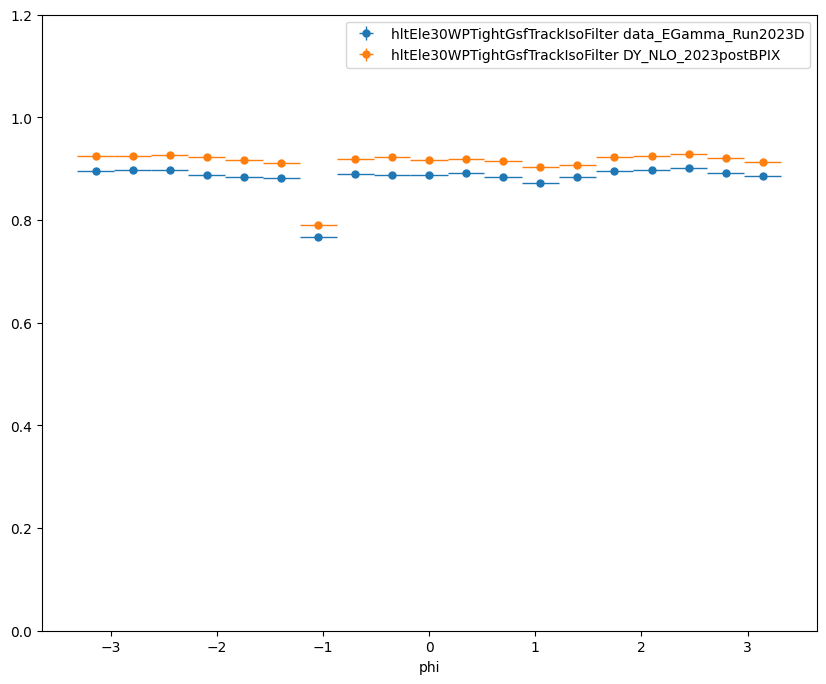

In [16]:
for filter in filters_to_check:
    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["barrel"]["passing"],
            hists["pt"]["barrel"]["failing"],
            label=f"{filter} {dataset} barrel",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["endcap_loweta"]["passing"],
            hists["pt"]["endcap_loweta"]["failing"],
            label=f"{filter} {dataset} endcap loweta",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["pt"]["endcap_higheta"]["passing"],
            hists["pt"]["endcap_higheta"]["failing"],
            label=f"{filter} {dataset} endcap higheta",
        )
    plt.ylim(0, 1.2)
    plt.xscale("log")
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["eta"]["entire"]["passing"],
            hists["eta"]["entire"]["failing"],
            label=f"{filter} {dataset}",
        )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()

    all_hists = out[filter]
    plt.figure(figsize=(10, 8))
    for dataset, hists in all_hists.items():
        plot_efficiency(
            hists["phi"]["entire"]["passing"],
            hists["phi"]["entire"]["failing"],
            label=f"{filter} {dataset}",
        )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.show()